In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# WICHTIG!!!

### Benötigen wir die marginal_cost tags in den Modellen, wenn wir instandhaltung vernachlässigen?
Generell haben wir bis auf das Netz oder Gas ja keine marginal cost, da diese ja immer pro kWh einfließen. Instandhaltung müssten wir demnach dann auf den Wert €/kWh runterbrechen was echt schwierig bei unseren Komponenten wird. 

##### Falls wir keine marginal_costs mehr brauchen -> alle "marginal_cost" Parameter aus den Modellen löschen vor Abgabe. Wir sollten keine unnötigen parameter mehr in den Modellen stehen haben. Lifetime und build year bei den standard modellen habe ich schon weitesgehend rausgenommen

**Liste der noch zu erledigenden Dinge:** 
* kommentieren (codeblöcke kommentieren, Docstrings)
* bereinigen von Unnötigen Funktionen, Parametern etc.
* Plausibilitätscheck, Backtesting, Sensitivitätsanalyse (Wofür entscheiden wir uns für unser Modell?)
    - insbesondere bei h2_stored schauen, warum so wenig eingespeichert wurde (hier insbesondere "analyse"-Funktion bzw. "def results_summary")

**Benötigte Markdownzellen** 
* Fragestellung und Subfragestellungen um diese zu beantworten
* Datenvalidierung und validierung der Eignung in Form einer Tabelle
* Ausformulierte Markdown Zellen für Referenz und H2 Modelle mit kurzbeschreibung des Umfangs
* Einordnung der Ergebnisse als Markdown Zelle in Schriftlicher form
* Grenzen der Simulation und der Ergebnisse (die sich durch eventuelle vernachlässigungen wie Komponentenbezogene Instandhaltung

### Idee für eine Übergeordnete Fragestellung unter der wir dann mehrere kleine Fragestellungen mit kleinen Modellen Beantworten können: 
1. Welche technisch-ökonomischen Parametergrenzwerte sind im Kontext des Energieträgerwandels (Fossil-zu-Wasserstoff) für einen Um- oder Zubau einer saisonalen Speicher- und Versorgungsanlage in Eigenheimen und am Beispiel eines Einfamilienhauses in Wesseling relevant, um den Ausbau von Wasserstoffsystemen zu unterstützen und von welchem aktuellen Anlagenbestand ist eine Investition in einen Um- oder Zubau Empfehlenswert?** 
2. Welche spezifischen Investitionskosten müssen Wasserstoff-Systemkomponenten für eine erweiterte saisonale Speicherung erreichen, um ein Einfamilienhaus in Wesseling mit durchschnittlichem Strom- und Wärmebedarf, verglichen mit etablierten Energiekonzepten(PV + Batteriespeicher + Gasheizung/Wärmepumpe) mindestens äquivalent wirtschaftlich und konkurrenzfähig zu versorgen und korrelieren die notwendigen spezifischen Investitionskosten mit der Bewohneranzahl des Gebäudes?

3. Welche spezifischen Investitionskosten müssen für die Erweiterung verschiedener Energiekonzepte mit einem saisonalen Wasserstoffstpeicher bei einem Einfmailienhaus in Wesseling mit durchschnittlichem Strom- und Wärmebedarf in Abhängigkeit der Personenanzahl getätigt werden, sodass diese in einem Betrachtungszeitraum von 2020 bis 2050 "äquivalent wirtschaftlich und konkurrenzfähig" sind?
4. Welche spezifischen Investitionskosten und Lebensdauern müssen für die Erweiterung verschiedener Energiekonzepte mit einem saisonalen Wasserstoffspeicher- und Versorgungsystem bei einem Einfamilienhaus in Köln Wesseling mit durchschnittlichem Strom- und Wärmebedarf sichergestellt werden, sodass diese in einem Betrachtungszeitraum von 2020 bis 2050 "äquivalent wirtschaftlich und konkurrenzfähig" sind und welchen Einfluss hat die Personenanzahl auf ein konkurrenzfähiges System?

In [ ]:
#Markdown Zellen formatierung Beispiel für die Dokumentation
'''
# Abschnitt 1 (H1)
## Abschnitt 1.1 (H2)

**Ungeordnete Liste**
* Erster Eintrag
* Zweiter Eintrag
* Dritter Eintrag

**Geordnete Liste**
1. Erster Eintrag
2. Zweiter Eintrag
3. Dritter Eintrag
> Blockzitat mit zwei Abschnitten. 
>
> Lorem ipsum dolor sit amet
> consectetuer adipiscing elit 
> 
> Donec sit amet nisl  
> Aliquam semper ipsum sit amet velit
'''

# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Preisdaten: SMARD
Großhandels Strompreis auf die kWh-heruntergerechnet als Beispiel für einen Strompreis von z.B. dem Anbieter Tibber, welcher den Großhandelspreis an den Kunden stündlich weitergibt

### Lastprofile Synthetisch: synPRO (Frauenhofer)
Getrennte profile für Warmwasser, Heizung und Strom jeweils für einen 2, 4 und 6 Personen Haushalt in einem EFH

In [2]:
# data imports

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])


# load loadprofile data
# 2 Residents EFH
el_2p = pd.read_csv('data/loads/2Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_2p = pd.read_csv('data/loads/2Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_2p = pd.read_csv('data/loads/2Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 4 Residents EFH
el_4p = pd.read_csv('data/loads/4Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_4p = pd.read_csv('data/loads/4Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_4p = pd.read_csv('data/loads/4Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 6 Residents EFH
el_6p = pd.read_csv('data/loads/6Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_6p = pd.read_csv('data/loads/6Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_6p = pd.read_csv('data/loads/6Pers/neighbourhood_htg.csv', comment='#', sep=';')

# fill dataframe
df_data = pd.DataFrame()
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()
df_data['ww_load_2p'] = dhw_2p['total']
df_data['ww_load_4p'] = dhw_4p['total']
df_data['ww_load_6p'] = dhw_6p['total']
df_data['e_load_2p'] = el_2p['total']
df_data['e_load_4p'] = el_4p['total']
df_data['e_load_6p'] = el_6p['total']
df_data['h_load_2p'] = htg_2p['total_htg']
df_data['h_load_4p'] = htg_4p['total_htg']
df_data['h_load_6p'] = htg_6p['total_htg']

# season operation of hydrogen system (If PV-power is higher than 0.55 then use ely, fc just in winter months)
df_season = pd.DataFrame()
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= 0.55 else 0)
df_season['fc_pv_threshhold'] = 1 - df_season['ely_pv_threshhold']
#df_season['ely'] = [1 if 1416 <= x <= 7296 else 0 for x in range(8760)]
df_season['ely'] = [1 for x in range(8760)]
df_season['fc'] = [0 if 3624 <= x <= 6552 else 1 for x in range(8760)]


#df_data
#df_data.plot(y=["h_load_2p", "ww_load_2p", "e_load_2p"])
#df_season.plot(y=["ely", "fc"])
#df_season['ely']

In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

pv  temp  ww_load_2p  ww_load_4p  ww_load_6p  e_load_2p  e_load_4p  \
0     0.0  12.6    0.000000         0.0    1.518594   0.087042   0.108191   
1     0.0  13.0    0.000000         0.0    0.000000   0.087303   0.086217   
2     0.0  12.6    0.000000         0.0    0.000000   0.086005   0.085922   
3     0.0  12.2    0.000000         0.0    0.000000   0.082747   0.109169   
4     0.0  12.8    0.000000         0.0    0.000000   0.075984   0.108558   
...   ...   ...         ...         ...         ...        ...        ...   
8755  0.0  15.1    0.000000         0.0    0.000000   0.143545   0.545067   
8756  0.0  15.9    0.000000         0.0    0.035994   0.142139   0.228792   
8757  0.0  15.9    0.000000         0.0    0.000000   0.142010   0.291029   
8758  0.0  15.6    2.712356         0.0    0.971850   0.141723   0.330328   
8759  0.0  15.4    0.000000         0.0    1.829137   0.093288   0.226008   

      e_load_6p  h_load_2p  h_load_4p  h_load_6p  wp_COP_interp  \
0      0.136886   1.287577   1.274003   1.295842          3.315   
1      0.135976   1.799948   1.798675   1.809386          3.325   
2      0.135816   2.128495   2.127315   2.138208          3.315   
3      0.181411   2.381928   2.364143   2.376183          3.305   
4      0.179553   2.553156   2.529228   2.542549          3.320   
...         ...        ...        ...        ...            ...   
8755   0.574078   1.614701   1.330839   1.452981          3.378   
8756   1.003943   1.681241   1.550685   1.110155          3.398   
8757   0.977002   1.713969   1.539984   1.098378          3.398   
8758   0.473260   1.708129   1.495063   1.420826          3.390   
8759   0.482663   1.787524   1.590020   1.512540          3.385   

      wp_power_consumption  wp_power_cons_norm  
0                    18.88              1.5104  
1                    18.89              1.5112  
2                    18.88              1.5104  
3                    18.87              1.5096  
4                    18.89              1.5112  
...                    ...                 ...  
8755                 18.94              1.5152  
8756                 18.96              1.5168  
8757                 18.96              1.5168  
8758                 18.95              1.5160  
8759                 18.95              1.5160  

[8760 rows x 14 columns]

In [51]:
# globals for multi incestment periods
multi_years = range(2023, 2044, 5)
observation_period = multi_years[-1] - multi_years[0]
max_lifetime = observation_period + 1
freq = 1

snapshots = pd.DatetimeIndex([])
for year in multi_years:
    period = pd.date_range(start='{}-01-01 00:00'.format(year),
                           freq='{}H'.format(str(freq)),
                           periods=8760 / float(freq),
                          )
    snapshots = snapshots.append(period)
    
multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])

In [36]:
# reform data for multi investment periods

# Multi Year Datasets
# copy data
df_mdata = df_data.copy()
df_mseason = df_season.copy()

# reindex datasets
df_mdata.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')
df_mseason.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')

# rescale if frequency > 1
if freq > 1:
    df_mdata = df_mdata.resample(rule='{}H'.format(str(freq))).mean()
    df_mseason = df_mseason.resample(rule='{}H'.format(str(freq))).mean()
    

# multi period dataframe
# df_mdata_1h_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mdata_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mseason_xy = pd.concat([df_mseason]*len(multi_years), ignore_index=True)


# Price Scenarios for Electricity Rate
price_high = df_price_data['2022']
price_midhigh_high = (df_price_data['2022'] + ((df_price_data['2022'] + df_price_data['2021'])/2)) / 2
price_midhigh = (df_price_data['2022'] + df_price_data['2021'])/2
price_mid_midhigh = (df_price_data['2021'] + ((df_price_data['2021'] + df_price_data['2022'])/2)) / 2
price_mid = df_price_data['2021']
price_mid_midlow = (df_price_data['2021'] + ((df_price_data['2021'] + df_price_data['2020'])/2)) / 2
price_midlow = (df_price_data['2020'] + df_price_data['2021'])/2
price_midlow_low = (df_price_data['2020'] + ((df_price_data['2021'] + df_price_data['2020'])/2)) / 2
price_low = df_price_data['2020']
price_profile_lst = [price_high, price_midhigh_high, price_midhigh, price_mid_midhigh, price_mid,
                     price_mid_midlow, price_midlow, price_midlow_low, price_low]
support_year_amount = len(multi_years)
# data basis
price_scenario_h_to_l = price_high
price_scenario_l_to_h = price_low
# concatenating from high to low and the other way around
for i in range(1, support_year_amount):
    price_scenario_h_to_l = pd.concat([price_scenario_h_to_l, price_profile_lst[i]], ignore_index=True)
    price_scenario_l_to_h = pd.concat([price_scenario_l_to_h, price_profile_lst[len(price_profile_lst)-(i+1)]], ignore_index=True)
# reindex datasets
price_scenario_h_to_l.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760*support_year_amount, freq='H')
price_scenario_l_to_h.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760*support_year_amount, freq='H')

if freq > 1:
    # high price szenario (h_to_l): higher yearly average price -> lower average prices
    price_scenario_h_to_l_xy = price_scenario_h_to_l.resample(rule='{}H'.format(str(freq))).mean()
    # high price szenario (l_to_h): lower yearly average price -> higher average prices
    price_scenario_l_to_h_xy = price_scenario_l_to_h.resample(rule='{}H'.format(str(freq))).mean()
else:
    price_scenario_h_to_l_xy = price_scenario_h_to_l
    price_scenario_l_to_h_xy = price_scenario_l_to_h
    
# indexing
price_scenario_h_to_l_xy.index = multi_index
price_scenario_h_to_l_xy.index = multi_index
df_mdata_xy.index = multi_index
df_mseason_xy.index = multi_index


#print(df_data['e_load_4p'].sum())
#print(df_mdata_3h['e_load_4p'].sum()*freq)
#print(df_mdata_4h['e_load_4p'].sum()*4)
#print(df_mdata_5h['e_load_4p'].sum()*5)
#df_mdata_3h_xy

# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

Kapitalkosten: Gesamtsystem spezifisch auf Nennleistung + Angabe der Lifetime

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [37]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.071    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²


# plot parameters
plt.rcParams.update({'font.size': 12})

# data calculations 
# weightings of h2 components from total system price
# specific cost assumptions
capital_cost_picea = 85000 # €
cap_h2_storage = 3891 # €/stück [€/bündel / (Nm³/bündel * kWh/Nm³)] https://www.linde-gas.de/shop/de/de-ig/wasserstoff-50-bündel-wasserstoff-50-buendel
cap_ely = 8065.25 # €/kW https://h2-batarow.com/elektrolyseure/ely-8 (Durchschnitt von 2,4 und 10kW elektrolyseur)
cap_fc = 5000 # €/kW https://www.haus.de/smart-home/brennstoffzellenheizung-funktion-und-kosten-28912 (Stackkosten)
cap_battery = 1200 # €/kWh
cap_total_system = cap_h2_storage + cap_battery + cap_ely + cap_fc
specific_cap_share = {'h2_storage': cap_h2_storage / cap_total_system,
                      'battery': cap_battery / cap_total_system,
                      'ely': cap_ely / cap_total_system,
                      'fc' : cap_fc / cap_total_system} 


print(specific_cap_share)

# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'p_max_pu_multi': df_mdata_xy['pv'],
    'capital_cost': 1750, #€/kWp
    'marginal_cost': 0,
    'lifetime' : 20,
    'pv_co2': 0   #kg/kWh
}

# Picea Home System: https://www.homepowersolutions.de/produkt/
# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'p_max_pu': df_season['fc'],
    'p_max_pu_multi': df_mseason_xy['fc'],
    'el_efficiency': 0.6,
    'th_efficiency': 0.3,
    'capital_cost': (capital_cost_picea * specific_cap_share['fc'])/1.5,
    'marginal_cost': 0,
    'lifetime' : 10,
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'p_max_pu': df_season['ely'],
    'p_max_pu_multi': df_mseason_xy['ely'],
    'el_efficiency': 0.7,
    'th_efficiency': 0.2,
    'capital_cost': (capital_cost_picea * specific_cap_share['ely'])/2.3,
    'marginal_cost': 0,
    'lifetime' : 10,
}

# H2 gas storage
h2_storage_params = {
    'e_nom_max': 1500/fc_params['el_efficiency'], #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min': 300/fc_params['el_efficiency'],
    'e_nom': 300/fc_params['el_efficiency'],
    'capital_cost': (capital_cost_picea * specific_cap_share['h2_storage'])/(300/fc_params['el_efficiency']), # € picea system spezifisch auf die durchschnittliche Kapazität(Mittelwert von min und max)
    'marginal_cost': 0,
    'standing_loss': 0.00001,
    'lifetime' : 10,
    'h2_co2': 0   #kg/kWh
}

# battery storage
battery_picea_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 10,
    'capital_cost': (capital_cost_picea * specific_cap_share['battery'])/20,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
    'lifetime' : 10
}



# Standard battery: https://greencell.global/de/energie-speichern/4846-green-cell-gc-powernest-energiespeicher-lifepo4-akku-5-kwh-48-v.html#specification
battery_params = {
    'e_nom': 5,
    'e_nom_min': 2,
    'capital_cost': 2630/5,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5,
    'discharge_power': 5,
    'lifetime' : 10
}


# heatpump -> wp: https://www.viessmann.de/de/wissen/technik-und-systeme/waermepumpe.html
wp_params = {
    'p_nom': 13.2,
    'efficiency': df_data['wp_COP_interp'],
    'efficiency_multi': df_mdata_xy['wp_COP_interp'],
    'capital_cost': 20000/13.2,
    'marginal_cost': 0,
    'lifetime' : 20
}

# heat storage: https://www.viessmann.de/de/produkte/warmwasserbereiter/vitocell-140-e.html
heat_storage_params = {
    'e_nom': 15, #kWh
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 1465/15,
    'marginal_cost': 0,
    'standing_loss': 0.0875,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
    'lifetime' : 20
}

# heating rod: https://www.g2-energy-systems.de/elektroheizelemente-heizkoerper/elektroheizelemente/gekapselte-keramikheizpatronen/gekapselte-keramikheizstaebe-mit-flansch-keramische-heizelemente.html
heating_rod_params = {
    'p_nom': 2.2, #kW
    'p_nom_picea': 4.5, #kW
    'efficiency': 1,
    'capital_cost': 210/2.2,
    'capital_cost_picea': 210/4.5,
    'marginal_cost': 0,
    'lifetime' : 20
}

# Gas Boiler: https://www.klimaworld.com/vaillant-brennwerttherme-ecotec-plus-vcw-25-32-cs-1-5-0010043902.html?utm_source=google&utm_medium=cpc&_attribution=GoogleAds&gclid=CjwKCAjw5_GmBhBIEiwA5QSMxLOYbOb4IxBXSJmPPku7bedGxHHWe1i2163OTuT7KkkfBs4bLBmYkBoCTWcQAvD_BwE
gas_boiler_params = {
    'p_nom': 25, #kW
    'efficiency': 1.09,
    'capital_cost': 5650/25,
    'marginal_cost': 0,
    'lifetime' : 20
}


#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434, #kg/kWh (https://de.statista.com/statistik/daten/studie/38897/umfrage/co2-emissionsfaktor-fuer-den-strommix-in-deutschland-seit-1990/#:~:text=Im%20Jahr%202022%20wurde%20der,mit%20kleinen%20Ausnahmen%20kontinuierlich%20ab.)
    'co2_emissions_gas' : 0.202 #kg/kWh (https://www.verbraucherzentrale.de/wissen/energie/heizen-und-warmwasser/klimapaket-was-bedeutet-es-fuer-mieter-und-hausbesitzer-43806)
}

#ely_params['p_max_pu']
#fc_params['p_max_pu']
#pv_params['p_max_pu'].plot()
#wp_params['efficiency']
#wp_params['efficiency_multi']

{'h2_storage': 0.2143063683304647, 'battery': 0.06609294320137693, 'ely': 0.4442134251290878, 'fc': 0.27538726333907054}


# Auswertungs- und Grafische Darstellungsfunktionen
Grundfunktionen der nachfolgenden Funktionen. Für eine Detailbeschreibung der Argumente und Returns, kann der Docstring eingesehen werden

##### opt_series_summary()
Funktion fasst wahlweise eines Netzwerkpaares (Referenz und H2) für den Typ Gas oder EE, oder aller 4 Netzwerke die time series Daten der Optimierungsergebnisse in eine Übersicht zusammen.

##### opt_value_summary() 
Funktion fasst wahlweise eines Netzwerkpaares (Referenz und H2) für den Typ Gas oder EE, oder aller 4 Netzwerke die p_nom_opt Werte aus den Optimierungsergebnissen in eine Übersicht zusammen.

##### plot_series_data()
Funktion stellt die time series der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### plot_opt_data()
Funktion stellt die p_nom_opt der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### cost_reduction_calculation()
Funktion ermittelt ein Learning Curve Modell Datensatz zur Kostenreduktion von Wasserstoffsystemen auf Basis von Studien zur Kostenanalyse von Elektrolyseuren. Ergebnis sind drei Kostenreduktionsszenarien mit



In [ ]:
# Kann die Weg? oder brauchen wir davon noch Werte ? 
def auswertungsfunktion(network, sensitivity_variable=0, co2_constraint=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable], columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
       
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
       
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

In [38]:
def opt_series_summary(network, h2=False, h2_gas=False, ref_gas=False, ref=False, MI_series_summary=False):
    
    '''
    This Method sums up all optimized time series data for each component
    
    return: 
    df_res_series (Networks optimized Time Series Data)
    
    use: df = opt_series_summary(NETWORK_NAME, CHOICE_VARIABLE=True,
                                 MULTI_INVESTMENT_PERIOD_VARIABLE=False/True)
    '''
    
    if MI_series_summary == True:
        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)
            
        date_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
    else: 
        date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
        
    if h2 == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), 
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), 
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                    index=date_index, columns=['WP']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), 
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                        index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                        index=date_index, columns=['PV']),
                                           pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                        index=date_index, columns=['Einspeisung']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                        index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                        index=date_index, columns=['Electric Load']),
                                           pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                        index=date_index, columns=['Heat load']),
                                           pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                        index=date_index, columns=['WW load']),
                                           pd.DataFrame(data=(network.stores_t.e.h2_storage
                                                              + network.stores_t.e.h2_storage_1
                                                              + network.stores_t.e.h2_storage_2).to_numpy(),
                                                        index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=(network.links_t.p0.fc 
                                                              + network.links_t.p0.fc_1 
                                                              + network.links_t.p0.fc_2).to_numpy(), 
                                                        index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=(network.links_t.p0.ely
                                                              + network.links_t.p0.ely_1 
                                                              + network.links_t.p0.ely_2).to_numpy(),
                                                        index=date_index, columns=['Electrolysis']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=(network.stores_t.e.battery 
                                                              + network.stores_t.e.battery_1 
                                                              + network.stores_t.e.battery_2).to_numpy(),
                                                        index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                        index=date_index, columns=['Heat Storage'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                            index=date_index, columns=['Grid']),
                                               pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                            index=date_index, columns=['PV']),
                                               pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                            index=date_index, columns=['Einspeisung']),
                                               pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                            index=date_index, columns=['WP']),
                                               pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                            index=date_index, columns=['Electric Load']),
                                               pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                            index=date_index, columns=['Heat load']),
                                               pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                            index=date_index, columns=['WW load']),
                                               pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                                  + network.stores_t.e.h2_storage_1).to_numpy(),
                                                            index=date_index, columns=['H2 Storage']),
                                               pd.DataFrame(data=(network.links_t.p0.fc 
                                                                  + network.links_t.p0.fc_1).to_numpy(),
                                                            index=date_index, columns=['Fuel Cell']),
                                               pd.DataFrame(data=(network.links_t.p0.ely
                                                                  + network.links_t.p0.ely_1).to_numpy(),
                                                            index=date_index, columns=['Electrolysis']),
                                               pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery OUT']),
                                               pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore OUT']),
                                               pd.DataFrame(data=(network.stores_t.e.battery 
                                                                  + network.stores_t.e.battery_1).to_numpy(),
                                                            index=date_index, columns=['Battery']),
                                               pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                            index=date_index, columns=['Heat Storage'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                                index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), 
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), 
                                                                index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage'])], axis=1)
    elif h2_gas == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                                index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                                index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                                index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(),
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(),
                                                                index=date_index, columns=['Electrolysis'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis'])], axis=1)
    elif ref_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), 
                                                index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    elif ref == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), 
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    else:
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
            
    
    return df_res_series

In [39]:
def opt_value_summary(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method sums up all optimized values for power and capacity
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    
    return: 
    df_opt_values (Networks optimized values for comparation of GAS or EE respectively)
    
    use: df = opt_value_summary(NETWORK_NAME1, NETWORK_NAME2, ..., ... , CHOICE_VARIABLE=True)
    '''
    if n12 == True: # compare Gas Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df_opt_values = pd.concat([df1, df2], axis=1, join='outer')
        
    elif n34 == True: # compare EE Networks
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df3, df4], axis=1, join='outer')
        
    elif n_all == True: # compare all Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df1, df2, df3, df4], axis=1, join='outer')
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
    
    return df_opt_values

In [ ]:
# Kann eventuell weg und neu geschrieben werden mit werten aus def analyse_single_Network
# Datensatz über eine variationsstudie zusammentragen -> Daten verbinden -> Auswerten
def calc_global_results(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method calculates results of each network and additionally combined results
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    '''
    df_global_results = pd.DataFrame()
    
    # calculate result information
    if n12 == True: # compare Gas Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        # grid ratios
        el_ratio1 = np.round((n1.generators_t.p.grid.sum()/grid_supply1)*100, 2)
        gas_ratio1 = np.round((n1.generators_t.p.gas.sum()/grid_supply1)*100, 2) 
        el_ratio2 = np.round((n2.generators_t.p.grid.sum()/grid_supply2)*100, 2) 
        gas_ratio2 = np.round((n2.generators_t.p.gas.sum()/grid_supply2)*100, 2) 
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        # self sufficiency
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        # revenues from energy savings network intern
        rev_save1i = ((n1.generators_t.p.pv.sum() - n1.generators_t.p.infeed.sum()) 
                      * -((el_ratio1 * electricity_rate)+(gas_ratio1 * gas_price))
                     )
        rev_save2i = ((n2.generators_t.p.pv.sum() - n2.generators_t.p.infeed.sum()) 
                      * -((el_ratio2 * electricity_rate)+(gas_ratio2 * gas_price))
                     )
        
        # revenues from energy savings compared to reference network
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        if rev_save2 >= 0:
            rev_save2 = 0

            
        # payback period compared (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        
        # payback period intern
        payback1i = capex1 / -(rev_inf1 + rev_save1i)
        payback2i = capex2 / -(rev_inf2 + rev_save2i)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio1, gas_ratio2]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio1, el_ratio2]
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save1i, rev_save2i], 2)
        df_global_results['Revenues Savings compared [€/a]'] = np.round([rev_save1, rev_save2], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback1i, payback2i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback1, payback2], 0)
        
    elif n34 == True: # compare EE Networks
        # grid supply
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        #grid ratios
        el_ratio3 = 100
        gas_ratio3 = 100 - el_ratio3
        el_ratio4 = 100
        gas_ratio4 = 100 - el_ratio4
        # loads
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        
        # revenues from energy savings network intern
        rev_save3i = (n3.generators_t.p.pv.sum() - n3.generators_t.p.infeed.sum()) * -(electricity_rate)
        rev_save4i = (n4.generators_t.p.pv.sum() - n4.generators_t.p.infeed.sum()) * -(electricity_rate)
        
        # revenues from energy savings compared to reference network
        rev_save3 = 0           
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        if rev_save4 >= 0:
            rev_save4 = 0
            
        # payback period compared (Amortisation)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        # payback period intern
        payback3i = capex3 / -(rev_inf3 + rev_save3i)
        payback4i = capex4 / -(rev_inf4 + rev_save4i)
        
        df_global_results['Network'] = ['Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply3, grid_supply4], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio3, gas_ratio4]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio3, el_ratio4]
        df_global_results['Total Load [kWh/a]'] = np.round([load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save3i, rev_save4i], 2) #HIER IST DEFINITIV NOCH EIN FEHLER!!!!!!!!!!!
        df_global_results['Revenues Savings compared[€/a]'] = np.round([rev_save3, rev_save4], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback3i, payback4i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback3, payback4], 0)
        
    elif n_all == True: # compare All Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        # grid ratios
        el_ratio1 = np.round((n1.generators_t.p.grid.sum()/grid_supply1)*100, 2)
        gas_ratio1 = np.round((n1.generators_t.p.gas.sum()/grid_supply1)*100, 2) 
        el_ratio2 = np.round((n2.generators_t.p.grid.sum()/grid_supply2)*100, 2) 
        gas_ratio2 = np.round((n2.generators_t.p.gas.sum()/grid_supply2)*100, 2) 
        el_ratio3 = 100
        gas_ratio3 = 100 - el_ratio3
        el_ratio4 = 100
        gas_ratio4 = 100 - el_ratio4
        
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        
        # revenues from energy savings network intern
        rev_save1i = ((n1.generators_t.p.pv.sum() - n1.generators_t.p.infeed.sum()) 
                      * -((el_ratio1 * electricity_rate)+(gas_ratio1 * gas_price))
                     )
        rev_save2i = ((n2.generators_t.p.pv.sum() - n2.generators_t.p.infeed.sum()) 
                      * -((el_ratio2 * electricity_rate)+(gas_ratio2 * gas_price))
                     )
        rev_save3i = (n3.generators_t.p.pv.sum() - n3.generators_t.p.infeed.sum()) * -(electricity_rate)
        rev_save4i = (n4.generators_t.p.pv.sum() - n4.generators_t.p.infeed.sum()) * -(electricity_rate)
        
        # revenues from energy savings compared to reference network
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        rev_save3 = 0
                     
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        if rev_save2 >= 0:
            rev_save2 = 0
        if rev_save4 >= 0:
            rev_save4 = 0
            
        # payback period compared (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        # payback period intern
        payback1i = capex1 / -(rev_inf1 + rev_save1i)
        payback2i = capex2 / -(rev_inf2 + rev_save2i)
        payback3i = capex3 / -(rev_inf3 + rev_save3i)
        payback4i = capex4 / -(rev_inf4 + rev_save4i)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas', 'Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2, grid_supply3, grid_supply4], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio1, gas_ratio2, gas_ratio3, gas_ratio4]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio1, el_ratio2, el_ratio3, el_ratio4]
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2, load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2, aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2, co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2, capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2, opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2, rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save1i, rev_save2i, rev_save3i, rev_save4i], 2)
        df_global_results['Revenues Savings compared [€/a]'] = np.round([rev_save1, rev_save2, rev_save3, rev_save4], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback1i, payback2i, payback3i, payback4i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback1, payback2, payback3, payback4], 0)
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
        
    return df_global_results

In [40]:
def plot_series_data(df_series_t, MI_plot_series=False):
    """
    This function generates plots to visualize time series data from the provided
    DataFrame `df_series_t`. Each column in the DataFrame represents a different
    time series alle time series are plotted in an overview in 5:4 or 4:4 Matrix.

    Parameters:
        df_series_t (DataFrame): The DataFrame containing time series data of each networks components.
        multiinvest (bool, optional): A Flag with the decicion on the x_axes format and the time period 
        of the plot summary. Default is False.

    Returns:
        None
    """
    # generate color cycle
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # if more than 16 datasets -> add new row in plot
    if df_series_t.shape[1] > 16:
        rows = 5
    else:
        rows = 4
        
    # plot data
    fig, axes = plt.subplots(rows, 4, figsize=(16, 10))
    for col, ax in zip(df_series_t.columns, axes.flatten()):
        c = next(colors)["color"]
        if MI_plot_series == True:
            ax.plot(df_series_t.reset_index().index, df_series_t[col], color=c)
            ax.set_xticks(np.linspace(0, df_series_t.shape[0], len(multi_years)), labels=multi_years)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
        else:
            ax.plot(df_series_t.index, df_series_t[col], color=c)
            ax.set_xticks([])
            ax.set_xlabel("hours per year")
        ax.set_title(col)
        
        plt.subplots_adjust(wspace=.3, hspace=.65) 

In [41]:
def plot_opt_data(df_opt):
    """
    Plot overview of network optimization values for power and capacity.
    This function generates a plot to visualize the optimization values for power
    and capacity from the provided DataFrame.

    Parameters:
        df_opt (DataFrame): The DataFrame contains all optimized values (p_nom_opt;e_nom_opt).

    Returns:
        None
    """
    def get_cmap(n, name='hsv'):
        '''random color generator - SPEKTRUM'''
        return plt.cm.get_cmap(name, n)
    
    # if more than 2 dataset columns -> add new row in plot, if only 1 dataset just 1 plot
    if df_opt.shape[1] == 2:
        rows = 1
        cols = 2
        size_w = 14
        size_h = 8
    elif df_opt.shape[1] == 1:
        rows = 1
        cols = 1
        size_w = 14
        size_h = 6
    else:
        rows = 2
        cols = 2
        size_w = 14
        size_h = 8
    
    # reform the h2_storage value by /100 and rename the indicator
    if 'h2_storage' in df_opt.index:
        df_opt.loc['h2_storage'] = df_opt.loc['h2_storage'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage': 'h2_store*100'})
    if 'h2_storage_1' in df_opt.index:
        df_opt.loc['h2_storage_1'] = df_opt.loc['h2_storage_1'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_1': 'h2_store_1*100'})
    if 'h2_storage_2' in df_opt.index:
        df_opt.loc['h2_storage_2'] = df_opt.loc['h2_storage_2'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_2': 'h2_store_2*100'})
    if 'h2_storage_3' in df_opt.index:
        df_opt.loc['h2_storage_3'] = df_opt.loc['h2_storage_3'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_3': 'h2_store_3*100'})
    
    # generate colors
    N = 40
    cmap = get_cmap(N)
    
    # plot data
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(size_w, size_h), squeeze=False)
    for col, ax in zip(df_opt.columns, axes.flatten()):
        colors = [cmap(i) for i in range(0, 40, 2)]
        ax.bar(df_opt.index, df_opt[col], color=colors)
        ax.set_title(col)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim(ymin=0, ymax=30)
        plt.subplots_adjust(wspace=.2, hspace=.7)

In [42]:
def result_summary_single_network(n, h2=False, h2_gas=False, ref_gas=False, ref=False, sensitivity_variable=None,
                                  plots=False, MI_analyse_network=False, pp_compare=False):
    '''METHODS DOCSTRING
        This Methods gives a summary for a network passed as argument->(n)
        By setting the choice variable it generates datasets explicit for the given network
        Data shown by the function:
            1. Summarized energies and percentages for Grid(Electric/Gas) and Self Sufficiency Rate
            2. All p_nom_opt and e_nom_opt Values of the network
            3. Additional Plot Grafik for optimized values
            4. Time Series overview of all components as Plot Matrix
            5. Sensitivity evaluation when sensitivity variable != 0

        Returns: 
        If sensitivity variable = 0 return datasets -> print results and plots directly with argument ->(plots=True)
        df1) series_data (summary of time series data)
        df2) df_n_opt (Networks optimized values)    
        df3) analysis data (Sums of components and percentages like Self Sufficiency)
            use: df1, df2, df3 = analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True)
        otherwise:
        df1) df_sensitivity_results (Sensitivity DataFrame as output)
            use: df1 = df1.append(analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True, sensitivity_variable))
    '''
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    
    # calculate multi_factor for calculation of analysis values 
    # for results on yearly basis
    if MI_analyse_network == True:
        multi_factor = freq / support_year_amount
    else:
        multi_factor = 1.0
        
    # co2 and capex calculation (equal for all networks)
    co2_val = (n.generators_t.p.sum() * multi_factor / n.generators.efficiency *
               pd.merge(n.carriers, n.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    capex = ((n.stores.e_nom_opt * n.stores.capital_cost).sum() 
             + (n.generators.p_nom_opt * n.generators.capital_cost).sum() 
             + (n.links.p_nom_opt * n.links.capital_cost).sum())
    total_load = ((n.loads_t.p_set.electric_load.sum() + n.loads_t.p_set.heat_load.sum() 
                   + n.loads_t.p_set.ww_load.sum()) * multi_factor)
    
    # network choice
    if h2 == True:
        
        # decide about multiinvest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2=True)
            
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=['H2 EE optimized'])], axis=0)
        
        # summary of analytic value sums
        # side calculation
        
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
                    
        opex = (n.generators_t.p.grid.sum() * multi_factor * electricity_rate)
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))
        
        self_sufficiency = (((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100)
                            

        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)

        
    elif h2_gas == True:
        
        # decide about multi_invest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2),
                                           index=n.generators.p_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["H2 Gas optimized"])], axis=0)
        
        # summary of analytic value sums
        # side calculations
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
        
        
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
        
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))             
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
        
        
    elif ref_gas == True:
        
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref Gas optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
                                          
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))    
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0,
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    elif ref == True:
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref EE optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
        rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate))

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save)) 
        
        self_sufficiency = ((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0, 
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    else:
        # if no choice variable set -> 
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
    
    
    # decide for return values and output
    if sensitivity_variable != None:
        # generate sensitivity results
        df_sensitivity_results = pd.concat([pd.DataFrame(data=df_analysis.loc['CO2-Emission [kg/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['CO2-Emission [kg/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV generated [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['PV generated [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV used [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Amount Infeed [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Amount Infeed [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Load Total [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Load Total [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid electric [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Grid electric [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid gas [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Grid gas [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio electric [%]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Ratio electric [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio gas [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Ratio gas [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Battery stored [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Battery stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat Storage stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Heat Storage stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['converted to H2 [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['converted to H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 used [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat from H2 [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Heat from H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Self Sufficiency [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Self Sufficiency [%]']),
                                            pd.DataFrame(data=df_analysis.loc['CAPEX [€]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['CAPEX [€]']),
                                            pd.DataFrame(data=df_analysis.loc['OPEX [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['OPEX [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Infeed [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Infeed [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Savings [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Savings [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Payback Period [a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Payback Period [a]'])], axis=1)
    
        return df_sensitivity_results
    elif pp_compare == True:
        return df_analysis
    else:
        if plots == True:
            print("\nNetwork analytics: \n", df_analysis, "\n\nOptimized p_nom and e_nom and equivalent plot: \n", df_n_opt)
            plot_opt_data(df_n_opt)
            if MI_analyse_network == True:
                plot_series_data(series_data, MI_plot_series=True)
            else:
                plot_series_data(series_data)
            return (series_data, df_n_opt, df_analysis)
        else:
            return (series_data, df_n_opt, df_analysis)

In [43]:
def cost_reduction_calculation(initial_cost):
    """
    Calculate cost reduction scenarios for a hydrogen components over time (2020 - 2050).
    This function calculates cost reduction scenarios for a component over a specified time range,
    based on initial_cost, production quantities, and price data for three time points (2020 and 2030, 2050).
    It considers three price scenarios and estimates cost reductions accordingly by building learning curve model.

    Parameters:
        initial_cost (float): Component cost before price reduction.

    Returns:
        pandas.DataFrame: A DataFrame containing cost reduction scenarios over the specified time range.

    References:
        - Price and Quantity Data Source: 
          https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
          https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
        - Learning Curve Information:
          https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    """
    # Values Cost and Quantity (estimated by graphic): https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
    # mean value after calculation 4 datasets für assumption of the learning_rate or cost_reduction assumption
    Qt_2020 = 4
    Qt_2030 = 6100
    prices_2020 = [980, 720, 380, 290] #€/kW
    prices_2030 = [740, 500, 330, 220] #€/kW

    df_costred = pd.DataFrame(data={'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
                                     'Qts' : [4, 9, 25, 35, 55, 105, 500, 750, 1800, 3500, 6100]})

    # calculation first from base year 2020
    # determine the learning_rate, value(b) and progress_ratio for 2020 - 2030
    # dtermine the Costs in between for all 4 price scenarios
    b = []
    learning_rate = []
    progress_ratio = []

    for i in range(4):
        b.append(np.log(prices_2030[i]/prices_2020[0])/np.log(Qt_2030/Qt_2020))
        progress_ratio.append(np.power(2, b[i]))
        learning_rate.append(1 - progress_ratio[i])

    params_dict = {'b' : b,
                  'PR': progress_ratio,
                  'LR': learning_rate}

    # cases from 2020 up -> Calculation of Ct    
    Ct_case1 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][0]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case2 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][1]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case3 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][2]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case4 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][3]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case1.append(prices_2030[0])
    Ct_case2.append(prices_2030[1])
    Ct_case3.append(prices_2030[2])
    Ct_case4.append(prices_2030[3])
    Ct_case1.insert(0, prices_2020[0])
    Ct_case2.insert(0, prices_2020[0])
    Ct_case3.insert(0, prices_2020[0])
    Ct_case4.insert(0, prices_2020[0])

    df_costred['Ct1'] = Ct_case1
    df_costred['Ct2'] = Ct_case2
    df_costred['Ct3'] = Ct_case3
    df_costred['Ct4'] = Ct_case4
    # additional value for 2050 forecast (Europe): https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
    neu1 = prices_2020[0] * np.power((50000 / Qt_2020), params_dict['b'][0])
    neu2 = prices_2020[1] * np.power((50000 / Qt_2020), params_dict['b'][1])
    neu3 = prices_2020[2] * np.power((50000 / Qt_2020), params_dict['b'][2])
    neu4 = prices_2020[3] * np.power((50000 / Qt_2020), params_dict['b'][3])
    df_costred = df_costred.append({'year': 2050, 'Qts': 50000, 'Ct1': neu1, 'Ct2': neu2, 'Ct3': neu3, 'Ct4': neu4}, ignore_index=True)

    # Typical Learning Rates are estimated by 10-20%. Learning Rates for case 2 - 4 seem to fit this estimation 
    # In logarithmic scale the curve is rather correct compared to literature: https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    df_costred['mean_Ct'] = (df_costred['Ct1'] + df_costred['Ct2'] + df_costred['Ct3'] + df_costred['Ct4']) / 4 
    df_costred['red1'] = df_costred['Ct1'] / prices_2020[0]
    df_costred['red2'] = df_costred['Ct2'] / prices_2020[0]
    df_costred['red3'] = df_costred['Ct3'] / prices_2020[0]
    df_costred['red4'] = df_costred['Ct4'] / prices_2020[0]

    #linear fitting of 2030 - 2050 (Faktoren aus Geogebra anhand der bekannten Punkte)
    def linear_cost(x, m=-2.484173, b=5542.871799):
        return m * x + b
    def linear_quant(x, m=2195, b=-4449750):
        return m * x + b
    
    
    x_vals = [i for i in range(2020, 2051, 1)]
    yq_vals = []
    y_vals = []
    for x in x_vals:
        y_vals.append(linear_cost(x))
        yq_vals.append(linear_quant(x))

    
    df_capex_reduction = pd.DataFrame()
    df_capex_reduction['year'] = x_vals
    df_capex_reduction['quantities'] = list(df_costred['Qts'][:11])+[x for x in yq_vals[-20:]]
    df_capex_reduction['capex_model1'] = list(df_costred['Ct1'][:11])+[x + 238 for x in y_vals[-20:]]
    df_capex_reduction['capex_model2'] = list(df_costred['Ct2'][:11])+list(y_vals[-20:])
    df_capex_reduction['capex_model3'] = list(df_costred['Ct3'][:11])+[x - 172 for x in y_vals[-20:]] 
    df_capex_reduction['reduced_percentage1'] = df_capex_reduction['capex_model1'] / df_capex_reduction['capex_model1'][0]
    df_capex_reduction['reduced_percentage2'] = df_capex_reduction['capex_model2'] / df_capex_reduction['capex_model2'][0]
    df_capex_reduction['reduced_percentage3'] = df_capex_reduction['capex_model3'] / df_capex_reduction['capex_model3'][0]

    #df_capex_reduction.plot(x='quantities', y=['capex_model1', 'capex_model2', 'capex_model3'], logx=True, logy=True, figsize=(18,8))
    #print(df_capex_reduction)
    #print(df_costred)
    #print(params_dict)
    
    #factor_max = 1
    #factor_std = df_capex_reduction['capex_model2'][0] / df_capex_reduction['capex_model1'][0] 
    #factor_min = df_capex_reduction['capex_model3'][0] / df_capex_reduction['capex_model1'][0] 
    #print(factor_min, factor_std)
    df_cost_reduction = pd.DataFrame()
    df_cost_reduction['year'] = x_vals
    df_cost_reduction["max"] = initial_cost * df_capex_reduction['reduced_percentage1']
    df_cost_reduction["std"] = initial_cost * df_capex_reduction['reduced_percentage2']
    df_cost_reduction["min"] = initial_cost * df_capex_reduction['reduced_percentage3']
    df_cost_reduction['[%]_1'] = df_capex_reduction['reduced_percentage1']
    df_cost_reduction['[%]_2'] = df_capex_reduction['reduced_percentage2']
    df_cost_reduction['[%]_3'] = df_capex_reduction['reduced_percentage3']
    
    return df_cost_reduction

In [44]:
def compare_paypack_period(n1, n2, gas=False, ee=False, MI_pp_compare=False, 
                           h2_installation_year=2023, ref_installation_year=2020):
    """
    
    Parameters:
    n1 = Ref Network
    n2 = H2 Network
    
    Returns:
    payback_compared (Bool): True: payback period 
    """
    
    # observation period and support years
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    observation_period_passed = h2_installation_year - ref_installation_year
    
    if gas == True:
        if MI_pp_compare == True:
            df_analysis_ref = result_summary_single_network(n1, ref_gas=True, pp_compare=True)
            df_analysis_h2 = result_summary_single_network(n2, h2_gas=True, pp_compare=True, MI_analyse_network=True)
        else:
            df_analysis_ref = result_summary_single_network(n1, ref_gas=True, pp_compare=True)
            df_analysis_h2 = result_summary_single_network(n2, h2_gas=True, pp_compare=True)
    elif ee == True:
        if MI_pp_compare == True:
            df_analysis_ref = result_summary_single_network(n1, ref=True, pp_compare=True)
            df_analysis_h2 = result_summary_single_network(n2, h2=True, pp_compare=True, MI_analyse_network=True)
        else:
            df_analysis_ref = result_summary_single_network(n1, ref=True, pp_compare=True)
            df_analysis_h2 = result_summary_single_network(n2, h2=True, pp_compare=True)
            
        capex1 = df_analysis_ref.loc['CAPEX [€]', 'analytic values']
        opex1 = df_analysis_ref.loc['OPEX [€/a]', 'analytic values']
        rev_save1 = df_analysis_ref.loc['Revenue Savings [€/a]', 'analytic values']
        rev_infeed1 = df_analysis_ref.loc['Revenue Infeed [€/a]', 'analytic values']
        rev_total1 = rev_infeed1 + rev_save1
        payback_period1 = (capex1 + (opex1 * observation_period))/-(rev_total1)
        
        
        rev_infeed2 = df_analysis_h2.loc['Revenue Infeed [€/a]', 'analytic values']
        rev_save2 = df_analysis_h2.loc['Revenue Savings [€/a]', 'analytic values']
        rev_total1_until_h2_installation = (rev_total1 * observation_period_passed)
        rev_total2 = rev_infeed2 + rev_save2
        capex2 = df_analysis_h2.loc['CAPEX [€]', 'analytic values']
        opex2 = df_analysis_h2.loc['OPEX [€]', 'analytic values']
        
        payback_period2 = ((capex2 + opex2 * (observation_period - observation_period_passed) 
                            + rev_total1_until_h2_installation)
                           /-(rev_total1))
        
        payback_ratio = payback_period2 / payback_period1
        print(payback_ratio)
        
        return payback_ratio

In [14]:
#def concat_analysis_data(data1={'key':(Datensatztupel), data2={'key':(Datensatztupel), data3={'key':(Datensatztupel)}):
"""
Function that returns a summary of study data, provided in dictionary form.
The output of this function can be used to create plots and graphics for presentation purposes.

Arguments:
data1 = Dictionary with Keys for the varied parameters or studied Scenario;
        Values will be the Tuple output of 3 Datasets from def analyse_single_network
data2 = Dictionary with Keys for the varied parameters or studied Scenario for comparation;
        Values will be the Tuple output of 3 Datasets from def analyse_single_network
.."data3"

Returns: single DataFrames
DataFrame1: Concatenated Dataset of the df_analysis summary
DataFrame2: Concatenated Dataset of the summarized df_opt_values
DataFrame3: Dataset of each study results in terms of time_series data after each optimisation
            of a networks given results on the processed parameter varying study

"""
    #pass

'\nFunction that returns a summary of study data, provided in dictionary form.\nThe output of this function can be used to create plots and graphics for presentation purposes.\n\nArguments:\ndata1 = Dictionary with Keys for the varied parameters or studied Scenario;\n        Values will be the Tuple output of 3 Datasets from def analyse_single_network\ndata2 = Dictionary with Keys for the varied parameters or studied Scenario for comparation;\n        Values will be the Tuple output of 3 Datasets from def analyse_single_network\n.."data3"\n\nReturns: single DataFrames\nDataFrame1: Concatenated Dataset of the df_analysis summary\nDataFrame2: Concatenated Dataset of the summarized df_opt_values\nDataFrame3: Dataset of each study results in terms of time_series data after each optimisation\n            of a networks given results on the processed parameter varying study\n\n'

# Referenz-Netzwerke
Die Referenz-Netzwerke dienen einerseits dem Vergleich mit der Wasserstofflösung. Andererseits können diese Dazu genutzt werden Komponenten wie Wärmepumpe, Gas Boiler oder Heizstab zu optimieren und diese Werte anschließend als Startpunkt für die H2-Netzwerke vorzugeben.


##### Referenz Network Gas
Das Referenz-Netzwerk Gas ist ein deutsches Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + Gas Boiler und Heizstab.

##### Referenz Network EE
Das Referenz-Netzwerk Gas ist ein deutsches Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + eine Wärmepumpe, die anstelle des Boilers und Heizstabes zur Abdeckung der gesamten Heizlast optimiert werden soll.

In [15]:
def build_ref_network_gas(electric_load, heat_load, ww_load):
    
    """
    Build a reference network for a hybrid electricity, heat and gas system.
    This function initializes a PyPSA network and adds various components to create a model
    of a hybrid energy system that includes electricity, heat, and gas components. 
    It sets up a complete model with specific parameters for each component in order to represent
    a partly renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing a reference gas network.  
    """
    
    # initialyze network
    n_gas = pypsa.Network()
    n_gas.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_gas.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_gas.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_gas.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_gas.add('Bus', name='electricity')
    n_gas.add('Bus', name='bat_bus')    
    # heat buses
    n_gas.add('Bus', name='heat')
    n_gas.add('Bus', name='heat_storage_bus')
    # gas bus
    n_gas.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_gas.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_gas.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_gas.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_gas.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              carrier='pv_electricity')
    # grid  
    n_gas.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_gas.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)
    # gas
    n_gas.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_gas.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              marginal_cost = battery_params['marginal_cost'],
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_gas.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'], 
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    
    n_gas.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_gas.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              
    n_gas.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              p_nom_max = gas_boiler_params['p_nom'],
              carrier = 'gas',
              p_nom_extendable = True)
    
    n_gas.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost'],
              marginal_cost = heating_rod_params['marginal_cost'],
              p_nom_extendable = True)
    
    n_gas.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    n_gas.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    
    # Global Constraints
    n_gas.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_gas

In [16]:
def build_ref_network_ee(electric_load, heat_load, ww_load):
    """
    Build a reference network for an electricity and heat hybrid system based on renewable components.
    This function initializes a PyPSA network and adds various components to create a model 
    of a hybrid energy system that includes electricity, heat related renewable components. 
    It sets up a complete model with specific parameters for each component in order to 
    represent a fully renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing the electricity and heat hybrid system.
    """
    
    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_ref.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'],
              marginal_cost = battery_params['marginal_cost'],  
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              marginal_cost = wp_params['marginal_cost'],
              p_nom_max = wp_params['p_nom'],
              p_nom_extendable = True)
    
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [ ]:
# Standard Test Gas Referenz Netzwerk
t_n_ref_gas = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_ref_gas.optimize(solver_name='gurobi')
t_rg_results = result_summary_single_network(t_n_ref_gas, ref_gas=True, plots=True)

In [ ]:
# Standard Test EE Referenz Netzwerk
t_n_ref = build_ref_network_ee(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_ref.optimize(solver_name='gurobi')
t_r_results = result_summary_single_network(t_n_ref, ref=True, plots=True)

# Wasserstoff-Netzwerke

##### H2 Network Gas default
Netzwerk wird mit Mindestwerten (p_nom_min) für das Picea Home System dazu angehalten die Mindestauslegung der Wasserstoffkomponenten zu nutzen

##### H2 Network EE default
Netzwerk wird mit Mindestwerten (p_nom_min) für das Picea Home System dazu angehalten die Mindestauslegung der Wasserstoffkomponenten zu nutzen

##### H2 Network Gas multi analysis + default

**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

##### H2 Network EE multi analysis + default 

**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

In [17]:
def build_h2_network_gas(electric_load, heat_load, ww_load):
    """
    Build a network for a hydrogen-expanded energy system from a natural gas and pv powered system.
    This function initializes a PyPSA network and adds components to create a model of an 
    energy system that integrates electricity, heat, natural gas and hydrogen components. 
    It sets up a complete model of a hydrogen expanded energy system for a originated natural gas powered 
    residential building with specific parameters for each component.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing the hydrogen-expanded and natural gas energy system.
    """
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2g.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_h2g.add('Carrier', name = 'grid_electricity', 
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2g.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    n_h2g.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_h2g.add('Carrier', name = 'h2', 
              co2_emissions = h2_storage_params['h2_co2'])
    
    # Buses 
    # electrical buses
    n_h2g.add('Bus', name='electricity')
    n_h2g.add('Bus', name='bat_bus')    
    # heat buses
    n_h2g.add('Bus', name='heat')
    n_h2g.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
    n_h2g.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_h2g.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_h2g.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)
    
    # Generators
    n_h2g.add('Generator', name='pv', bus='electricity',
             p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             carrier='pv_electricity')
    # grid
    n_h2g.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_h2g.add('Generator', name='grid', bus='electricity', 
              marginal_cost = electricity_rate,
              p_nom_extendable = True,
              carrier = 'grid_electricity')
    # gas grid
    n_h2g.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_h2g.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_picea_params['capital_cost'],
              marginal_cost = battery_picea_params['marginal_cost'], 
              standing_loss = battery_picea_params['standing_loss'],
              e_nom_min = battery_picea_params['e_nom'],
              e_nom_max = 1.1 * battery_picea_params['e_nom'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'], 
              e_nom_min = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_h2g.add('Store', name='h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              marginal_cost = h2_storage_params['marginal_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_min = h2_storage_params['e_nom_min'], # e_nom_max = h2_storage_params['e_nom_max'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost_picea'],
              marginal_cost = heating_rod_params['marginal_cost'],
              p_nom_max = heating_rod_params['p_nom_picea'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              carrier = 'gas',
              p_nom_max = gas_boiler_params['p_nom'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params['p_nom'])
    n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params['p_nom'])

    
    # Multilinks
    # electrolysis
    n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
              efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
              capital_cost = ely_params['capital_cost'],
              marginal_cost = ely_params['marginal_cost'],
              p_nom_min = ely_params['p_nom'],
              p_nom_extendable = True,
              p_max_pu = ely_params['p_max_pu'],
              carrier='h2')
    # fuel cell
    n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
              efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
              capital_cost = fc_params['capital_cost'],
              marginal_cost = fc_params['marginal_cost'],
              p_nom_min = fc_params['p_nom'],
              p_nom_extendable = True,
              p_max_pu = fc_params['p_max_pu'],
              carrier='h2')
        
    # Global Constraints
    n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2g

In [18]:
def build_h2_network_ee(electric_load, heat_load, ww_load):
    """
    Build a network for a hydrogen-expanded energy system.
    This function initializes a PyPSA network and adds various components to create a model of an 
    energy system that integrates electricity, heat and hydrogen components. 
    It sets up a complete model of a hydrogen expanded energy system for a residential building
    with specific parameters for each component.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing the hydrogen-based energy system.
    """
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_h2.add('Carrier', name = 'grid_electricity', 
             co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2.add('Carrier', name = 'h2', 
             co2_emissions = h2_storage_params['h2_co2'])
    
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus', carrier='h2_electricity')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
             p_set = electric_load)
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
             p_set = heat_load)
    # warm water
    n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
             p_set = ww_load)

    # Generators
    n_h2.add('Generator', name='pv', bus='electricity',
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             carrier='pv_electricity')
    # grid
    n_h2.add('Generator', name='infeed', bus='electricity',
             marginal_cost = infeed_rate,
             sign = -1, 
             p_nom_extendable = True)
    n_h2.add('Generator', name='grid', bus='electricity', 
             marginal_cost = electricity_rate,
             p_nom_extendable = True,
             carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
             capital_cost = battery_picea_params['capital_cost'],
             marginal_cost = battery_picea_params['marginal_cost'], 
             standing_loss = battery_picea_params['standing_loss'],
             e_nom_min = battery_picea_params['e_nom'],
             e_nom_max = 1.1 * battery_picea_params['e_nom'],
             e_nom_extendable = True,
             e_cyclic = True)
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
             capital_cost = heat_storage_params['capital_cost'],
             marginal_cost = heat_storage_params['marginal_cost'],
             standing_loss = heat_storage_params['standing_loss'],
             e_nom_min = heat_storage_params['e_nom_min'],
             e_nom_extendable = True,
             e_cyclic = True)
    n_h2.add('Store', name='h2_storage', bus='h2_bus',
             capital_cost = h2_storage_params['capital_cost'],
             marginal_cost = h2_storage_params['marginal_cost'],
             standing_loss = h2_storage_params['standing_loss'],
             e_nom_min = h2_storage_params['e_nom_min'],
             e_nom_extendable = True,
             e_cyclic = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
             efficiency = wp_params['efficiency'],
             capital_cost = wp_params['capital_cost'],
             marginal_cost = wp_params['marginal_cost'],
             p_nom_extendable = True,
             p_nom_max = wp_params['p_nom'])
    
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])

    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = ely_params['marginal_cost'],
             p_nom_min = ely_params['p_nom'],
             p_nom_extendable = True,
             p_max_pu = ely_params['p_max_pu'],
             carrier='h2')
    # fuel cell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = fc_params['marginal_cost'],
             p_nom_min = fc_params['p_nom'],
             p_nom_extendable = True,
             p_max_pu = fc_params['p_max_pu'],
             carrier='h2')
        
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
             carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_h2

In [19]:
def build_h2_network_gas_m(electric_load, heat_load, ww_load, 
                           multi_invest_h2g=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                           init_build_year=multi_years[0]):
    """
    Build a network for a hydrogen-expanded energy system from a natural gas and pv powered system.
    For single-year networks (multi_invest_h2g=False), it creates components with capital costs based on the chosen cost scenario.
    For multi-year networks (multi_invest_h2g=True), it iteratively adds components for each year in the multi_years list,
    including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
    initial build years.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.
    - multi_invest_h2g (bool, optional): Whether to create a multi-investment network (default is False).
    - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
    - init_build_year (int, optional): The initial year for building hydrogen components 
                                        (default is the first year in observation period).
    - cost_data (pandas.DataFrame, optional): cost reduction data if not default
    
    Returns:
        pypsa.Network: A PyPSA network object representing the hydrogen-expanded and natural gas energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2g, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
        
    
    # build and return multi-investment period Network
    if multi_invest_h2g == True:
        # initialyze network
        n_h2gm = pypsa.Network(override_component_attrs=override_component_attrs)

        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)

        multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2gm.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2gm.investment_periods = multi_years


        # add components
        # Carrier
        n_h2gm.add('Carrier', name = 'grid_electricity', 
                   co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2gm.add('Carrier', name = 'pv_electricity', 
                   co2_emissions = pv_params['pv_co2'])
        n_h2gm.add('Carrier', name = 'gas',
                   co2_emissions = co2_params['co2_emissions_gas'])
        n_h2gm.add('Carrier', name = 'h2', 
                   co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2gm.add('Bus', name='electricity')
        n_h2gm.add('Bus', name='bat_bus')    
        # heat buses
        n_h2gm.add('Bus', name='heat')
        n_h2gm.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2gm.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2gm.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2gm.add('Load', name='electric_load', bus='electricity',
                   p_set = electric_load)
        # heat
        n_h2gm.add('Load', name='heat_load', bus='heat', 
                   p_set = heat_load)
        # warm water
        n_h2gm.add('Load', name='ww_load', bus='heat_storage_bus', 
                   p_set = ww_load)

        # Generators
        # PV
        n_h2gm.add('Generator', name='pv', bus='electricity',
                   p_nom = pv_params['p_nom'],
                   p_max_pu = pv_params['p_max_pu_multi'],
                   capital_cost = pv_params['capital_cost'],
                   marginal_cost = pv_params['marginal_cost'], 
                   lifetime = max_lifetime,
                   build_year = multi_years[0],
                   carrier='pv_electricity')
        # Grid
        n_h2gm.add('Generator', name='infeed', bus='electricity',
                   marginal_cost = infeed_rate,
                   sign = -1,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)
        
        n_h2gm.add('Generator', name='grid', bus='electricity',
                   marginal_cost = electricity_rate,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'grid_electricity')
        # Gas Grid
        n_h2gm.add('Generator', name='gas', bus='gas_bus',
                   marginal_cost = gas_price,
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'gas')
        

        # Storages
        n_h2gm.add('Store', name='battery', bus='bat_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                   marginal_cost = battery_picea_params['marginal_cost'], 
                   standing_loss = battery_picea_params['standing_loss'],
                   build_year = init_build_year,
                   lifetime = battery_picea_params['lifetime'],
                   e_nom_min = battery_picea_params['e_nom'],
                   e_nom_max = 1.1 * battery_picea_params['e_nom'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='heat_storage', bus='heat_storage_bus',
                   capital_cost = heat_storage_params['capital_cost'],
                   marginal_cost = heat_storage_params['marginal_cost'],
                   standing_loss = heat_storage_params['standing_loss'],
                   lifetime = heat_storage_params['lifetime'],
                   build_year = multi_years[0], 
                   e_nom_min = heat_storage_params['e_nom_min'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='h2_storage', bus='h2_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                   marginal_cost = h2_storage_params['marginal_cost'],
                   standing_loss = h2_storage_params['standing_loss'], 
                   lifetime = h2_storage_params['lifetime'],
                   build_year = init_build_year,
                   e_nom_min = h2_storage_params['e_nom_min'],
                   e_nom_max = h2_storage_params['e_nom_max'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)

        # Storage component replacement
        rep_battery = replace_component(battery_picea_params['lifetime'])
        rep_heat_storage = replace_component(heat_storage_params['lifetime'])
        rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2gm.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                           /battery_picea_params['e_nom']),
                           marginal_cost = battery_picea_params['marginal_cost'], 
                           standing_loss = battery_picea_params['standing_loss'],
                           lifetime = battery_picea_params['lifetime'],
                           e_nom = battery_picea_params['e_nom'],
                           e_nom_max = 1.1 * battery_picea_params['e_nom'],
                           e_nom_extendable = True,
                           build_year = year,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        if type(rep_heat_storage) == list:
            for i, year in enumerate(rep_heat_storage):
                n_h2gm.add('Store', name='heat_storage_{}'.format(i+1), bus='heat_storage_bus',
                           capital_cost = heat_storage_params['capital_cost'],
                           marginal_cost = heat_storage_params['marginal_cost'],
                           standing_loss = heat_storage_params['standing_loss'],
                           build_year = year,
                           lifetime = heat_storage_params['lifetime'],
                           e_nom_extendable = True,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2gm.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                           /h2_storage_params['e_nom_min']),
                           marginal_cost = h2_storage_params['marginal_cost'],
                           standing_loss = h2_storage_params['standing_loss'],
                           e_nom = h2_storage_params['e_nom'],
                           e_nom_max = h2_storage_params['e_nom_max'],
                           build_year = year,
                           lifetime = h2_storage_params['lifetime'],
                           e_nom_extendable = True,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        # Links
        # Boiler and Heating Rod
        n_h2gm.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                   efficiency = heating_rod_params['efficiency'],
                   capital_cost = heating_rod_params['capital_cost_picea'],
                   marginal_cost = heating_rod_params['marginal_cost'],
                   p_nom_max = heating_rod_params['p_nom_picea'], 
                   build_year = multi_years[0],
                   lifetime = heating_rod_params['lifetime'],
                   p_nom_extendable = True)

        n_h2gm.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                   efficiency = gas_boiler_params['efficiency'],
                   capital_cost = gas_boiler_params['capital_cost'],
                   marginal_cost = gas_boiler_params['marginal_cost'], 
                   build_year = multi_years[0],
                   lifetime = gas_boiler_params['lifetime'],
                   carrier = 'gas',
                   p_nom_max = gas_boiler_params['p_nom'],
                   p_nom_extendable = True)

        # Charge and Discharge
        n_h2gm.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                   p_nom = battery_picea_params['charge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['charge_efficiency'])
        n_h2gm.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                   p_nom = battery_picea_params['discharge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['discharge_efficiency'])
        n_h2gm.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                   efficiency = heat_storage_params['charge_efficiency'],
                   p_nom_extendable=True,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_max = wp_params["p_nom"])
        n_h2gm.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                   efficiency = heat_storage_params['discharge_efficiency'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable=True,
                   p_nom_max = wp_params["p_nom"])
        

        # Multilinks
        # electrolysis
        n_h2gm.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                   efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']),
                   marginal_cost = ely_params['marginal_cost'], 
                   build_year = init_build_year,
                   lifetime = ely_params['lifetime'],
                   p_nom_min = ely_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = ely_params['p_max_pu_multi'],
                   carrier='h2')
        # fuel cell
        n_h2gm.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                   efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                   marginal_cost = fc_params['marginal_cost'], 
                   lifetime = fc_params['lifetime'],
                   build_year = init_build_year,
                   p_nom_min = fc_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = fc_params['p_max_pu_multi'],
                   carrier='h2')

        # Multilink component replacement
        rep_ely = replace_component(ely_params['lifetime'])
        rep_fc = replace_component(fc_params['lifetime'])
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2gm.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat',
                           efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                           /ely_params['p_nom']),
                           marginal_cost = ely_params['marginal_cost'],
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = ely_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = ely_params['lifetime'],
                           carrier='h2')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2gm.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                           efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                           /fc_params['p_nom']),
                           marginal_cost = fc_params['marginal_cost'],
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = fc_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = fc_params['lifetime'],
                           carrier='h2')


        # Global Constraints
        n_h2gm.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                   carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2gm
        
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)   
    elif multi_invest_h2g == False:
    
        # initialyze network
        n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
        #n_h2 = pypsa.Network()
        n_h2g.set_snapshots(range(8760))

        # add components

        # Carrier
        n_h2g.add('Carrier', name = 'grid_electricity', 
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2g.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2g.add('Carrier', name = 'gas',
                  co2_emissions = co2_params['co2_emissions_gas'])
        n_h2g.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2g.add('Bus', name='electricity')
        n_h2g.add('Bus', name='bat_bus')    
        # heat buses
        n_h2g.add('Bus', name='heat')
        n_h2g.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2g.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2g.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2g.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)

        # Generators
        n_h2g.add('Generator', name='pv', bus='electricity',
                 p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 carrier='pv_electricity')
        # grid
        n_h2g.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1, 
                  p_nom_extendable = True)
        n_h2g.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')
        # gas grid
        n_h2g.add('Generator', name='gas', bus='gas_bus',
                  marginal_cost = gas_price,
                  carrier = 'gas',
                  p_nom_extendable = True)

        # Storages
        n_h2g.add('Store', name='battery', bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  marginal_cost = battery_picea_params['marginal_cost'],
                  standing_loss = battery_picea_params['standing_loss'],
                  e_nom = battery_picea_params['e_nom'],
                  e_nom_max = 1.1 * battery_picea_params['e_nom'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  marginal_cost = heat_storage_params['marginal_cost'],
                  standing_loss = heat_storage_params['standing_loss'], 
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                  marginal_cost = h2_storage_params['marginal_cost'],
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom = h2_storage_params['e_nom'], # e_nom_max = h2_storage_params['e_nom_max'],
                  e_nom_extendable = True,
                  e_cyclic = True)


        # Links
        n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                  p_nom = battery_picea_params['charge_power'],
                  efficiency = battery_picea_params['charge_efficiency'])
        n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                  p_nom = battery_picea_params['discharge_power'],
                  efficiency = battery_picea_params['discharge_efficiency'])

        n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                  efficiency = heating_rod_params['efficiency'],
                  capital_cost = heating_rod_params['capital_cost_picea'],
                  marginal_cost = heating_rod_params['marginal_cost'],
                  p_nom_max = heating_rod_params['p_nom_picea'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                  efficiency = gas_boiler_params['efficiency'],
                  capital_cost = gas_boiler_params['capital_cost'],
                  marginal_cost = gas_boiler_params['marginal_cost'],
                  carrier = 'gas',
                  p_nom_max = gas_boiler_params['p_nom'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                  efficiency = heat_storage_params['charge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])
        n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                  efficiency = heat_storage_params['discharge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])


        # Multilinks
        # electrolysis
        n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']),
                  marginal_cost = ely_params['marginal_cost'],
                  p_nom = ely_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = ely_params['p_max_pu'],
                  carrier='h2')
        # fuel cell
        n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                  marginal_cost = fc_params['marginal_cost'],
                  p_nom = fc_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = fc_params['p_max_pu'],
                  carrier='h2')

        # Global Constraints
        n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
                  carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2g

In [20]:
def build_h2_network_ee_m(electric_load, heat_load, ww_load,
                          multi_invest_h2=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                          init_build_year=multi_years[0]):
    """
    Build a network for a hydrogen-expanded energy system from a renewable powered system with pv, battery and heat pump.
    For single-year networks (multi_invest_h2=False), it creates components with capital costs based on the chosen cost scenario.
    For multi-year networks (multi_invest_h2=True), it iteratively adds components for each year in the multi_years list,
    including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
    initial build years.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.
    - multi_invest_h2 (bool, optional): Whether to create a multi-investment network (default is False).
    - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
    - init_build_year (int, optional): The initial year for building hydrogen components 
                                        (default is the first year in observation period).
    - cost_data (pandas.DataFrame, optional): cost reduction data if not default

    Returns:
        pypsa.Network: A PyPSA network object representing the hydrogen-expanded and renewable powered energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks   
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ] 
    
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
    
    # build and return multi-investment period Network
    if multi_invest_h2 == True:
        # initialyze network
        n_h2m = pypsa.Network(override_component_attrs=override_component_attrs)
        
        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)
            
        multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2m.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2m.investment_periods = multi_years
        
        # add components
        # Carrier
        n_h2m.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2m.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2m.add('Carrier', name = 'h2', 
                 co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2m.add('Bus', name='electricity')
        n_h2m.add('Bus', name='bat_bus')
        # heat buses
        n_h2m.add('Bus', name='heat')
        n_h2m.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2m.add('Bus', name='h2_bus', carrier='h2_electricity')

        # Loads
        # electrical
        n_h2m.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2m.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2m.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)
        
        # Generators
        # PV
        n_h2m.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu_multi'],
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 carrier='pv_electricity')
        # Grid  
        n_h2m.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 build_year = multi_years[0], 
                 lifetime = max_lifetime,
                 p_nom_extendable = True)
        n_h2m.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')        
        
        # Storages
        n_h2m.add('Store', name='battery',  bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  marginal_cost = battery_picea_params['marginal_cost'], 
                  standing_loss = battery_picea_params['standing_loss'],
                  lifetime = battery_picea_params['lifetime'],
                  e_nom_min = battery_picea_params['e_nom'],
                  e_nom_max = 1.1 * battery_picea_params['e_nom'],
                  build_year = init_build_year,
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  marginal_cost = heat_storage_params['marginal_cost'],
                  standing_loss = heat_storage_params['standing_loss'],
                  build_year = multi_years[0],
                  lifetime = heat_storage_params['lifetime'],
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                  /h2_storage_params['e_nom_min']),
                  marginal_cost = h2_storage_params['marginal_cost'],
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom_min = h2_storage_params['e_nom_min'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  build_year = init_build_year,
                  lifetime = h2_storage_params['lifetime'],
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        
        # Storage component replacement
        rep_battery = replace_component(battery_picea_params['lifetime'])
        rep_heat_storage = replace_component(heat_storage_params['lifetime'])
        rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2m.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                          /battery_picea_params['e_nom']),
                          marginal_cost = battery_picea_params['marginal_cost'], 
                          standing_loss = battery_picea_params['standing_loss'],
                          lifetime = battery_picea_params['lifetime'],
                          e_nom = battery_picea_params['e_nom'],
                          e_nom_max = 1.1 * battery_picea_params['e_nom'],
                          e_nom_extendable = True,
                          build_year = year,
                          e_cyclic = True,
                          e_cyclic_per_period = True)
        if type(rep_heat_storage) == list:
            for i, year in enumerate(rep_heat_storage):
                n_h2m.add('Store', name='heat_storage_{}'.format(i+1), bus='heat_storage_bus',
                          #e_nom = heat_storage_params['e_nom'],
                          capital_cost = heat_storage_params['capital_cost'],
                          marginal_cost = heat_storage_params['marginal_cost'],
                          standing_loss = heat_storage_params['standing_loss'],
                          build_year = year,
                          lifetime = heat_storage_params['lifetime'],
                          e_nom_extendable = True,
                          e_cyclic = True,
                          e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2m.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                         capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                         /h2_storage_params['e_nom_min']),
                         marginal_cost = h2_storage_params['marginal_cost'],
                         standing_loss = h2_storage_params['standing_loss'],
                         e_nom = h2_storage_params['e_nom'],
                         e_nom_max = h2_storage_params['e_nom_max'],
                         build_year = year,
                         lifetime = h2_storage_params['lifetime'],
                         e_nom_extendable = True,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        
        # Links
        # WP
        n_h2m.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency_multi'],
                 capital_cost = wp_params['capital_cost'],
                 marginal_cost = wp_params['marginal_cost'],
                 build_year = multi_years[0],
                 lifetime = wp_params['lifetime'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])      
        # Charge and Discharge
        n_h2m.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2m.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2m.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_max = wp_params["p_nom"])
        n_h2m.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        
        # Multilinks
        # electrolyser
        n_h2m.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                  /ely_params['p_nom']),
                  marginal_cost = ely_params['marginal_cost'],
                  p_nom_min = ely_params['p_nom'],
                  p_max_pu = ely_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = ely_params['lifetime'],
                  p_nom_extendable=True,
                  carrier='h2')
        # fuel cell
        n_h2m.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                  /fc_params['p_nom']),
                  marginal_cost = fc_params['marginal_cost'],
                  p_nom_min = fc_params['p_nom'],
                  p_max_pu = fc_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = fc_params['lifetime'],
                  p_nom_extendable=True,
                  carrier='h2')
        
        # Multilink component replacement
        rep_ely = replace_component(ely_params['lifetime'])
        rep_fc = replace_component(fc_params['lifetime'])
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2m.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat', 
                          efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                          /ely_params['p_nom']),
                          marginal_cost = ely_params['marginal_cost'],
                          p_nom = ely_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = ely_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = ely_params['lifetime'],
                          carrier='h2')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2m.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                          efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                          /fc_params['p_nom']),
                          marginal_cost = fc_params['marginal_cost'],
                          p_nom = fc_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = fc_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = fc_params['lifetime'],
                          carrier='h2')
        
        
        # Global Constraints
        n_h2m.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf,)            
        
        return n_h2m
    
    
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)
    elif multi_invest_h2 == False:
        # initialyze network
        n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
        
        # set snapshots
        n_h2.set_snapshots(range(8760))
        
        # add components
        # Carrier
        n_h2.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2.add('Carrier', name = 'h2', 
                 co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2.add('Bus', name='electricity')
        n_h2.add('Bus', name='bat_bus')
        # heat buses
        n_h2.add('Bus', name='heat')
        n_h2.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2.add('Bus', name='h2_bus')

        # Loads
        # electrical
        n_h2.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)

        # Generators
        # PV
        n_h2.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 carrier='pv_electricity')
        # Grid
        n_h2.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 p_nom_extendable = True)

        n_h2.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')        
        
        # Storages
        n_h2.add('Store', name='battery',  bus='bat_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                 /battery_picea_params['e_nom']),
                 marginal_cost = battery_picea_params['marginal_cost'], 
                 standing_loss = battery_picea_params['standing_loss'],
                 e_nom_max = 1.1 * battery_picea_params['e_nom'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                 capital_cost = heat_storage_params['capital_cost'],
                 marginal_cost = heat_storage_params['marginal_cost'],
                 standing_loss = heat_storage_params['standing_loss'],
                 e_nom_min = heat_storage_params['e_nom_min'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name='h2_storage', bus='h2_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                 /h2_storage_params['e_nom_min']),
                 marginal_cost = h2_storage_params['marginal_cost'],
                 standing_loss = h2_storage_params['standing_loss'],
                 e_nom_max = h2_storage_params['e_nom_max'],
                 e_nom_extendable = True,
                 e_cyclic = True)

        # Links
        # WP
        n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency'],
                 capital_cost = wp_params['capital_cost'],
                 marginal_cost = wp_params['marginal_cost'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])
        # Charge and Discharge
        n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])

        # Multilinks
        # electrolyser
        n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                 efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                 /ely_params['p_nom']),
                 marginal_cost = ely_params['marginal_cost'],
                 p_nom = ely_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = ely_params['p_max_pu'],
                 carrier='h2')
        # fuel cell
        n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                 efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                 /fc_params['p_nom']),
                 marginal_cost = fc_params['marginal_cost'],
                 p_nom = fc_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = fc_params['p_max_pu'],
                 carrier='h2')

        # Global Constraints
        n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2

In [ ]:
# Standard Test h2 Gasnetzwerk
t_n_h2_g = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_h2_g.optimize(solver_name='gurobi')
t_hg_results = result_summary_single_network(t_n_h2_g, h2_gas=True, plots=True)

In [ ]:
# Standard Test h2 EE Netzwerk
t_n_h2 = build_h2_network_ee(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_h2.optimize(solver_name='gurobi')
t_h_results = result_summary_single_network(t_n_h2, h2=True, plots=True)

In [ ]:
# Standard Test h2 EE Netzwerk (Multi-Investment-Period combined function) - running in Standard Mode
t_h2_std = build_h2_network_ee_m(electric_load=df_data['e_load_4p'],
                                 heat_load=df_data['h_load_4p'], 
                                 ww_load=df_data['ww_load_4p'], multi_invest_h2=False, 
                                 cost_scenario='std', init_build_year=2023)

t_h2_std.optimize(solver_name='gurobi')
t_h2_std_results = result_summary_single_network(t_h2_std, h2=True, plots=True)

In [ ]:
# Standard Test h2 EE Netzwerk (Multi-Investment-Period combined function) - running in Multi Mode
t_h2_multi = build_h2_network_ee_m(electric_load=df_mdata_xy['e_load_4p'], 
                                   heat_load=df_mdata_xy['h_load_4p'],
                                   ww_load=df_mdata_xy['ww_load_4p'], 
                                   multi_invest_h2=True, cost_scenario='min', init_build_year=2023)
t_h2_multi.optimize(solver_name='gurobi', multi_investment_periods=True)
t_h2_multi_res = result_summary_single_network(t_h2_multi, h2=True, plots=True, MI_analyse_network=True)

In [ ]:
# Standard Test h2 Gas Netzwerk (Multi-Investment-Period combined function) - running in Standard Mode
t_h2g_std = build_h2_network_gas_m(electric_load=df_data['e_load_4p'],
                                   heat_load=df_data['h_load_4p'], 
                                   ww_load=df_data['ww_load_4p'], multi_invest_h2g=False, 
                                   cost_scenario='max', init_build_year=2020)
#t_h2g_std.global_constraints.loc['co2-limit', 'constant'] = 0
t_h2g_std.optimize(solver_name='gurobi')
t_h2g_std_results = result_summary_single_network(t_h2g_std, h2_gas=True, plots=True)

In [ ]:
# Standard Test h2 Gas Netzwerk (Multi-Investment-Period combined function) - running in Multi Mode
t_h2g_multi = build_h2_network_gas_m(electric_load=df_mdata_xy['e_load_4p'],
                                     heat_load=df_mdata_xy['h_load_4p'],
                                     ww_load=df_mdata_xy['ww_load_4p'],
                                     multi_invest_h2g=True, cost_scenario='max', init_build_year=2020)
t_h2g_multi.optimize(solver_name='gurobi', multi_investment_periods=True)
t_h2g_multi_res = result_summary_single_network(t_h2g_multi, h2_gas=True, plots=True, MI_analyse_network=True)
t_h2g_multi_res[2]

# Sensitivitäts-Analyse (ausgehend von 4-Personenhaushalt)

**Sensitivität 1: Kapitalkostenreduktion**
- 1a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells
- 1b: Kostenreduktion der Wasserstoffkomponenten prozentual vom Minimum des Learning Curve Modells

**Sensitivität 2: CO2-Emissionsminimum**
- 2a: CO2-Emissionsminimum des Wasserstofferweiterten Gas-Modells
- 2b: CO2-Emissionsminimum des Wasserstofferweiterten EE-Modells

**Sensitivität 3: Kapitalkostenreduktion bei definiertem CO2-Emissionsminimum**
- 3a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells bei definiertem CO2-Emissionsminimum
- 3b: Kostenreduktion der Wasserstoffkomponenten prozentual vom Minimum des Learning Curve Modells bei definiertem CO2-Emissionsminimum

**Sensitivität 4: Minimum der Lebensdauer**
- 4a: Minimale Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im Gas-Modell (bei ermitteltem CO2-Minimum und notwendiger Kapitalkostenreduktion)
- 4b: Minimale Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im EE-Modell (bei ermitteltem CO2-Minimum und notwendiger Kapitalkostenreduktion)



In [21]:
# setup globals for Szenario analyse
# loads single year apporach
eload2 = df_data['e_load_2p']
hload2 = df_data['h_load_2p']
wwload2 = df_data['ww_load_2p']
eload4 = df_data['e_load_4p']
hload4 = df_data['h_load_4p']
wwload4 = df_data['ww_load_4p']
eload6 = df_data['e_load_6p']
hload6 = df_data['h_load_6p']
wwload6 = df_data['ww_load_6p']

# loads multi invest period
eload2m = df_mdata_xy['e_load_2p']
hload2m = df_mdata_xy['h_load_2p']
wwload2m = df_mdata_xy['ww_load_2p']
eload4m = df_mdata_xy['e_load_4p']
hload4m = df_mdata_xy['h_load_4p']
wwload4m = df_mdata_xy['ww_load_4p']
eload6m = df_mdata_xy['e_load_6p']
hload6m = df_mdata_xy['h_load_6p']
wwload6m = df_mdata_xy['ww_load_6p']

### Sensitivität Referenz-Netzwerke

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 31.49it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-12m53yas.lp
Reading time = 0.45 seconds
obj: 271573 rows, 122650 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122650 columns and 516852 nonzeros
Model fingerprint: 0xb56dcd25
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201493 rows and 35046 columns
Presolve time: 0.18s
Presolved: 70080 rows, 87604 columns, 219000 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271573 duals
Objective: 5.55e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 34.39it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-__07q6tx.lp
Reading time = 0.35 seconds
obj: 227769 rows, 105128 columns, 429248 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 429248 nonzeros
Model fingerprint: 0xf93a0788
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170179 rows and 33745 columns
Presolve time: 0.18s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 1.03e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



!----------------------------references set up------------------------------!

Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  3846.24
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      5091.08
Amount Infeed [kWh/a]                5633.74
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                1255.58
Grid gas [kWh/a]                    16343.16
Ratio electric [%]                      7.13
Ratio gas [%]                          92.87
Battery stored [kWh/a]               1047.20
Heat Storage stored [kWh/a]           933.09
H2 stored [kWh/a]                       0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                    0.00
Self Sufficiency [%]                   26.37
CAPEX [€]                           20854.39
OPEX [€/a]                           3084.45
Revenue Infeed [€/a]                 -400.00


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



!----------------------------results summarized------------------------------!


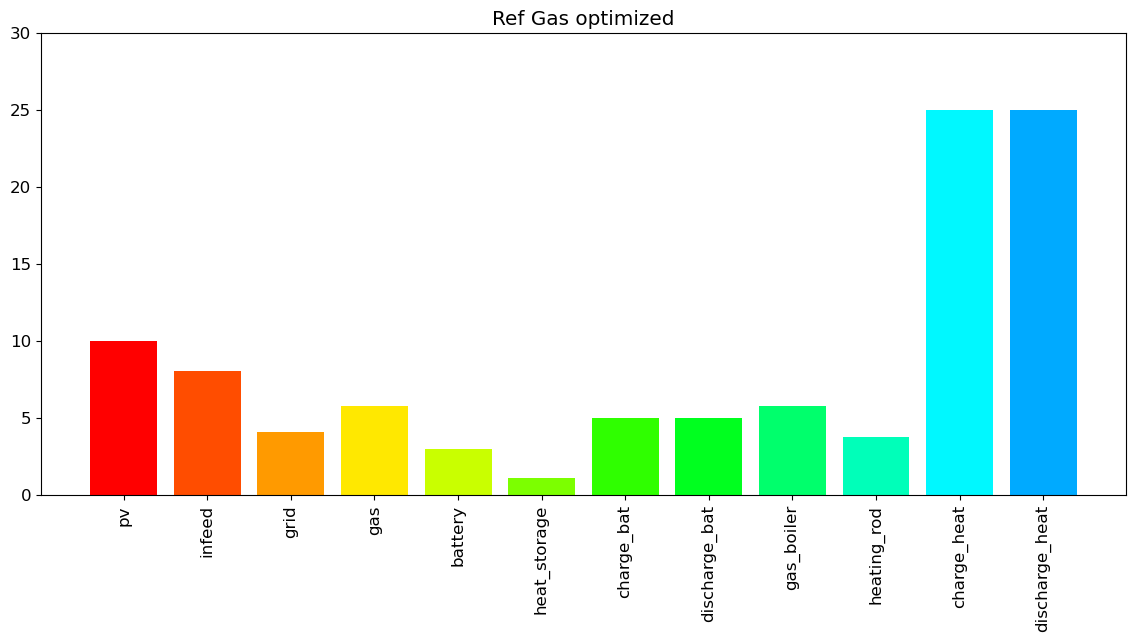

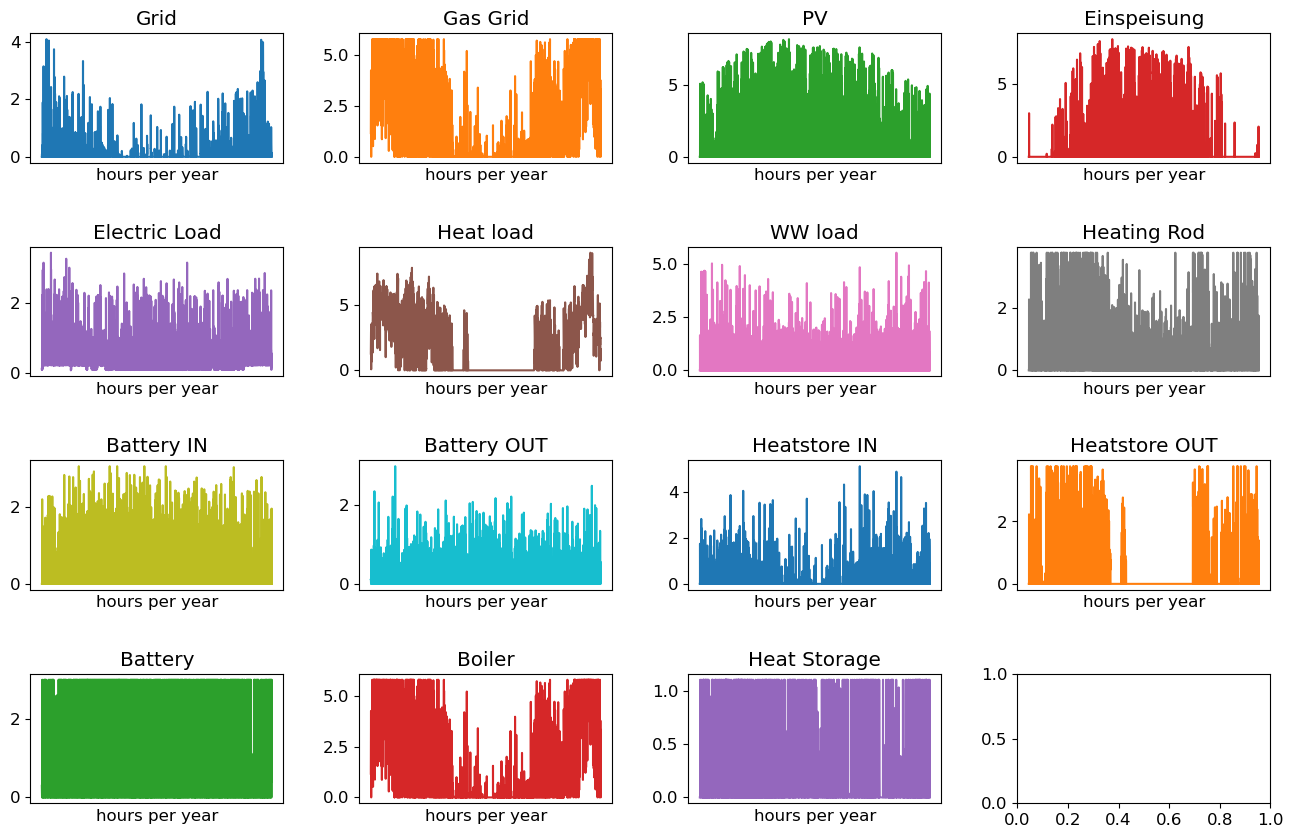

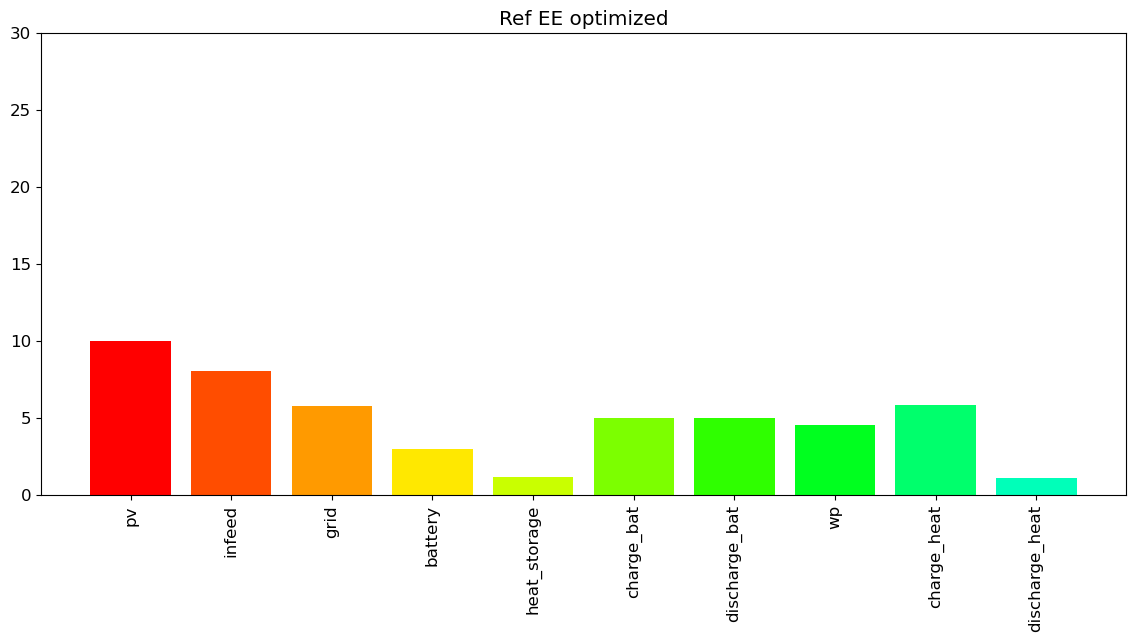

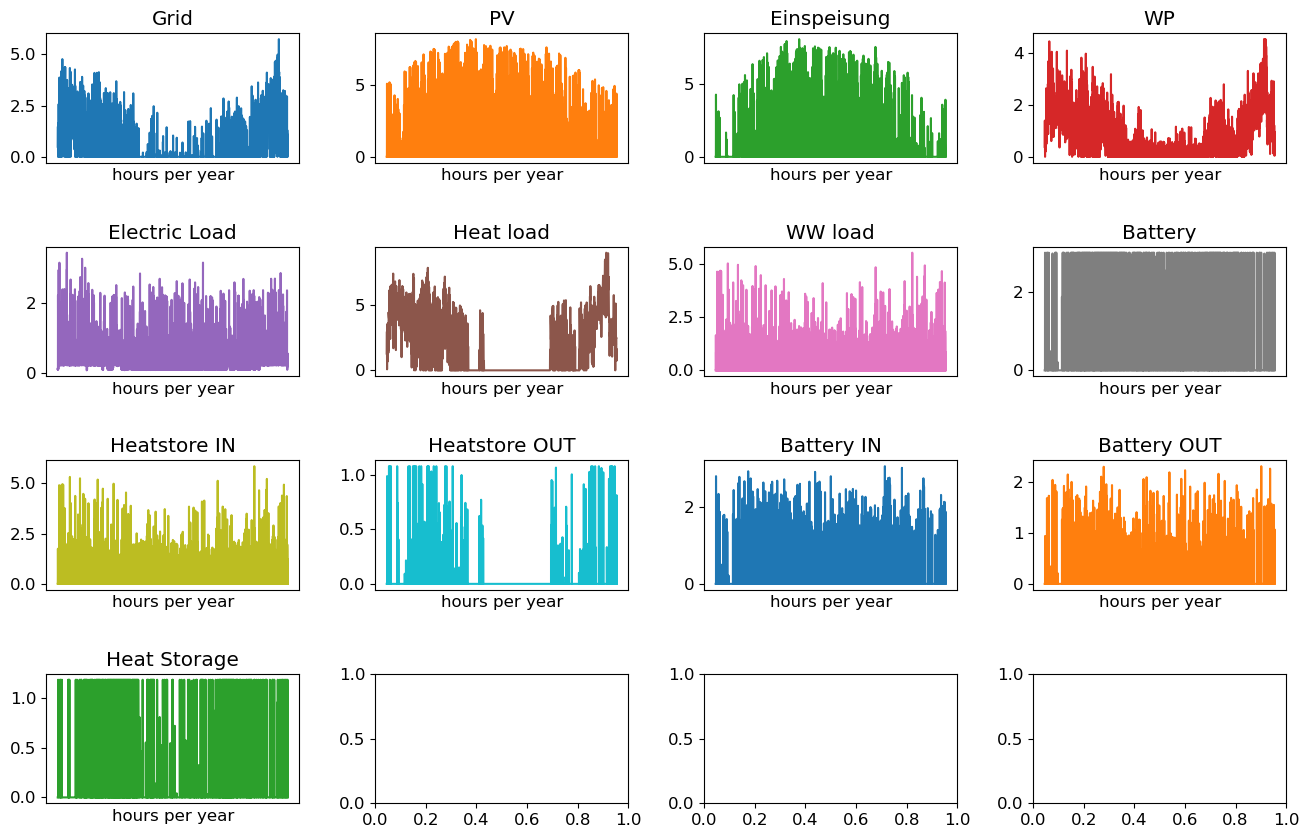

In [22]:
# setup reference networks and optimize
reference_gas = build_ref_network_gas(eload4, hload4, wwload4)
reference_ee = build_ref_network_ee(eload4, hload4, wwload4)
reference_gas.optimize(solver_name='gurobi')
reference_ee.optimize(solver_name='gurobi')
p_nom_opt_gas_boiler = reference_gas.links.p_nom_opt.gas_boiler
p_nom_opt_wp = reference_ee.links.p_nom_opt.wp
print("!----------------------------references set up------------------------------!")

ref_res_gas = result_summary_single_network(reference_gas, ref_gas=True, plots=True)
ref_res_ee = result_summary_single_network(reference_ee, ref=True, plots=True)
print("!----------------------------results summarized------------------------------!")

### Sensitivität 1

#### Sensitivität 1a
Ausgehend von 3 Szenarien für die Reduktion der Kapitalkosten von Wasserstoffsystemen soll bestimmt werden ab wann und zu welchem Investitionspreis ein kombiniertes Speicher- und Versorgungsystem mit Wasserstoff gegenüber derzeit verwendeter Energiebereitstellungssysteme in Eigenheimen kostenseitig attraktiv wird. Dem Szenario wird ein 4 Personenhaushalt mit entsprechenden Lastprofilen zugrunde gelegt.

**Kostenszenarien: Die Kapitalkosten für ein System verringern sich bis 2050 auf...**
> *Bei einem angenommenem Systempreis von 85000€ [https://www.homepowersolutions.de/produkt/] unter der Annahme, dass sich die Kosten für die Einzelkomponenten gleichmäßig auf die 4 Hauptkomponenten Elektrolyseur, Brennstoffzelle, integrierter Batteriespeicher und Wasserstoffspeicher aufteilen.
- max: ~70% der aktuellen Kosten
- std: ~46% der aktuellen Kosten
- min: ~28% der aktuellen Kosten

Durchgeführt wird eine Dimensionierung der Bestandskomponenten(Gasheizung(Boiler), Wärmepumpe) für ein Eigenheim...:
-  mit PV, Batteriespeicher und Gasheizung
-  mit PV, Batteriespeicher und Wärmepumpe

</br>Die Dimensionierung der Bestandskomponenten werden den jeweiligen H2-Netzwerken übergeben und für jedes Kostenszenario mit einem 5 jahres Interval eine Optimierung durchgeführt.

##### Die konkrete Frage zu dieser Sensitivitätsanalyse lautet:
Welche Kostenreduktion muss ein Wasserstoff-Heimsystem erfahren, um für die Anwendung im Eigenheim attraktiv zu werden und wann (kurzfristig < 2 Jahre, mittelfristig < 10 Jahre, langfristig > 10 Jahre) ist damit zu rechnen?
> **Notwendige Bedingung:** alle 4 Komponenten müssen eine optimierte Leistung oder Kapazität aufweisen

#### Sensitivität 1b

In [23]:
# sensitivity scenario 1a
# Setup time intervall and cost data
s1_periods = [i for i in range(2023, 2044, 5)]
df_cost = cost_reduction_calculation(capital_cost_picea)
df_cost.drop(df_cost.tail(3).index, inplace=True)
df_cost['year'] = range(2023, 2051, 1)
df_cost = df_cost[df_cost['year'].isin(s1_periods)]


# setup h2 networks
s1a_networks_gas = {}
s1a_networks_ee = {}

# do for cost_scenario='min' first. if threre are no positive results: we have an answer!
for year in df_cost['year']:
    s1a_networks_gas[year] = build_h2_network_gas_m(eload4, hload4, wwload4,
                                                    multi_invest_h2g=False,
                                                    cost_data = df_cost,
                                                    cost_scenario='min', 
                                                    init_build_year=year)
    s1a_networks_gas[year].links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
    s1a_networks_gas[year].links.loc['gas_boiler', 'p_nom_extendable'] = False
    s1a_networks_ee[year] = build_h2_network_ee_m(eload4, hload4, wwload4,
                                                  multi_invest_h2=False,
                                                  cost_data = df_cost,
                                                  cost_scenario='min', 
                                                  init_build_year=year)
    s1a_networks_ee[year].links.loc['wp', 'p_nom'] = p_nom_opt_wp
    s1a_networks_ee[year].links.loc['wp', 'p_nom_extendable'] = False

print("!----------------------------networks initialized------------------------------!")
# generate results
s1a_res_gas = {}
s1a_res_ee = {}
s1a_current_cost = pd.DataFrame(index=s1_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
for year in s1_periods:
    print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, 'min'])
    s1a_networks_gas[year].optimize(solver_name='gurobi')
    s1a_res_gas[year] = result_summary_single_network(s1a_networks_gas[year], h2_gas=True)
    print("Gas Network interim Result for {}: \n\n".format(year), s1a_res_gas[year][2])
    s1a_networks_ee[year].optimize(solver_name='gurobi')
    s1a_res_ee[year] = result_summary_single_network(s1a_networks_ee[year], h2=True)
    print("EE Network interim Result for {}: \n\n".format(year), s1a_res_ee[year][2])
    
    s1a_current_cost.loc[year] = [s1a_networks_ee[year].stores.capital_cost.battery,
                                  s1a_networks_ee[year].stores.capital_cost.h2_storage,
                                  s1a_networks_ee[year].links.capital_cost.ely,
                                  s1a_networks_ee[year].links.capital_cost.fc]
    
print("!----------------------------results generated------------------------------!")
# results scenario 1
df_s1a_gas = pd.DataFrame(index=s1_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s1a_ee = pd.DataFrame(index=s1_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for key, val in s1a_res_gas.items():
    df_s1a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                          val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for key, val in s1a_res_ee.items():
    df_s1a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                         val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s1a_gas = pd.concat([df_s1a_gas, s1a_current_cost.round(decimals=0)], axis=1)
df_s1a_ee = pd.concat([df_s1a_ee, s1a_current_cost.round(decimals=0)], axis=1)

print("!----------------------------results scenario 1:------------------------------!")
print(df_s1a_gas, "\n\n",  df_s1a_ee)
#print(s1a_res_gas, "\n\n", s1a_res_ee)

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2028
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2028
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2033
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2033
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2038
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2038
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2043
Settings: 
 Multi-Invest ON?:  False 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.71it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-uuzfqe9r.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0xa7b2b832
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.25s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -8.14e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.48it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-r0i96mur.lp
Reading time = 0.47 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xf5a27656
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.22s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.82e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.68it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-sqmb99fa.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0xe32f79b0
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.24s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -4.87e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.38it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-xnf3ubvj.lp
Reading time = 0.52 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x84a4910c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.23s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.47e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.94it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-7wb9z1zg.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x6f883684
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.23s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -2.51e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.14it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-de13dvfd.lp
Reading time = 0.47 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x25ac0a49
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.76e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.43it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-g0rc_ech.lp
Reading time = 0.56 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x5dedd217
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.25s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -2.38e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 26.99it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-vk2f7obq.lp
Reading time = 0.47 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5f100b97
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.67e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.57it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-pavuesno.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x23670191
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.24s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -2.28e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-7naif541.lp
Reading time = 0.58 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd0be28d4
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.27s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.60e+04
Solver model: available
Solver message: 2



!----------------------------results generated------------------------------!
!----------------------------results scenario 1:------------------------------!
     battery [kWh] h2_storage [kWh] ely [kW] fc [kW] cost_bat [€/kWh]  \
2023           0.0              0.0      0.0     0.0       280.895009   
2028           0.0              0.0      0.0     0.0       172.903925   
2033          1.85              0.0      0.0     0.0        94.587095   
2038          1.98              0.0      0.0     0.0        90.453852   
2043          2.14              0.0      0.0     0.0         86.89369   

     cost_h2_storage [€/kWh] cost_ely [€/kW] cost_fc [€/kW]  
2023               36.432083    16416.583103   15605.278256  
2028               22.425639    10105.169418    9605.773601  
2033               12.267946     5528.033086    5254.838596  
2038               11.731865     5286.470503    5025.213997  
2043               11.270112     5078.400949    4827.427207   

      battery [kWh] h2_storag

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
!----------------------------networks initialized------------------------------!


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.48it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-henivae_.lp
Reading time = 0.47 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd0be28d4
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.60e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  3057.78
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      3658.11
Amount Infeed [kWh/a]                7066.71
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                7045.58
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]                519.89
Heat Storage stored [kWh/a]          2616.43
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   70.52
CAPEX [€]                           24996.41
OPEX [€/a]                           2818.23
Revenue Infeed [€/a]                 -501.74
Revenue Savings [€/a]               -1463.24
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 26.83it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-es86hnp2.lp
Reading time = 0.48 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x97d2e1f7
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 3e+03]
  Bounds range     [1e+04, 1e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -9.99e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2892.44
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      4031.75
Amount Infeed [kWh/a]                6693.07
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                6664.61
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]                962.50
Heat Storage stored [kWh/a]          2482.96
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   72.12
CAPEX [€]                           25053.70
OPEX [€/a]                           2665.84
Revenue Infeed [€/a]                 -475.21
Revenue Savings [€/a]               -1612.70
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 26.00it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-w64ma3t0.lp
Reading time = 0.52 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xfbc6ca48
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [7e+03, 7e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.23s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -4.09e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2555.14
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      4807.46
Amount Infeed [kWh/a]                5917.36
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                5887.42
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]               1836.78
Heat Storage stored [kWh/a]          2240.03
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   75.37
CAPEX [€]                           25150.88
OPEX [€/a]                           2354.97
Revenue Infeed [€/a]                 -420.13
Revenue Savings [€/a]               -1922.98
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.77it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-8dky0rn3.lp
Reading time = 0.47 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xcb48344c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+02]
  Bounds range     [8e+02, 8e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s


       0 DPushes remaining with DInf 0.0000000e+00                 8s

     435 PPushes remaining with PInf 0.0000000e+00                 8s
       0 PPushes remaining with PInf 0.0000000e+00                 8s

  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8086483e-13      8s


Solved with barrier
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   20100    1.5299419e+03   0.000000e+00   0.000000e+00      8s

Solved in 20100 iterations and 7.76 seconds (3.97 work units)
Optimal objective  1.529941945e+03


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 1.53e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2274.82
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      5448.65
Amount Infeed [kWh/a]                5276.17
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                5241.52
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]               2584.42
Heat Storage stored [kWh/a]          1949.38
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   78.07
CAPEX [€]                           24933.32
OPEX [€/a]                           2096.61
Revenue Infeed [€/a]                 -374.61
Revenue Savings [€/a]               -2179.46
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 25.05it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-u81q34tm.lp
Reading time = 0.57 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x23670191
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.24s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -2.28e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  3911.54
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      5114.10
Amount Infeed [kWh/a]                5610.72
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                1391.03
Grid gas [kWh/a]                    16375.41
Ratio electric [%]                      7.83
Ratio gas [%]                          92.17
Battery stored [kWh/a]                785.02
Heat Storage stored [kWh/a]           950.11
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   25.67
CAPEX [€]                           19605.99
OPEX [€/a]                           3143.73
Revenue Infeed [€/a]                 -398.36
Revenue Savings [€/a]               -2045.64
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.38it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-a_2fn9mm.lp
Reading time = 0.90 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x96441a5a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 3e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.27s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -1.44e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  3787.48
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      5354.10
Amount Infeed [kWh/a]                5370.72
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                1083.25
Grid gas [kWh/a]                    16422.55
Ratio electric [%]                      6.19
Ratio gas [%]                          93.81
Battery stored [kWh/a]               1190.86
Heat Storage stored [kWh/a]           935.48
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   26.76
CAPEX [€]                           19626.74
OPEX [€/a]                           3028.06
Revenue Infeed [€/a]                 -381.32
Revenue Savings [€/a]               -2141.64
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-9lxg1nph.lp
Reading time = 0.57 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x93be94ca
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [9e+03, 9e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.23s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: -6.13e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  3661.46
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      5627.32
Amount Infeed [kWh/a]                5097.50
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                 797.11
Grid gas [kWh/a]                    16413.45
Ratio electric [%]                      4.63
Ratio gas [%]                          95.37
Battery stored [kWh/a]               1684.44
Heat Storage stored [kWh/a]           874.42
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   28.00
CAPEX [€]                           19596.85
OPEX [€/a]                           2912.17
Revenue Infeed [€/a]                 -361.92
Revenue Savings [€/a]               -2250.93
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.43it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-lkc8hxcf.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x4c683c5e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+02]
  Bounds range     [1e+03, 1e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.23s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 2.01e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\1783566458.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  3372.04
PV generated [kWh/a]                10724.82
PV used [kWh/a]                      6642.96
Amount Infeed [kWh/a]                4081.86
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                 420.51
Grid gas [kWh/a]                    15789.79
Ratio electric [%]                      2.59
Ratio gas [%]                          97.41
Battery stored [kWh/a]               3236.30
Heat Storage stored [kWh/a]           528.82
H2 stored [kWh/a]                      -0.00
converted to H2 [kWh/a]                 0.00
H2 used [kWh/a]                         0.00
Heat from H2 [kWh/a]                   -0.00
Self Sufficiency [%]                   32.18
CAPEX [€]                           19496.67
OPEX [€/a]                           2662.99
Revenue Infeed [€/a]                 -289.81
Revenue Savings [€/a]               -2657.18
Payback Period [a]               

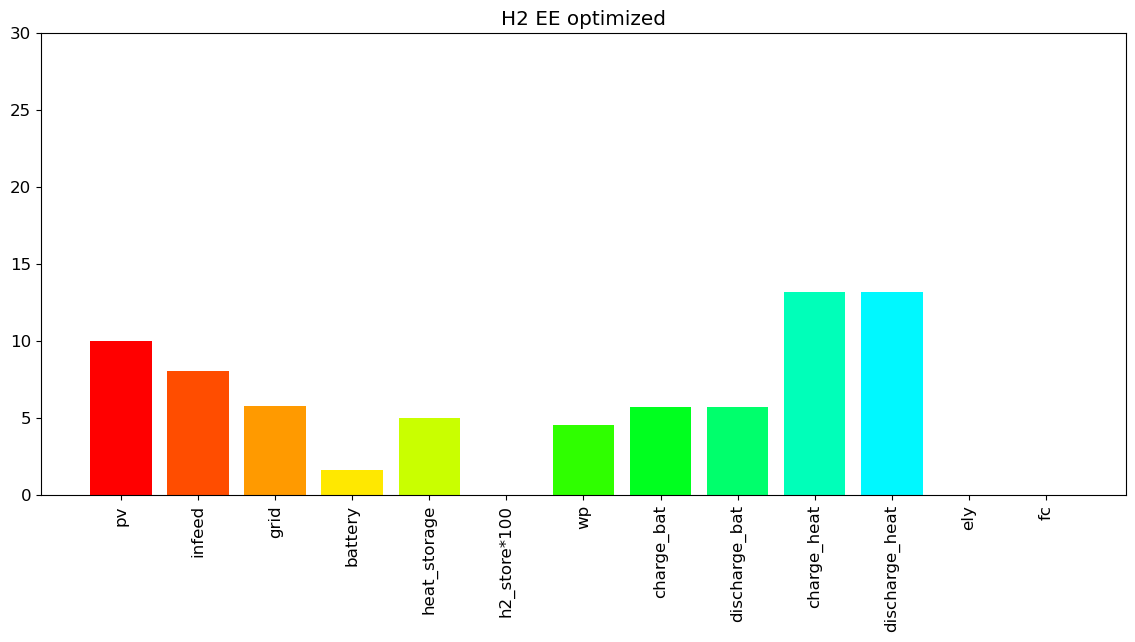

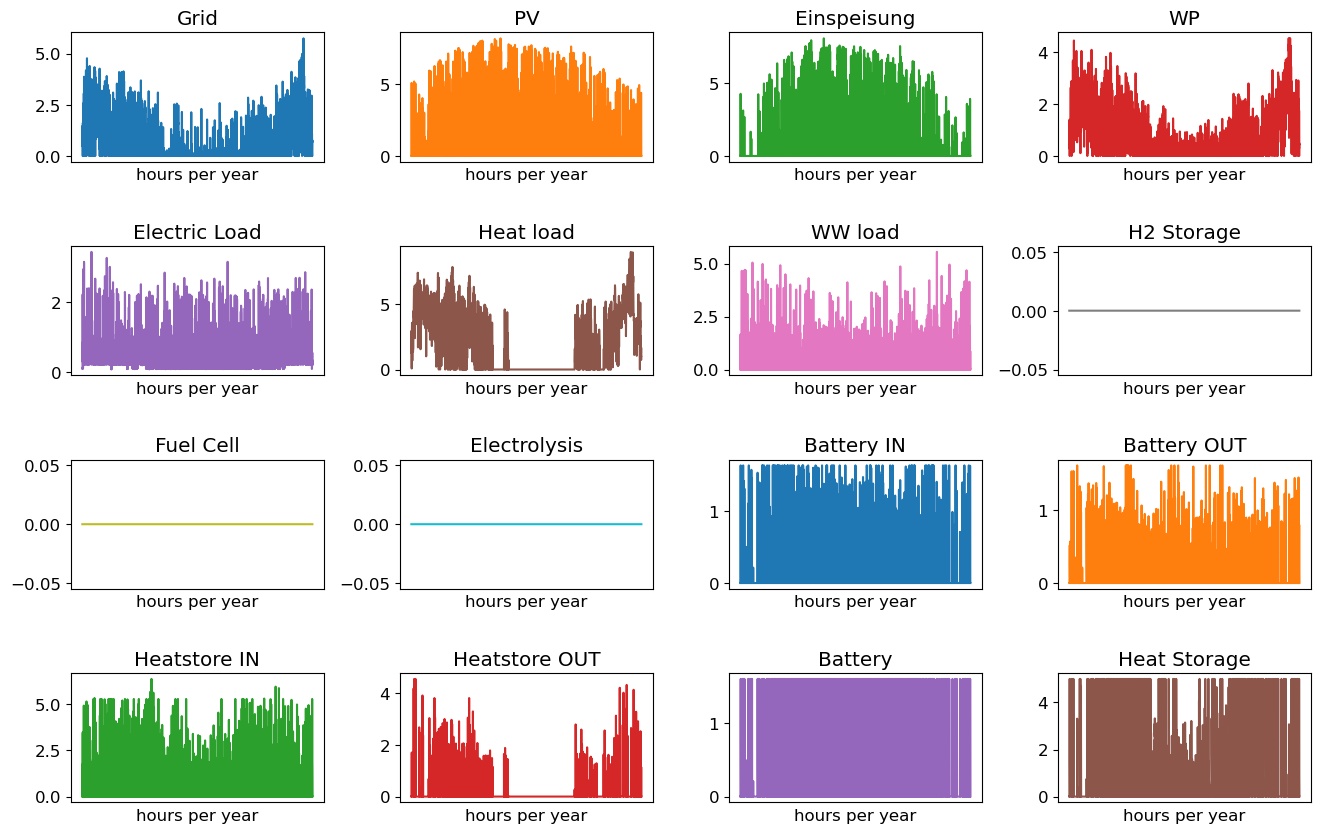

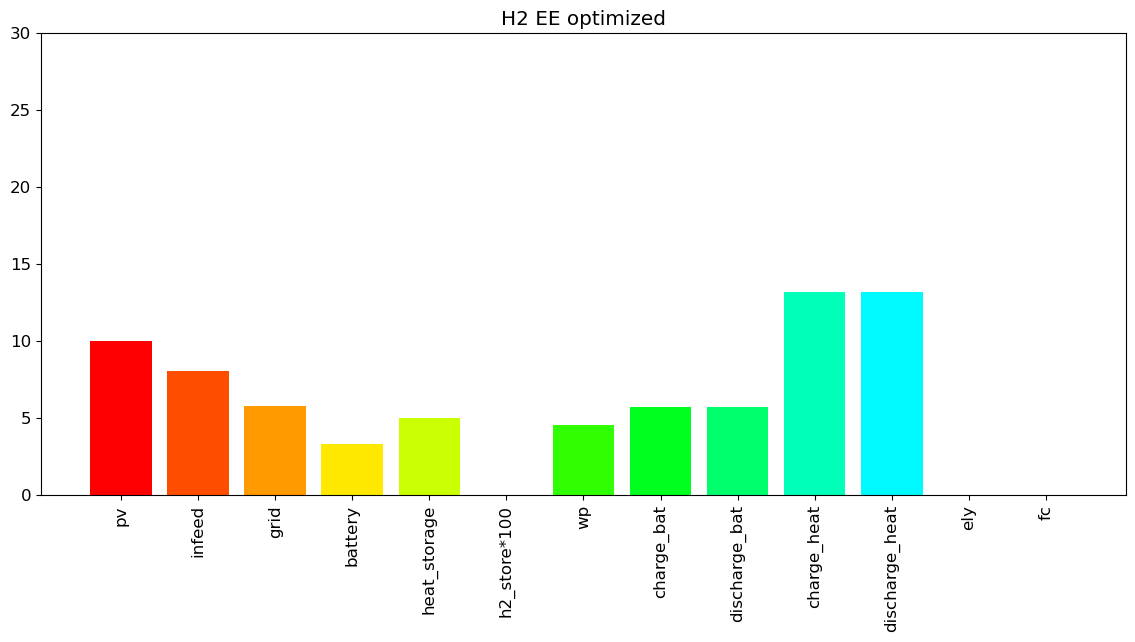

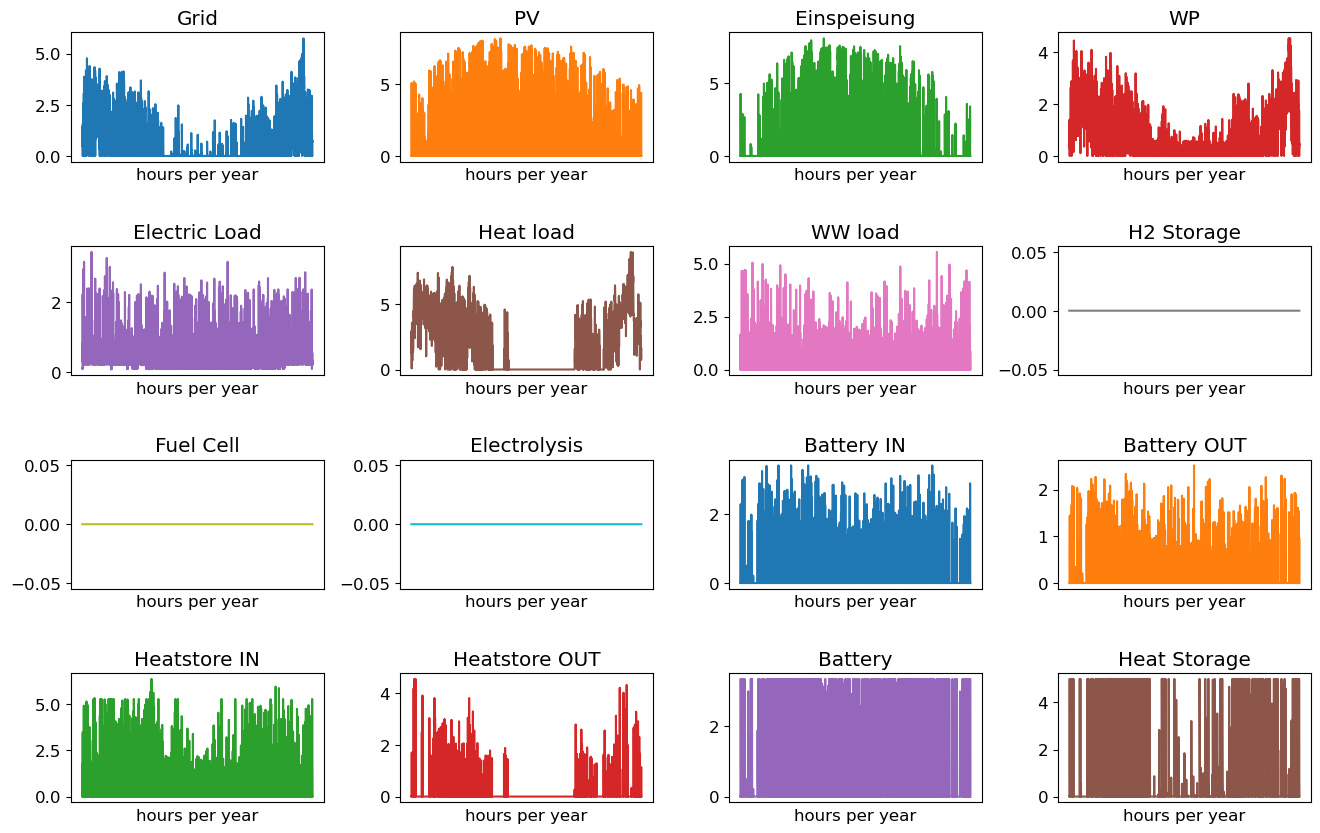

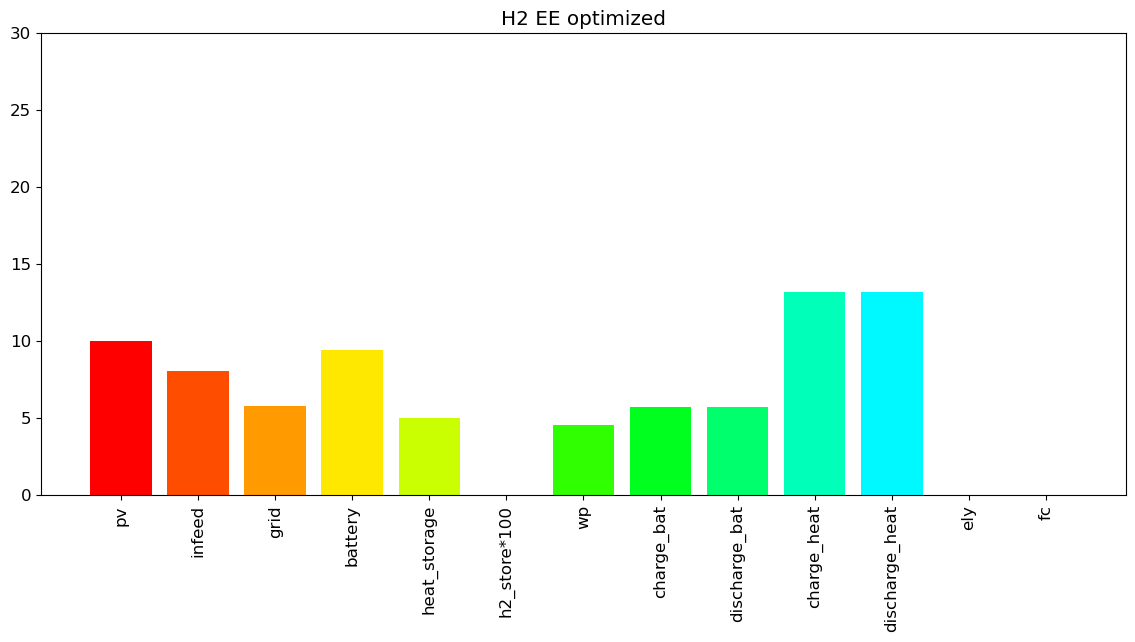

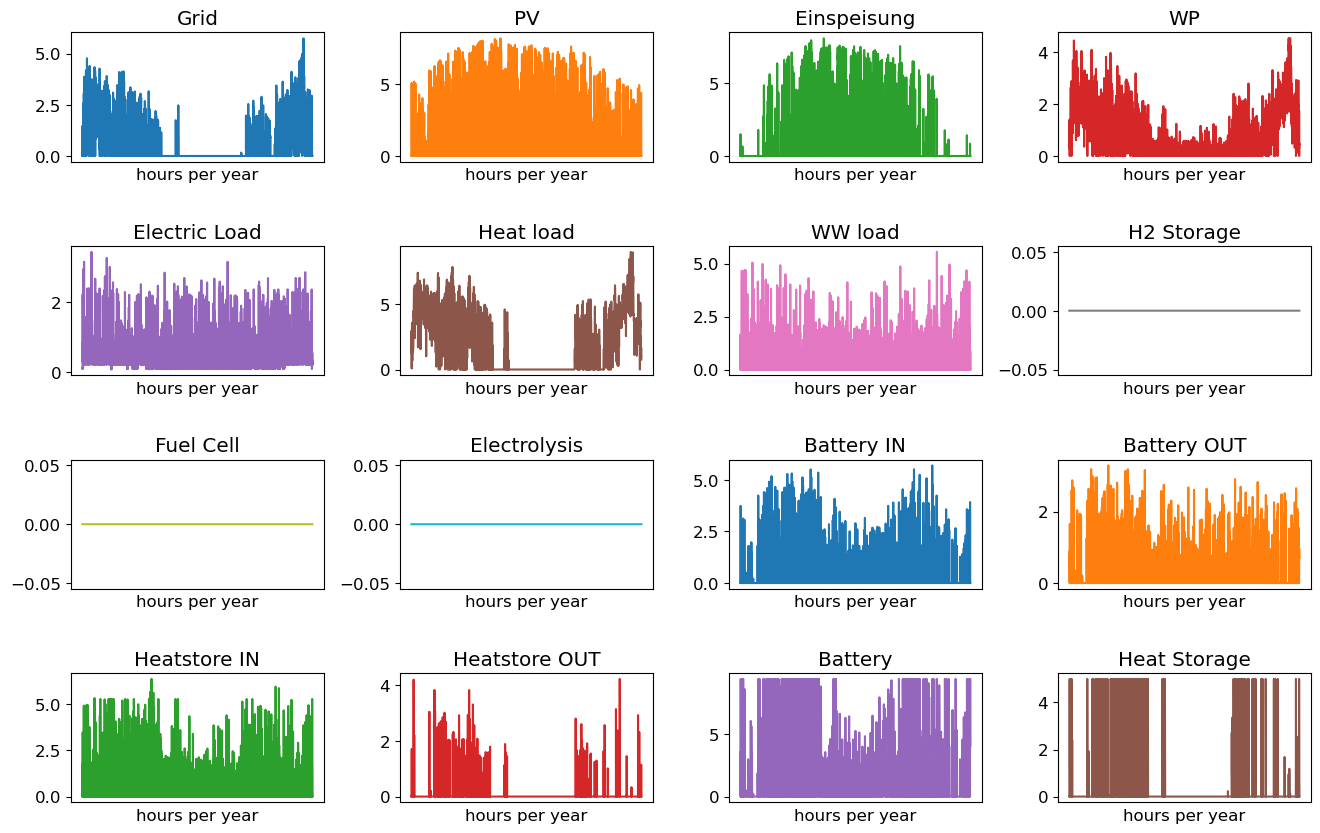

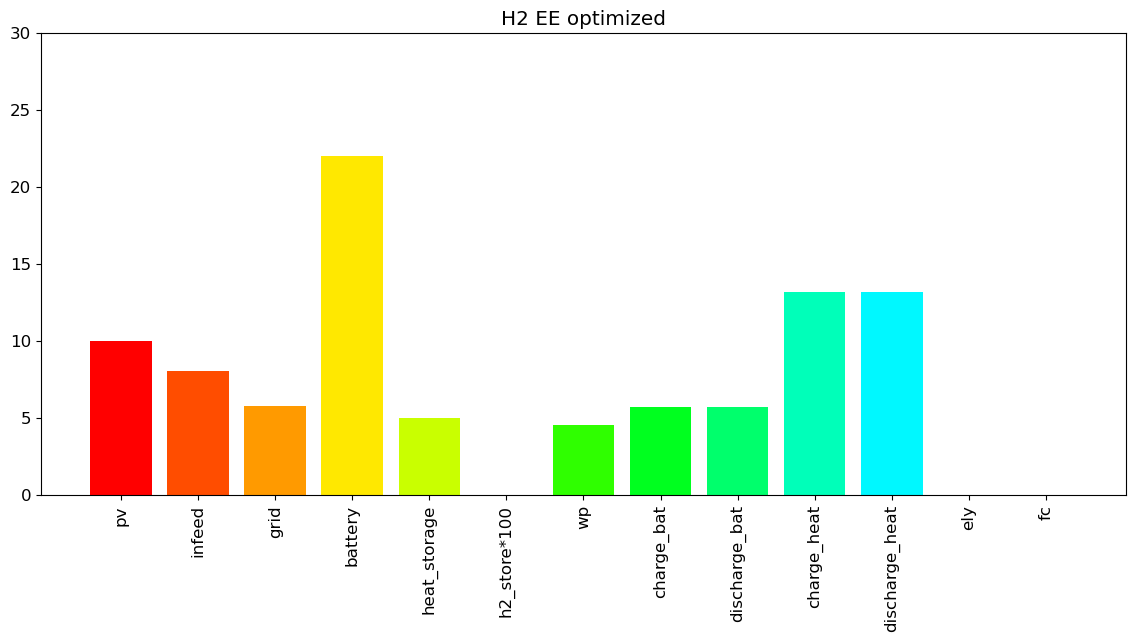

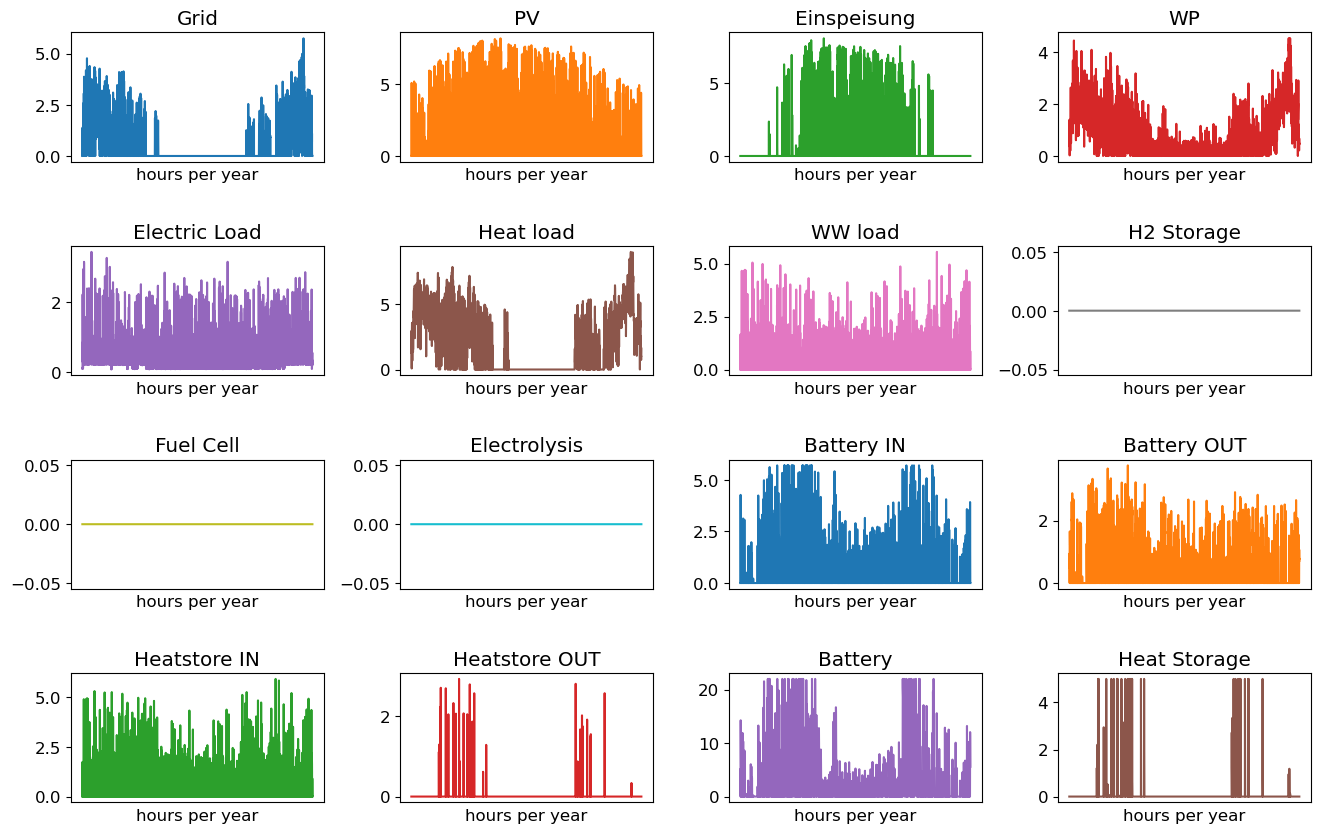

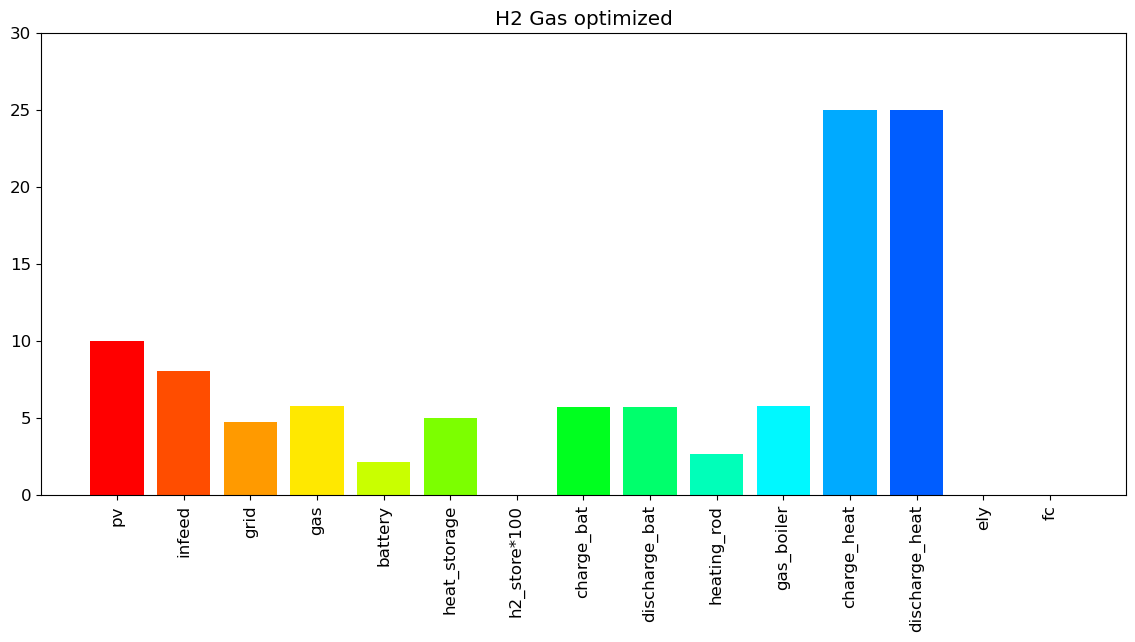

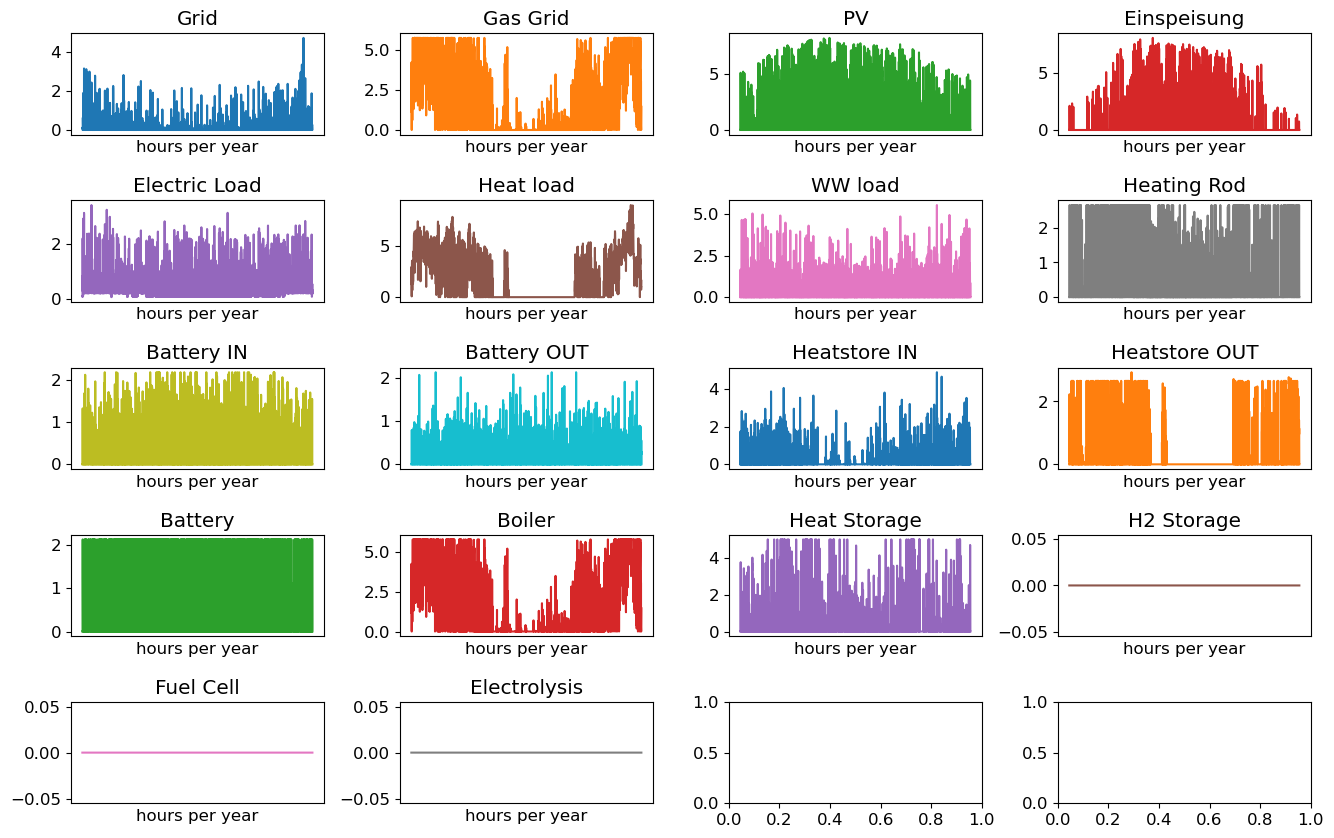

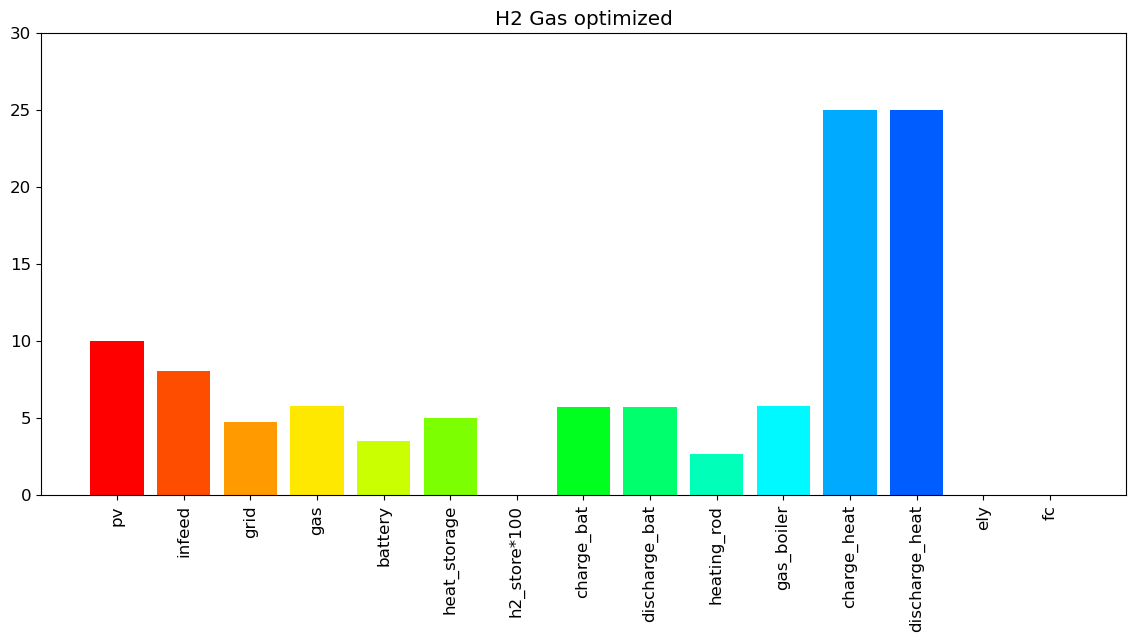

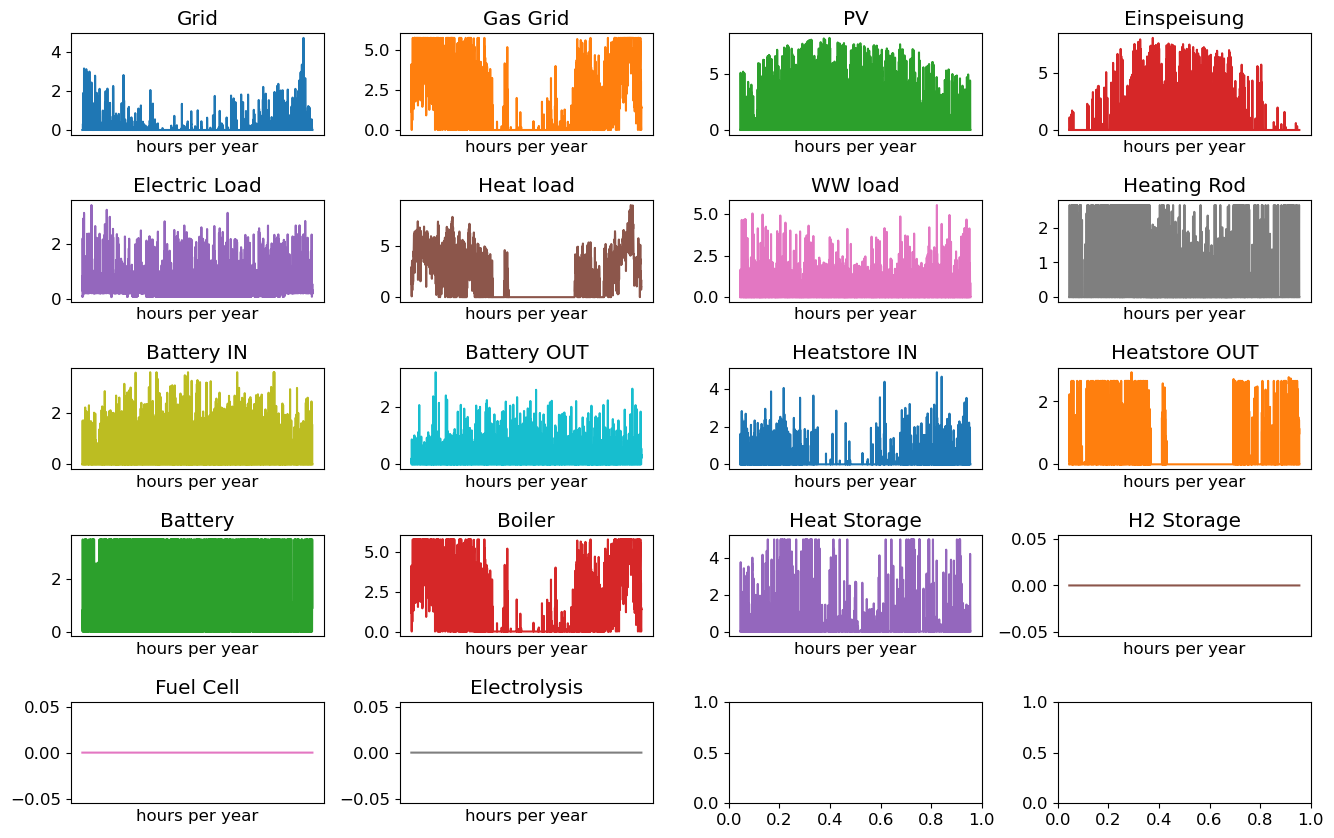

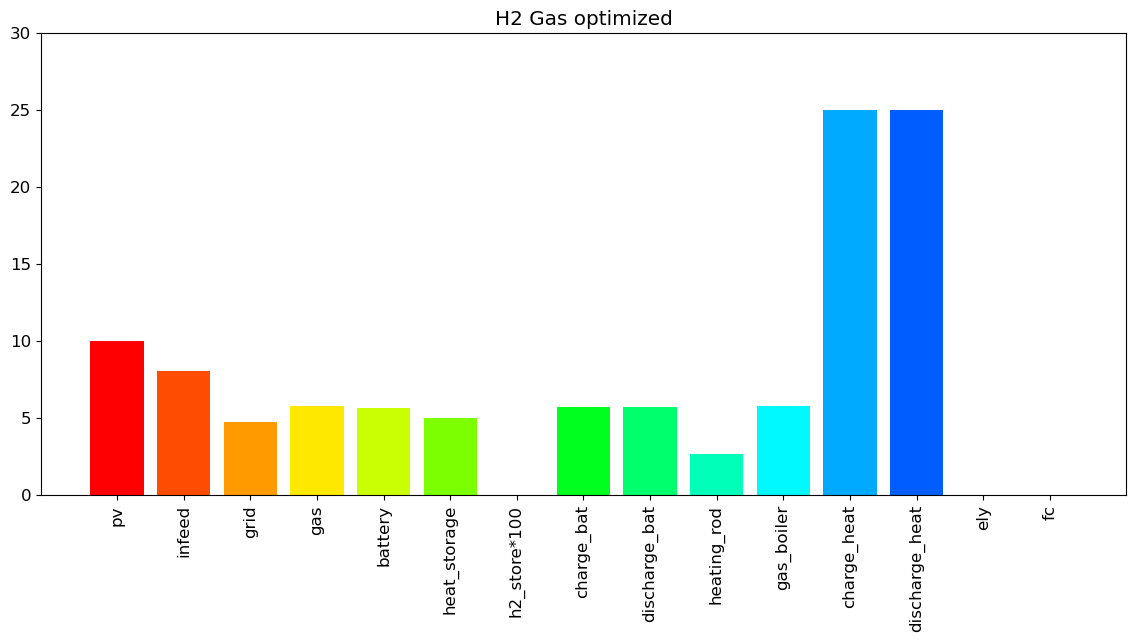

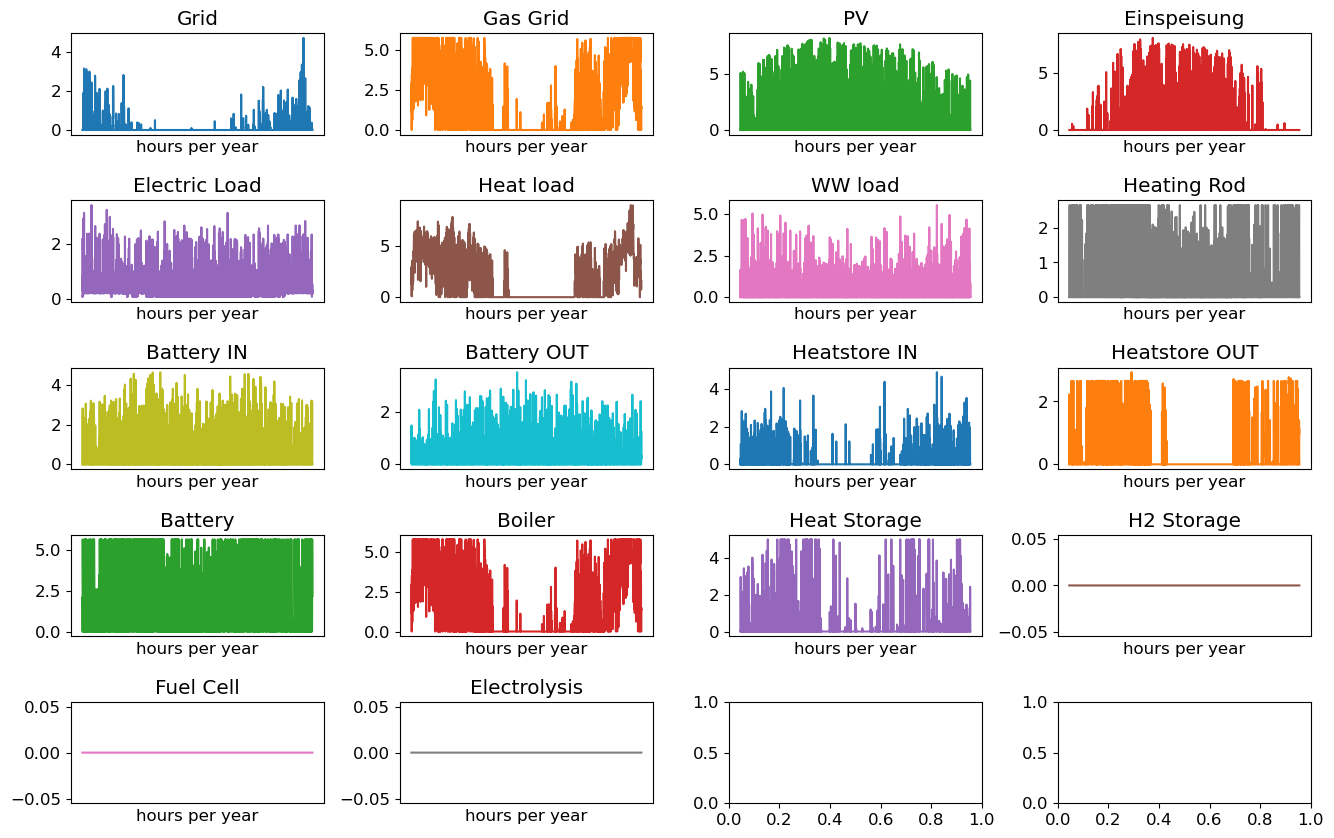

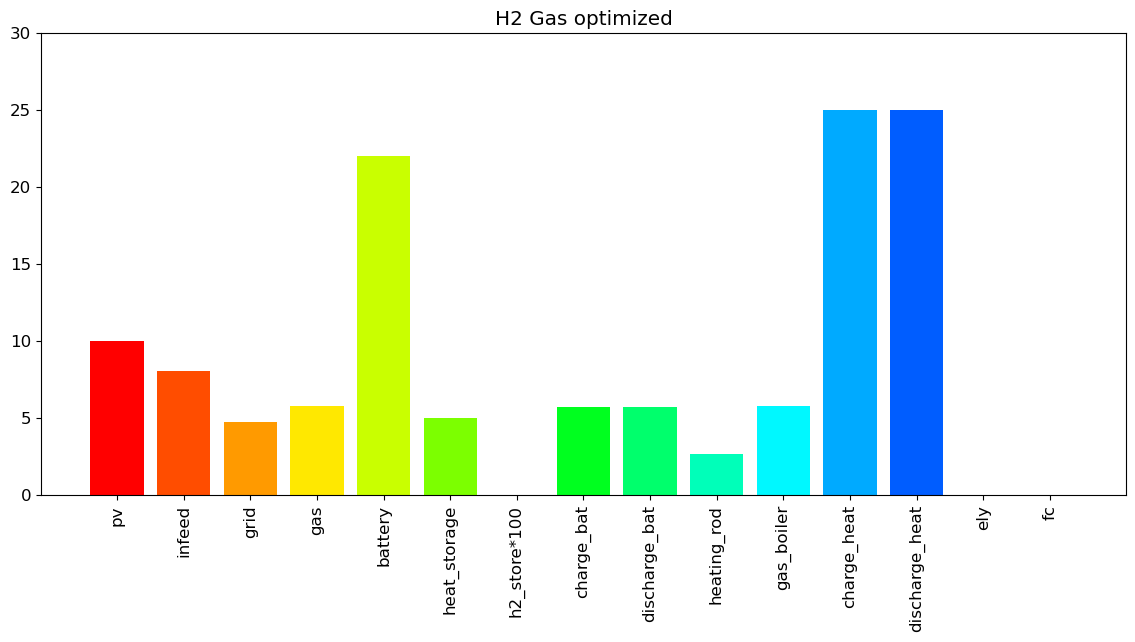

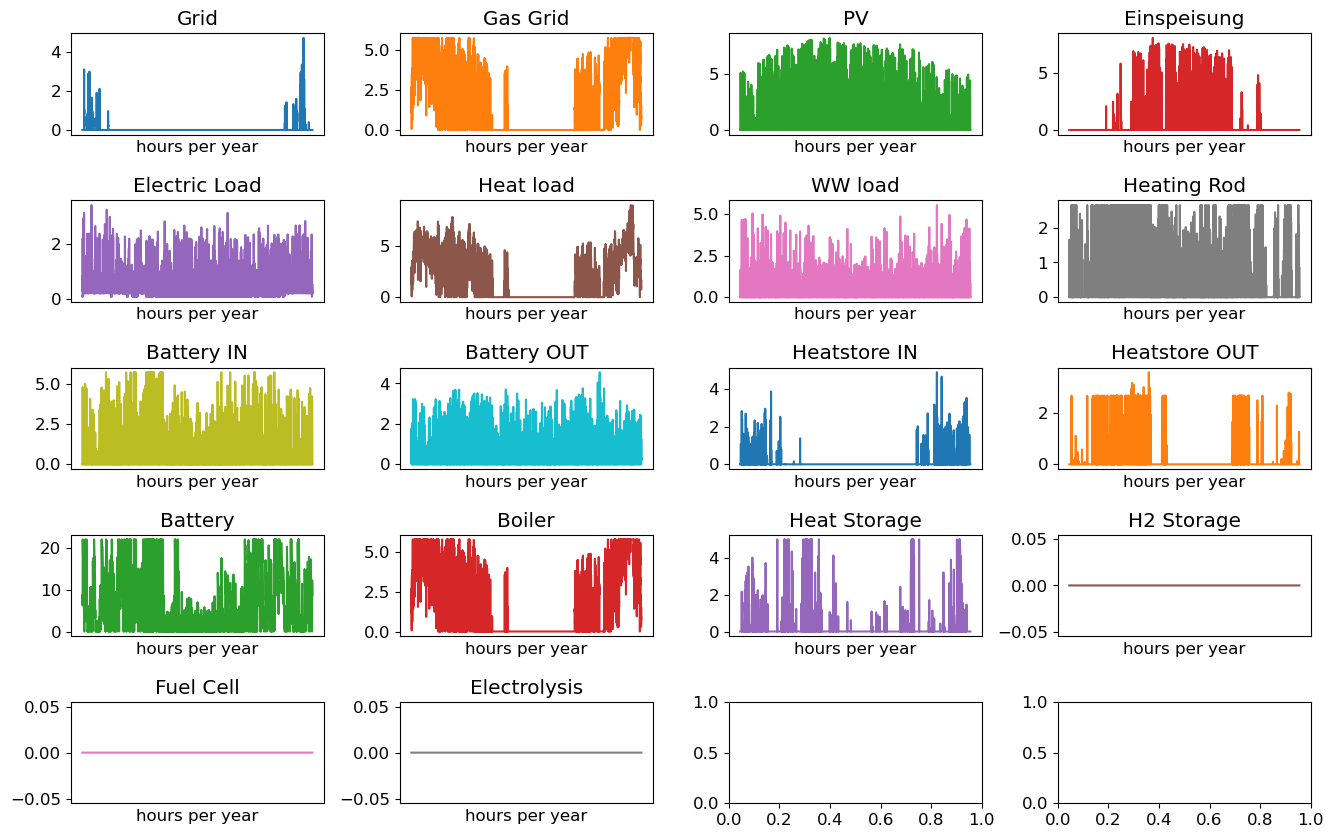

In [24]:
# sensitivity scenario 1b
s1b_mincap_h2_storage = df_cost['min'].min() * specific_cap_share['h2_storage'] / h2_storage_params['e_nom_min']
s1b_mincap_ely = df_cost['min'].min() * specific_cap_share['ely'] / ely_params['p_nom']
s1b_mincap_fc = df_cost['min'].min() * specific_cap_share['fc'] / fc_params['p_nom']
s1b_mincap_battery = df_cost['min'].min() * specific_cap_share['battery'] / battery_picea_params['e_nom']
s1b_cap_lst = [s1b_mincap_h2_storage, s1b_mincap_ely, s1b_mincap_fc, s1b_mincap_battery]

s1b_cost_lvl_gas = {}
s1b_cost_lvl_ee = {}


for i in np.arange(1, 0, -0.32):
    s1b_cost_lvl_gas[i] = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
    s1b_cost_lvl_gas[i].stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] * i
    s1b_cost_lvl_gas[i].links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] * i
    s1b_cost_lvl_gas[i].links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] * i
    s1b_cost_lvl_gas[i].stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] * i
    s1b_cost_lvl_gas[i].links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
    s1b_cost_lvl_gas[i].links.loc['gas_boiler', 'p_nom_extendable'] = False

    s1b_cost_lvl_ee[i] = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
    s1b_cost_lvl_ee[i].stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] * i
    s1b_cost_lvl_ee[i].links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] * i
    s1b_cost_lvl_ee[i].links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] * i
    s1b_cost_lvl_ee[i].stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] * i
    s1b_cost_lvl_ee[i].links.loc['wp', 'p_nom'] = p_nom_opt_wp
    s1b_cost_lvl_ee[i].links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

s1b_res_gas = pd.DataFrame()
s1b_res_ee = pd.DataFrame()
s1b_res_sum_gas = {}
s1b_res_sum_ee = {}
for key, val in s1b_cost_lvl_ee.items():
    print("Current Capital Cost H2-System EE-Network: ", sum(s1b_cap_lst) * key)
    s1b_cost_lvl_ee[key].optimize(solver_name='gurobi')
    s1b_res_ee = s1b_res_ee.append(result_summary_single_network(s1b_cost_lvl_ee[key], h2=True, sensitivity_variable=key))
    s1b_res_sum_ee[key] = result_summary_single_network(s1b_cost_lvl_ee[key], h2=True, plots=True)
for key, val in s1b_cost_lvl_gas.items():
    print("Current Capital Cost H2-System Gas-Network: ", sum(s1b_cap_lst) * key)
    s1b_cost_lvl_gas[key].optimize(solver_name='gurobi')
    s1b_res_gas = s1b_res_gas.append(result_summary_single_network(s1b_cost_lvl_gas[key], h2_gas=True, sensitivity_variable=key))
    s1b_res_sum_gas[key] = result_summary_single_network(s1b_cost_lvl_gas[key], h2_gas=True, plots=True)
print("!----------------------------results generated------------------------------!")

print(s1b_res_sum_ee, "\n\n", s1b_res_sum_gas)
print(s1b_res_ee, "\n\n", s1b_res_gas)

### Sensitivität 2

#### Sensitivität 2a
#### Sensitivität 2b

In [25]:
# sensitivity scenario 2a - CO2-minimum H2-Gas-model
# DataFrame for sensitivity results
df_s2a_res_gas = pd.DataFrame()

# Setup H2-Gas Network with minimum design properties for hydrogen Network but with extendable components
s2a_gas_network = build_h2_network_gas(eload4, hload4, wwload4)
s2a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler # set gas_boiler power from reference network 
s2a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False # set gas_boiler not extendable
print("!----------------------------network initialized------------------------------!")

# optimize for base CO2-value
s2a_gas_network.optimize(solver_name='gurobi')
s2a_base_res_gas = result_summary_single_network(s2a_gas_network, h2_gas=True)
s2a_baseCO2_gas = s2a_base_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")

s2a_res_gas_sum = {}
# lowering CO2-Emissions for each run and append results
for co2_lim in np.arange(1, 0.79, -0.05):
    print('Current CO2: {}%:'.format(co2_lim*100), "\nCurrent CO2 Value [kg/a]: ", co2_lim * s2a_baseCO2_gas)
    s2a_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * s2a_baseCO2_gas
    s2a_gas_network.optimize(solver_name='gurobi')
    df_s2a_res_gas = df_s2a_res_gas.append(result_summary_single_network(s2a_gas_network, h2_gas=True, sensitivity_variable=co2_lim))
    s2a_res_gas_sum[co2_lim] = result_summary_single_network(s2a_gas_network, h2_gas=True)
print("!----------------------------results scenario 2a:------------------------------!")
df_s2a_res_gas

!----------------------------network initialized------------------------------!


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.59it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-p4sn4ns_.lp
Reading time = 0.60 seconds
obj: 350416 rows, 157691 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157691 columns and 680366 nonzeros
Model fingerprint: 0x93e70556
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259183 rows and 48932 columns
Presolve time: 0.27s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157691 primals, 350416 duals
Objective: 8.78e+04
Solver model: available
Solver message: 2



!----------------------------base CO2 calculated------------------------------!
Current CO2: 100.0%: 
Current CO2 Value [kg/a]:  3153.26


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.65it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-rbdlyxyd.lp
Reading time = 0.56 seconds
obj: 350416 rows, 157691 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157691 columns and 680366 nonzeros
Model fingerprint: 0x19c00d41
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48932 columns
Presolve time: 0.25s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

  95   8.78350879e+04  8.77969042e+04  1.55e-02 3.06e-16  1.57e-04    10s
  96   8.78345124e+04  8.77978469e+04  1.40e-02 3.30e-16  1.51e-04    10s
  97   8.78338649e+04  8.77989407e+04  1.27e-02 2.92e-16  1.44e-04    10s
  98   8.78338414e+04  8.78000427e+04  1.26e-02 1.55e-14  1.39e-04    10s
  99   8.78323195e+04  8.78005500e+04  1.05e-02 3.28e-14  1.31e-04    10s
 100   8.78319890e+04  8.78011084e+04  9.75e-03 9.83e-14  1.27e-04    10s
 101   8.78313802e+04  8.78022729e+04  9.23e-03 2.35e-16  1.20e-04    10s
 102   8.78308633e+04  8.78037926e+04  8.41e-03 5.12e-14  1.11e-04    10s
 103   8.78298364e+04  8.78048332e+04  7.53e-03 5.24e-16  1.03e-04    10s
 104   8.78293874e+04  8.78057995e+04  7.10e-03 3.18e-16  9.71e-05    10s
 105   8.78289495e+04  8.78072600e+04  6.45e-03 3.64e-16  8.92e-05    11s
 106   8.78284343e+04  8.78079881e+04  6.10e-03 5.78e-14  8.41e-05    11s
 107   8.78279879e+04  8.78084783e+04  5.39e-03 4.96e-16  8.03e-05    11s
 108   8.78275816e+04  8.78092898e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157691 primals, 350416 duals
Objective: 8.78e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2671842156.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 95.0%: 
Current CO2 Value [kg/a]:  2995.597


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-bovr3jo8.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157691 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157691 columns and 680366 nonzeros
Model fingerprint: 0x757a3370
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48932 columns
Presolve time: 0.25s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157691 primals, 350416 duals
Objective: 1.14e+05
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2671842156.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 89.99999999999999%: 
Current CO2 Value [kg/a]:  2837.9339999999997


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 18.63it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-5na__1i6.lp
Reading time = 0.56 seconds
obj: 350416 rows, 157691 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157691 columns and 680366 nonzeros
Model fingerprint: 0x72a4af6a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48932 columns
Presolve time: 0.24s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157691 primals, 350416 duals
Objective: 1.49e+05
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2671842156.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 84.99999999999999%: 
Current CO2 Value [kg/a]:  2680.2709999999997


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 19.43it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-d72f7hed.lp
Reading time = 0.59 seconds
obj: 350416 rows, 157691 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157691 columns and 680366 nonzeros
Model fingerprint: 0x292ae21b
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48932 columns
Presolve time: 0.29s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



Current CO2: 79.99999999999999%: 
Current CO2 Value [kg/a]:  2522.6079999999997


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2671842156.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-hyn2_zgm.lp
Reading time = 0.54 seconds
obj: 350416 rows, 157691 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157691 columns and 680366 nonzeros
Model fingerprint: 0xfd52c217
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48932 columns
Presolve time: 0.27s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



!----------------------------results scenario 2a:------------------------------!


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2671842156.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
1.00              3153.26              10724.82          7588.69   
0.95              2995.60              10724.82          8571.26   
0.90              2837.93              10724.82          9907.36   
0.85              2837.93              10724.82          9907.36   
0.80              2837.93              10724.82          9907.36   

      Amount Infeed [kWh/a]  Load Total [kWh/a]  Grid electric [kWh/a]  \
1.00                3136.13            23901.99                  46.51   
0.95                2153.56            23901.99                  16.90   
0.90                 817.46            23901.99                  16.44   
0.85                 817.46            23901.99                  16.44   
0.80                 817.46            23901.99                  16.44   

      Grid gas [kWh/a]  Ratio electric [%]  Ratio gas [%]  \
1.00          15510.25                0.30          99.70   
0.95          14793.37                0.11          99.89   
0.90          14013.85                0.12          99.88   
0.85          14013.85                0.12          99.88   
0.80          14013.85                0.12          99.88   

      Battery stored [kWh/a]  ...  H2 stored [kWh/a]  converted to H2 [kWh/a]  \
1.00                 3298.87  ...            1146.74                  1638.20   
0.95                 3736.81  ...            1637.46                  2339.23   
0.90                 3583.09  ...            2627.89                  3754.13   
0.85                 3583.09  ...            2627.89                  3754.13   
0.80                 3583.09  ...            2627.89                  3754.13   

      H2 used [kWh/a]  Heat from H2 [kWh/a]  Self Sufficiency [%]  CAPEX [€]  \
1.00          1127.90                666.01                 34.91  104380.58   
0.95          1592.74                945.67                 38.04  130142.28   
0.90          2548.36               1515.33                 41.30  165590.08   
0.85          2548.36               1515.33                 41.30  165590.08   
0.80          2548.36               1515.33                 41.30  165590.08   

      OPEX [€/a]  Revenue Infeed [€/a]  Revenue Savings [€/a]  \
1.00     2469.22               -222.67               -3035.48   
0.95     2344.11               -152.90               -3428.50   
0.90     2220.77                -58.04               -3962.94   
0.85     2220.77                -58.04               -3962.94   
0.80     2220.77                -58.04               -3962.94   

      Payback Period [a]  
1.00               47.19  
0.95               49.43  
0.90               52.23  
0.85               52.23  
0.80               52.23  

[5 rows x 21 columns]

In [27]:
# sensitivity scenario 2b - CO2-minimum H2-EE-model
# DataFrame for sensitivity results
df_s2b_res_ee = pd.DataFrame()

# Setup H2-EE Network with minimum design properties for hydrogen Network but with extendable components
s2b_ee_network = build_h2_network_ee(eload4, hload4, wwload4)
s2b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_gas_boiler # set heat-pump(wp) power from reference network 
s2b_ee_network.links.loc['wp', 'p_nom_extendable'] = False # set heat-pump(wp) not extendable
print("!----------------------------network initialized------------------------------!")

# optimize for base CO2-value
s2b_ee_network.optimize(solver_name='gurobi')
s2b_base_res_ee = result_summary_single_network(s2b_ee_network, h2=True)
s2b_baseCO2_ee = s2b_base_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")

s2b_res_ee_sum = {}
# lowering CO2-Emissions for each run and append results 
for co2_lim in np.arange(1, 0.49, -0.1):
    print('Current CO2: {}%:'.format(co2_lim*100), "\nCurrent CO2 Value [kg/a]: ", co2_lim * s2b_baseCO2_ee)
    s2b_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * s2b_baseCO2_ee
    s2b_ee_network.optimize(solver_name='gurobi')
    df_s2b_res_ee = df_s2b_res_ee.append(result_summary_single_network(s2b_ee_network, h2=True, sensitivity_variable=co2_lim))
    s2b_res_ee_sum[co2_lim] = result_summary_single_network(s2b_ee_network, h2=True)
    
print("!----------------------------results scenario 2b:------------------------------!")
df_s2b_res_ee

!----------------------------network initialized------------------------------!


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.49it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-xnz1ee96.lp
Reading time = 0.48 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0xecee6a6d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215380 rows and 40171 columns
Presolve time: 0.23s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140169 primals, 297853 duals
Objective: 8.71e+04
Solver model: available
Solver message: 2



!----------------------------base CO2 calculated------------------------------!
Current CO2: 100.0%: 
Current CO2 Value [kg/a]:  2047.47


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.67it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-d1w_bsq6.lp
Reading time = 0.47 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0x3b4ee403
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+03]
Presolve removed 215379 rows and 40171 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140169 primals, 297853 duals
Objective: 8.71e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2637435762.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 90.0%: 
Current CO2 Value [kg/a]:  1842.723


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.09it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-tquifl0p.lp
Reading time = 0.48 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0x35681052
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+03]
Presolve removed 215379 rows and 40171 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140169 primals, 297853 duals
Objective: 1.10e+05
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2637435762.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 80.0%: 
Current CO2 Value [kg/a]:  1637.976


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.40it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-qxob95_5.lp
Reading time = 0.48 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0x0b7e1a59
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+03]
Presolve removed 215379 rows and 40171 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140169 primals, 297853 duals
Objective: 1.35e+05
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2637435762.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 70.0%: 
Current CO2 Value [kg/a]:  1433.229


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.68it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-73g9fiyj.lp
Reading time = 0.50 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0x65155a03
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40171 columns
Presolve time: 0.24s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140169 primals, 297853 duals
Objective: 1.60e+05
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2637435762.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 60.00000000000001%: 
Current CO2 Value [kg/a]:  1228.4820000000002


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.79it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-wrxzzwih.lp
Reading time = 0.48 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0xbac5bb42
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40171 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

  95   1.84850897e+05  1.84803239e+05  1.02e-03 1.09e-11  2.22e-04    11s
  96   1.84850258e+05  1.84804275e+05  9.78e-04 2.39e-13  2.15e-04    11s
  97   1.84849184e+05  1.84804971e+05  9.17e-04 1.55e-11  2.06e-04    11s
  98   1.84848259e+05  1.84815114e+05  8.02e-04 9.09e-12  1.55e-04    12s
  99   1.84847290e+05  1.84815173e+05  7.07e-04 1.91e-11  1.50e-04    12s
 100   1.84846982e+05  1.84817707e+05  6.28e-04 2.01e-13  1.37e-04    12s
 101   1.84844464e+05  1.84818334e+05  3.29e-04 9.09e-13  1.21e-04    12s
 102   1.84844154e+05  1.84820428e+05  3.03e-04 2.00e-13  1.10e-04    12s
 103   1.84843945e+05  1.84822452e+05  2.76e-04 6.37e-12  9.99e-05    12s
 104   1.84843581e+05  1.84822707e+05  2.64e-04 3.18e-11  9.70e-05    12s
 105   1.84843359e+05  1.84830279e+05  2.31e-04 1.55e-13  6.09e-05    13s
 106   1.84843046e+05  1.84832503e+05  2.03e-04 1.46e-13  4.91e-05    13s
 107   1.84842943e+05  1.84833230e+05  1.96e-04 1.66e-13  4.53e-05    13s
 108   1.84842745e+05  1.84833788e+05 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140169 primals, 297853 duals
Objective: 1.85e+05
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2637435762.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 50.000000000000014%: 
Current CO2 Value [kg/a]:  1023.7350000000002


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-vri3j386.lp
Reading time = 0.53 seconds
obj: 297853 rows, 140169 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140169 columns and 584003 nonzeros
Model fingerprint: 0x5acdd28c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40171 columns
Presolve time: 0.26s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



!----------------------------results scenario 2b:------------------------------!


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2637435762.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
1.0              2047.47              10724.82          6501.28   
0.9              1842.72              10724.82          7383.03   
0.8              1637.98              10724.82          8346.35   
0.7              1433.23              10724.82          9333.09   
0.6              1228.48              10724.82         10363.12   
0.5              1228.48              10724.82         10363.12   

     Amount Infeed [kWh/a]  Load Total [kWh/a]  Grid electric [kWh/a]  \
1.0                4223.54            23901.99                4717.67   
0.9                3341.79            23901.99                4245.91   
0.8                2378.47            23901.99                3774.14   
0.7                1391.73            23901.99                3302.37   
0.6                 361.70            23901.99                2830.60   
0.5                 361.70            23901.99                2830.60   

     Grid gas [kWh/a]  Ratio electric [%]  Ratio gas [%]  \
1.0               0.0               100.0            0.0   
0.9               0.0               100.0            0.0   
0.8               0.0               100.0            0.0   
0.7               0.0               100.0            0.0   
0.6               0.0               100.0            0.0   
0.5               0.0               100.0            0.0   

     Battery stored [kWh/a]  ...  H2 stored [kWh/a]  converted to H2 [kWh/a]  \
1.0                 2517.91  ...             823.08                  1175.82   
0.9                 2584.50  ...            1413.52                  2019.31   
0.8                 2770.83  ...            2108.88                  3012.68   
0.7                 3159.78  ...            2810.81                  4015.45   
0.6                 3977.54  ...            3516.91                  5024.16   
0.5                 3977.54  ...            3516.91                  5024.16   

     H2 used [kWh/a]  Heat from H2 [kWh/a]  Self Sufficiency [%]  CAPEX [€]  \
1.0           809.42                477.99                 80.26  111757.08   
0.9          1370.38                814.98                 82.24  135215.48   
0.8          2036.85               1213.59                 84.21  159993.18   
0.7          2708.66               1615.69                 86.18  184917.74   
0.6          3382.59               2019.61                 88.16  210001.99   
0.5          3382.59               2019.61                 88.16  210001.99   

     OPEX [€/a]  Revenue Infeed [€/a]  Revenue Savings [€/a]  \
1.0     1887.07               -299.87               -2600.51   
0.9     1698.36               -237.27               -2953.21   
0.8     1509.66               -168.87               -3338.54   
0.7     1320.95                -98.81               -3733.24   
0.6     1132.24                -25.68               -4145.25   
0.5     1132.24                -25.68               -4145.25   

     Payback Period [a]  
1.0               51.54  
0.9               53.03  
0.8               54.22  
0.7               55.15  
0.6               55.78  
0.5               55.78  

[6 rows x 21 columns]

### Sensitivität 3
#### Sensitivität 3a
#### Sensitivität 3b

In [30]:
# define CO2-limit
co2_lim_gas = np.ceil(df_s2a_res_gas['CO2-Emission [kg/a]'].min())
co2_lim_ee = np.ceil(df_s2b_res_ee['CO2-Emission [kg/a]'].min())

In [31]:
# sensitivity scenario 3a

# setup h2 networks
s3a_networks_gas = {}
s3a_networks_ee = {}

# do for cost_scenario='min' first. if threre are no positive results: we have an answer!
for year in df_cost['year']:
    s3a_networks_gas[year] = build_h2_network_gas_m(eload4, hload4, wwload4, 
                                                    multi_invest_h2g=False,
                                                    cost_data = df_cost,
                                                    cost_scenario='min', 
                                                    init_build_year=year)
    s3a_networks_gas[year].global_constraints.loc['co2-limit', 'constant'] = co2_lim_gas
    s3a_networks_gas[year].stores.loc['h2_storage', 'e_nom_max'] = np.inf
    s3a_networks_gas[year].links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
    s3a_networks_gas[year].links.loc['gas_boiler', 'p_nom_extendable'] = False
    s3a_networks_ee[year] = build_h2_network_ee_m(eload4, hload4, wwload4,
                                                  multi_invest_h2=False,
                                                  cost_data = df_cost,
                                                  cost_scenario='min', 
                                                  init_build_year=year)
    s3a_networks_ee[year].global_constraints.loc['co2-limit', 'constant'] = co2_lim_ee
    s3a_networks_ee[year].stores.loc['h2_storage', 'e_nom_max'] = np.inf
    s3a_networks_ee[year].links.loc['wp', 'p_nom'] = p_nom_opt_wp
    s3a_networks_ee[year].links.loc['wp', 'p_nom_extendable'] = False

print("!----------------------------networks initialized------------------------------!")
# generate results
s3a_res_gas = {}
s3a_res_ee = {}
s3a_current_cost = pd.DataFrame(index=s1_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                       'cost_ely [€/kW]', 'cost_fc [€/kW]'])
for year in s1_periods:
    print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, 'min'])
    s3a_networks_gas[year].optimize(solver_name='gurobi')
    s3a_res_gas[year] = result_summary_single_network(s3a_networks_gas[year], h2_gas=True)
    print("EE Network interim Result for {}: \n\n".format(year), s3a_res_gas[year][2])
    
    s3a_networks_ee[year].optimize(solver_name='gurobi')
    s3a_res_ee[year] = result_summary_single_network(s3a_networks_ee[year], h2=True)
    print("EE Network interim Result for {}: \n\n".format(year), s3a_res_ee[year][2])
    
    s3a_current_cost.loc[year] = [s3a_networks_ee[year].stores.capital_cost.battery,
                                  s3a_networks_ee[year].stores.capital_cost.h2_storage,
                                  s3a_networks_ee[year].links.capital_cost.ely,
                                  s3a_networks_ee[year].links.capital_cost.fc]
    
print("!----------------------------results generated------------------------------!")
# results scenario 1
df_s3a_gas = pd.DataFrame(index=s1_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s3a_ee = pd.DataFrame(index=s1_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for key, val in s3a_res_gas.items():
    df_s3a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                          val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for key, val in s3a_res_ee.items():
    df_s3a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                         val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s3a_gas = pd.concat([df_s3a_gas, s3a_current_cost.round(decimals=0)], axis=1)
df_s3a_ee = pd.concat([df_s3a_ee, s3a_current_cost.round(decimals=0)], axis=1)

print("!----------------------------results scenario 3a:------------------------------!")
print(df_s3a_gas, "\n\n",  df_s3a_ee)
# print(s3a_res_gas, "\n\n", s3a_res_ee)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2028
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2028
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2033
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2033
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2038
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2038
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2043
Settings: 
 Multi-Invest ON?:  False 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.37it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-h0yw9h4u.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x47295b02
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.24s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 5.06e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.48it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-fn6drjez.lp
Reading time = 0.47 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0x6b0411ed
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

Optimal objective  1.174583886e+05


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 1.17e+05
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.72it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-pa9tocrv.lp
Reading time = 0.56 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x59692003
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.24s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo


Solved in 10150 iterations and 10.42 seconds (12.79 work units)
Optimal objective  3.251379021e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 3.25e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.51it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-im3y0mix.lp
Reading time = 0.49 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0x4be57a24
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.22s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 7.32e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.35it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-zoa710uv.lp
Reading time = 0.57 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x33083c0b
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.24s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 1.92e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.07it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-_23bpda_.lp
Reading time = 0.51 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0xbd747904
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.22s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 4.09e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.67it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-l67x8389.lp
Reading time = 0.58 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x04077f41
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.26s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 1.85e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 25.44it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-k6fxipnu.lp
Reading time = 0.47 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0x8eeb1fa0
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 3.92e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.46it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-sy8sqq2p.lp
Reading time = 0.57 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x82fa29f2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.25s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 1.79e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.50it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-p4ech71v.lp
Reading time = 0.47 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0xc33f6123
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 3.77e+04
Solver model: available
Solver message: 2



!----------------------------results generated------------------------------!
!----------------------------results scenario 3a:------------------------------!
     battery [kWh] h2_storage [kWh] ely [kW] fc [kW] cost_bat [€/kWh]  \
2023          22.0          2273.19     1.61    1.07       280.895009   
2028          22.0          2277.81     1.62    1.07       172.903925   
2033          22.0          2288.11     1.63    1.07        94.587095   
2038          22.0           2289.0     1.64    1.06        90.453852   
2043          22.0          2289.18     1.64    1.06         86.89369   

     cost_h2_storage [€/kWh] cost_ely [€/kW] cost_fc [€/kW]  
2023               36.432083    16416.583103   15605.278256  
2028               22.425639    10105.169418    9605.773601  
2033               12.267946     5528.033086    5254.838596  
2038               11.731865     5286.470503    5025.213997  
2043               11.270112     5078.400949    4827.427207   

      battery [kWh] h2_stora

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
!----------------------------networks initialized------------------------------!


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.74it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-6y_1fytp.lp
Reading time = 0.52 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0xc33f6123
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.24s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 3.77e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  1229.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10428.99
Amount Infeed [kWh/a]                 295.83
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                2831.80
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]               4155.40
Heat Storage stored [kWh/a]          2348.71
H2 stored [kWh/a]                    3575.99
converted to H2 [kWh/a]              5108.56
H2 used [kWh/a]                      3432.51
Heat from H2 [kWh/a]                 2051.46
Self Sufficiency [%]                   88.15
CAPEX [€]                           79907.98
OPEX [€/a]                           1132.72
Revenue Infeed [€/a]                  -21.00
Revenue Savings [€/a]               -4171.60
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.97it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-5cpopetw.lp
Reading time = 0.51 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0xe46c740a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 3e+03]
  Bounds range     [1e+04, 1e+04]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.23s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 2.62e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  1229.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10428.87
Amount Infeed [kWh/a]                 295.95
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                2831.80
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]               4155.36
Heat Storage stored [kWh/a]          2360.20
H2 stored [kWh/a]                    3575.99
converted to H2 [kWh/a]              5108.55
H2 used [kWh/a]                      3432.50
Heat from H2 [kWh/a]                 2051.46
Self Sufficiency [%]                   88.15
CAPEX [€]                           62291.63
OPEX [€/a]                           1132.72
Revenue Infeed [€/a]                  -21.01
Revenue Savings [€/a]               -4171.55
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.32it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-bav7hva2.lp
Reading time = 0.48 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0x5b1d1e72
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [7e+03, 7e+03]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.29s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 1.46e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  1229.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10427.74
Amount Infeed [kWh/a]                 297.08
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                2831.80
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]               4154.36
Heat Storage stored [kWh/a]          2344.88
H2 stored [kWh/a]                    3575.87
converted to H2 [kWh/a]              5108.38
H2 used [kWh/a]                      3432.41
Heat from H2 [kWh/a]                 2051.40
Self Sufficiency [%]                   88.15
CAPEX [€]                           44675.33
OPEX [€/a]                           1132.72
Revenue Infeed [€/a]                  -21.09
Revenue Savings [€/a]               -4171.09
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 27.35it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-04wuohpa.lp
Reading time = 0.47 seconds
obj: 297853 rows, 140170 columns, 584003 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297853 rows, 140170 columns and 584003 nonzeros
Model fingerprint: 0x68ce66f9
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+02]
  Bounds range     [8e+02, 8e+02]
  RHS range        [4e-03, 1e+03]
Presolve removed 215379 rows and 40172 columns
Presolve time: 0.21s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297853 duals
Objective: 3.04e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:41: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  1229.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10422.21
Amount Infeed [kWh/a]                 302.61
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                2831.80
Grid gas [kWh/a]                        0.00
Ratio electric [%]                    100.00
Ratio gas [%]                           0.00
Battery stored [kWh/a]               4136.87
Heat Storage stored [kWh/a]          2333.75
H2 stored [kWh/a]                    3574.01
converted to H2 [kWh/a]              5105.73
H2 used [kWh/a]                      3430.77
Heat from H2 [kWh/a]                 2050.38
Self Sufficiency [%]                   88.15
CAPEX [€]                           27059.11
OPEX [€/a]                           1132.72
Revenue Infeed [€/a]                  -21.49
Revenue Savings [€/a]               -4168.88
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.20it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-1277uuzn.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x82fa29f2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.25s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 1.79e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2838.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10140.67
Amount Infeed [kWh/a]                 584.15
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                  57.64
Grid gas [kWh/a]                    13925.67
Ratio electric [%]                      0.41
Ratio gas [%]                          99.59
Battery stored [kWh/a]               4256.57
Heat Storage stored [kWh/a]           746.66
H2 stored [kWh/a]                    2685.78
converted to H2 [kWh/a]              3836.82
H2 used [kWh/a]                      2599.56
Heat from H2 [kWh/a]                 1547.23
Self Sufficiency [%]                   41.50
CAPEX [€]                           60848.12
OPEX [€/a]                           2223.31
Revenue Infeed [€/a]                  -41.47
Revenue Savings [€/a]               -4056.27
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.34it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-sw1mdz3c.lp
Reading time = 0.56 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0xa7915494
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 3e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.28s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 1.31e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2838.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10107.91
Amount Infeed [kWh/a]                 616.91
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                  57.61
Grid gas [kWh/a]                    13925.74
Ratio electric [%]                      0.41
Ratio gas [%]                          99.59
Battery stored [kWh/a]               4255.41
Heat Storage stored [kWh/a]           749.64
H2 stored [kWh/a]                    2696.85
converted to H2 [kWh/a]              3852.64
H2 used [kWh/a]                      2610.36
Heat from H2 [kWh/a]                 1553.64
Self Sufficiency [%]                   41.50
CAPEX [€]                           47639.03
OPEX [€/a]                           2223.31
Revenue Infeed [€/a]                  -43.80
Revenue Savings [€/a]               -4043.17
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.42it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-nzb8mczp.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x7c4432ba
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [9e+03, 9e+03]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.27s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 8.30e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2838.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10106.56
Amount Infeed [kWh/a]                 618.26
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                  57.63
Grid gas [kWh/a]                    13925.70
Ratio electric [%]                      0.41
Ratio gas [%]                          99.59
Battery stored [kWh/a]               4255.81
Heat Storage stored [kWh/a]           752.46
H2 stored [kWh/a]                    2700.38
converted to H2 [kWh/a]              3857.69
H2 used [kWh/a]                      2613.94
Heat from H2 [kWh/a]                 1555.72
Self Sufficiency [%]                   41.50
CAPEX [€]                           34390.90
OPEX [€/a]                           2223.31
Revenue Infeed [€/a]                  -43.90
Revenue Savings [€/a]               -4042.62
Payback Period [a]               

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.28it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-bcnue4s8.lp
Reading time = 0.55 seconds
obj: 350416 rows, 157692 columns, 680366 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 350416 rows, 157692 columns and 680366 nonzeros
Model fingerprint: 0x83e65f9e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+02]
  Bounds range     [1e+03, 1e+03]
  RHS range        [4e-03, 3e+03]
Presolve removed 259182 rows and 48933 columns
Presolve time: 0.34s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memo

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350416 duals
Objective: 3.41e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2320493473.py:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                              analytic values
CO2-Emission [kg/a]                  2838.00
PV generated [kWh/a]                10724.82
PV used [kWh/a]                     10092.29
Amount Infeed [kWh/a]                 632.53
Load Total [kWh/a]                  23901.99
Grid electric [kWh/a]                  45.29
Grid gas [kWh/a]                    13952.21
Ratio electric [%]                      0.32
Ratio gas [%]                          99.68
Battery stored [kWh/a]               4272.22
Heat Storage stored [kWh/a]           786.34
H2 stored [kWh/a]                    2760.61
converted to H2 [kWh/a]              3943.72
H2 used [kWh/a]                      2675.59
Heat from H2 [kWh/a]                 1591.42
Self Sufficiency [%]                   41.44
CAPEX [€]                           21096.30
OPEX [€/a]                           2222.56
Revenue Infeed [€/a]                  -44.91
Revenue Savings [€/a]               -4036.92
Payback Period [a]               

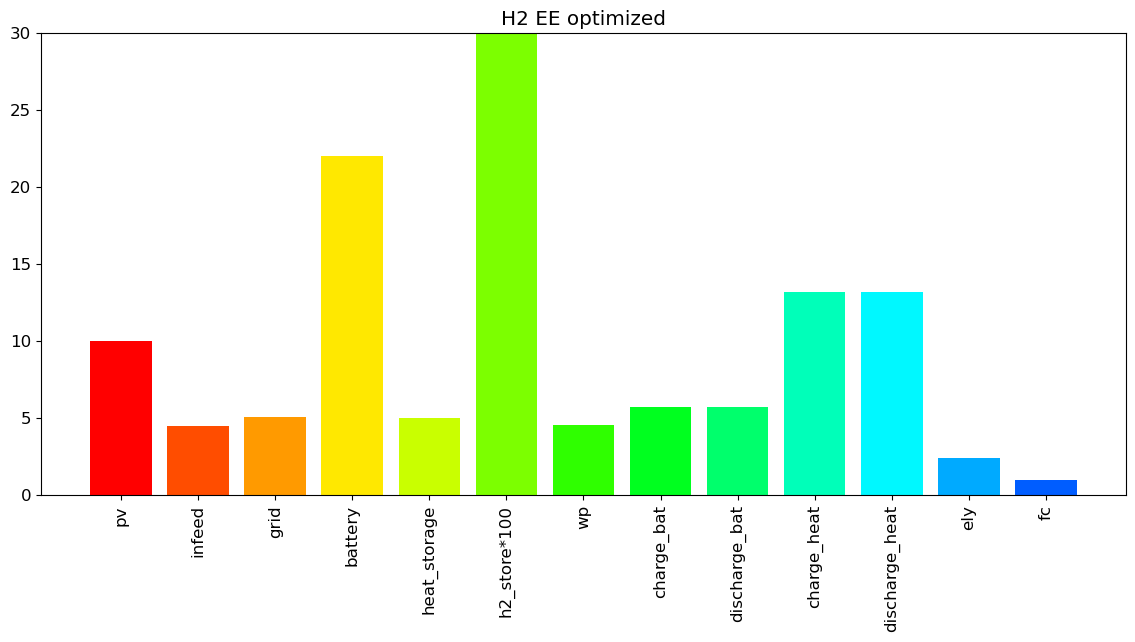

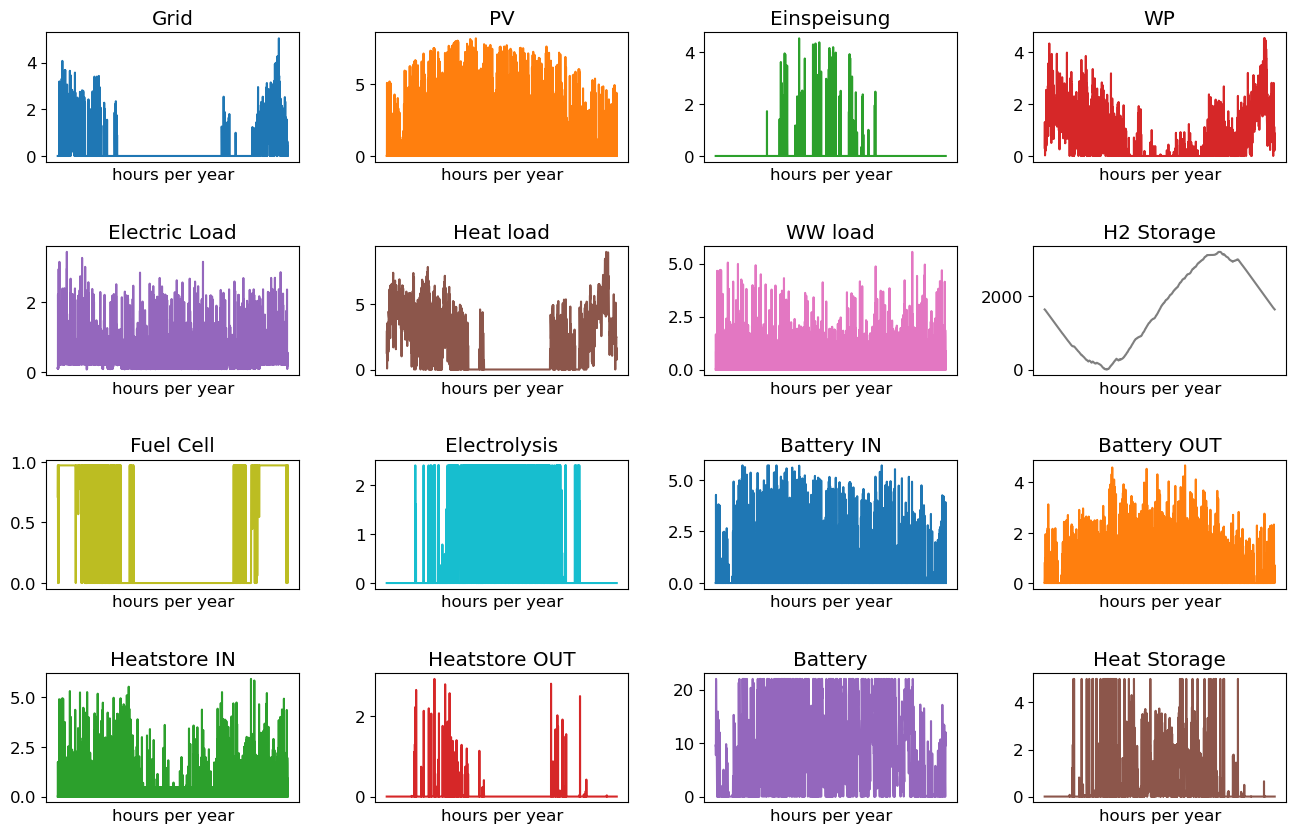

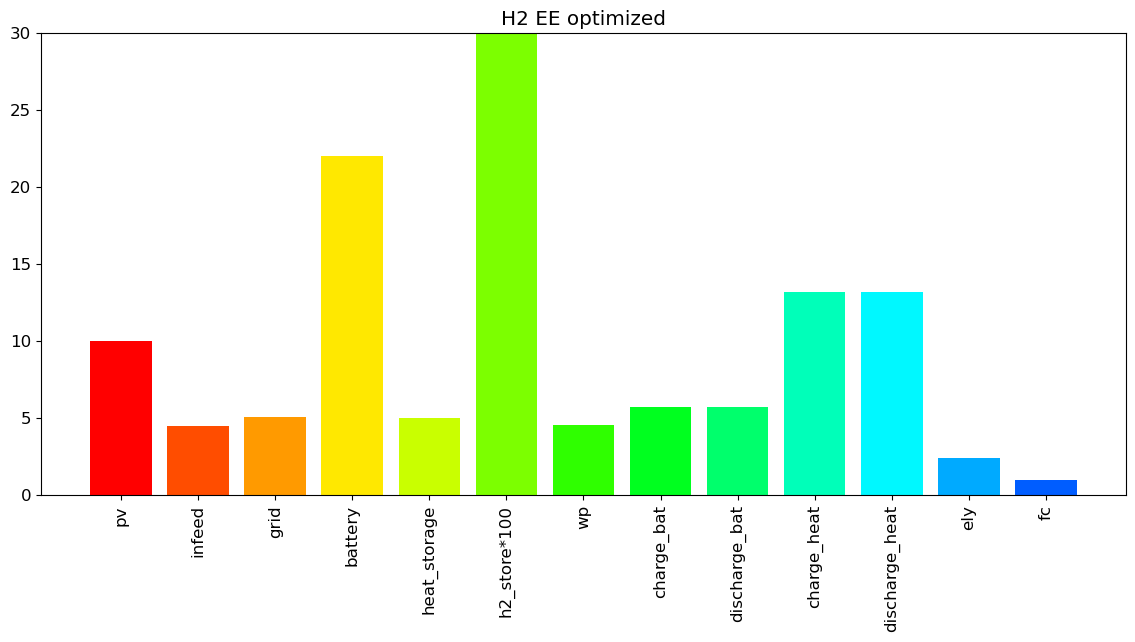

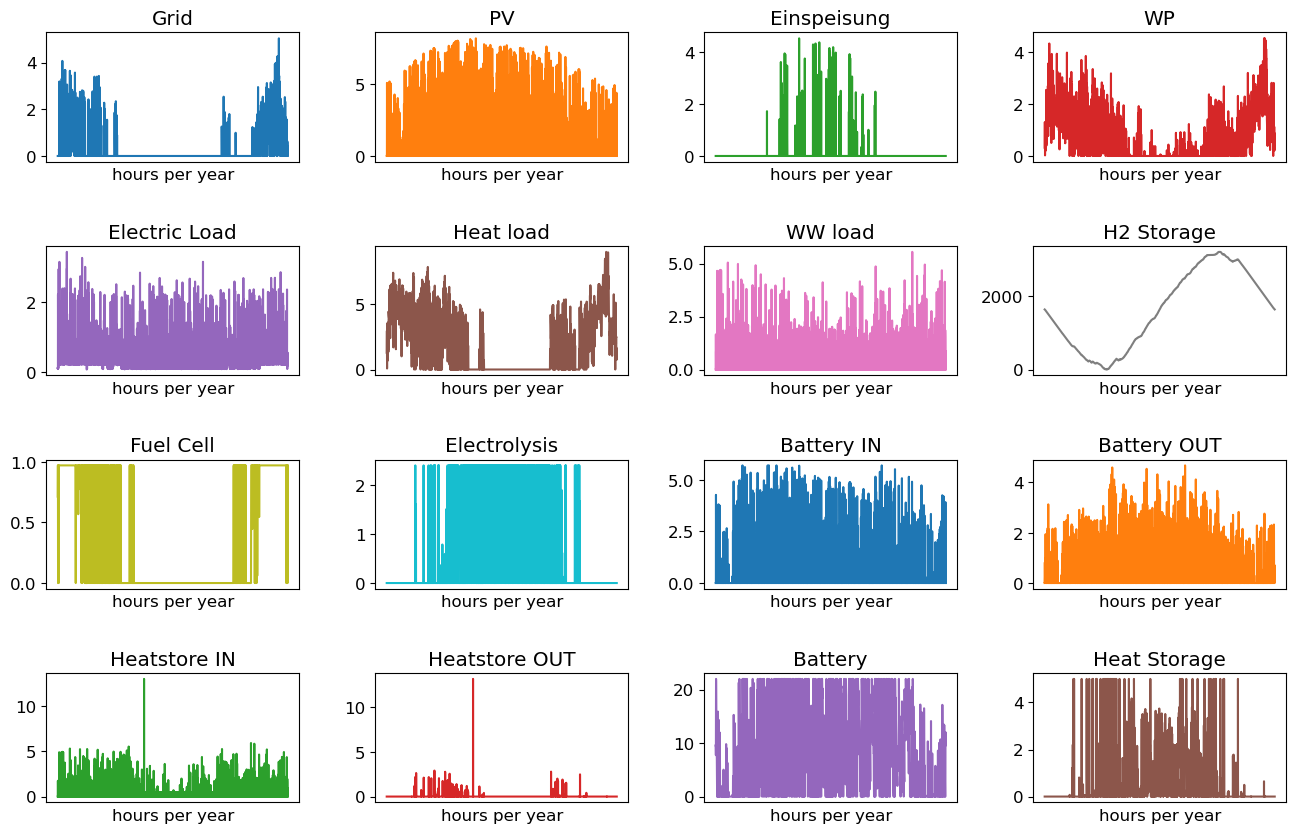

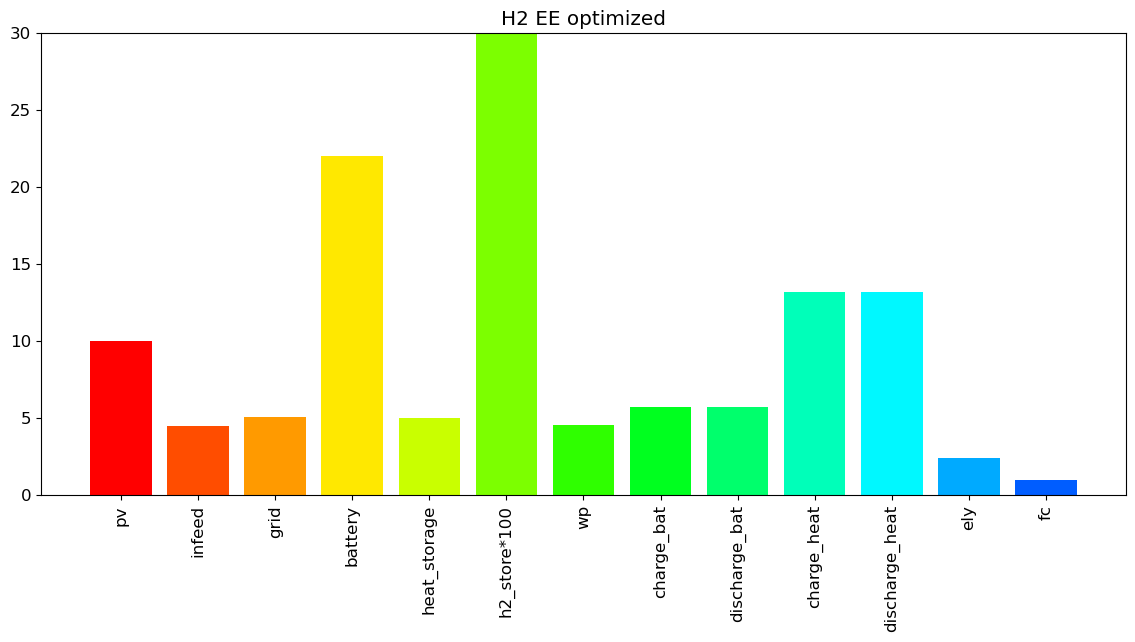

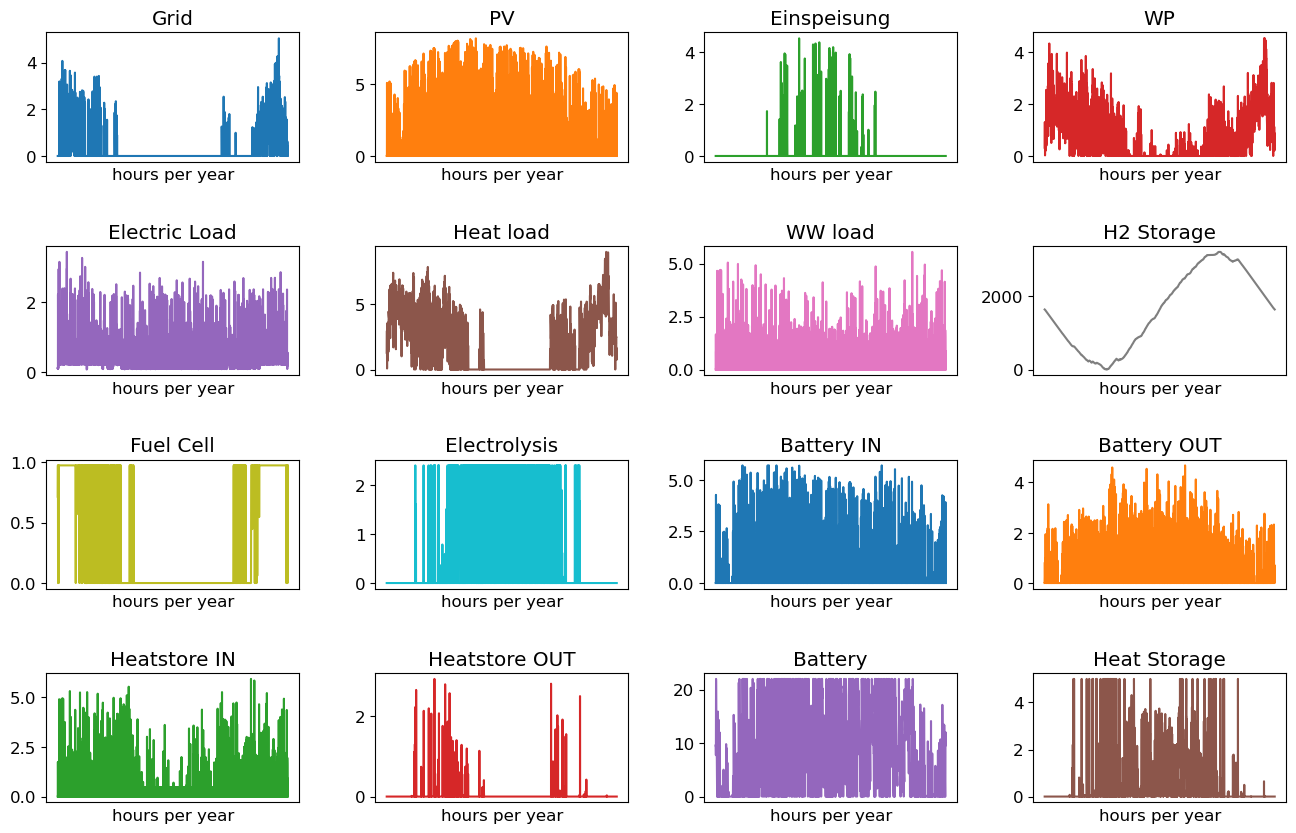

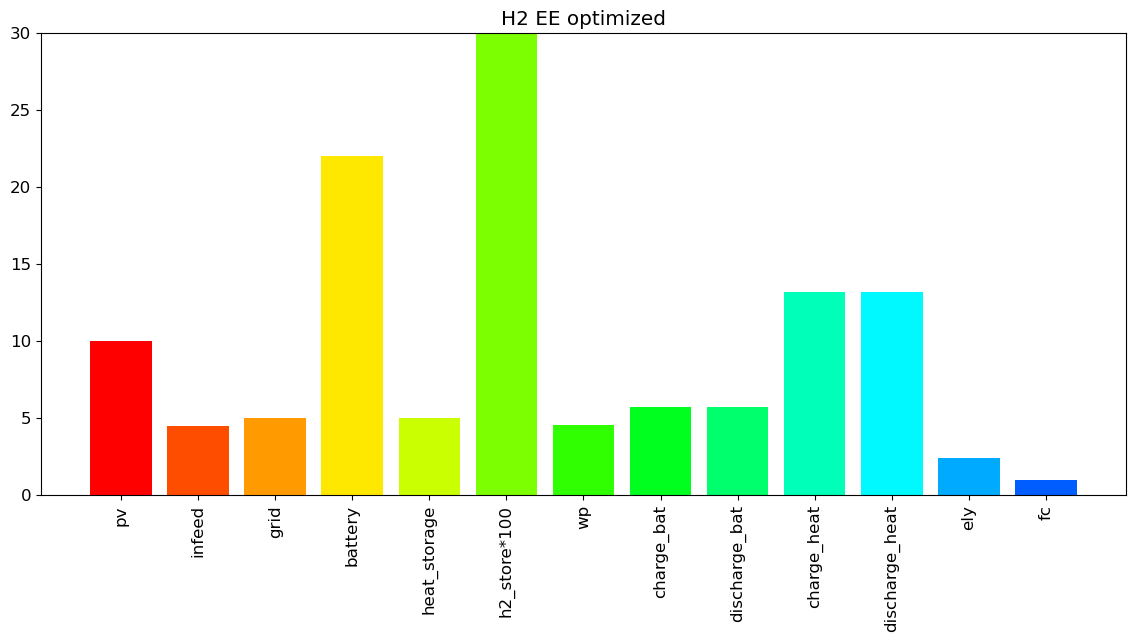

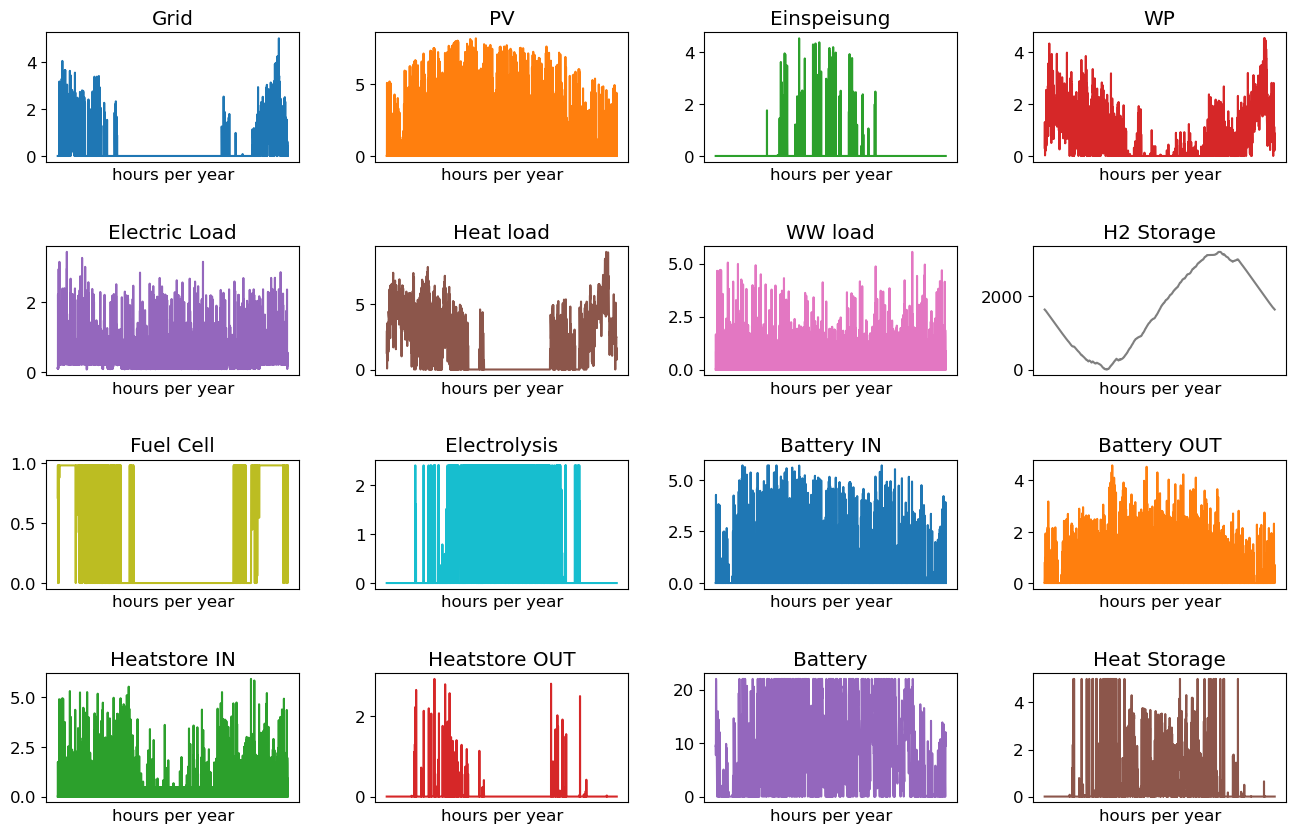

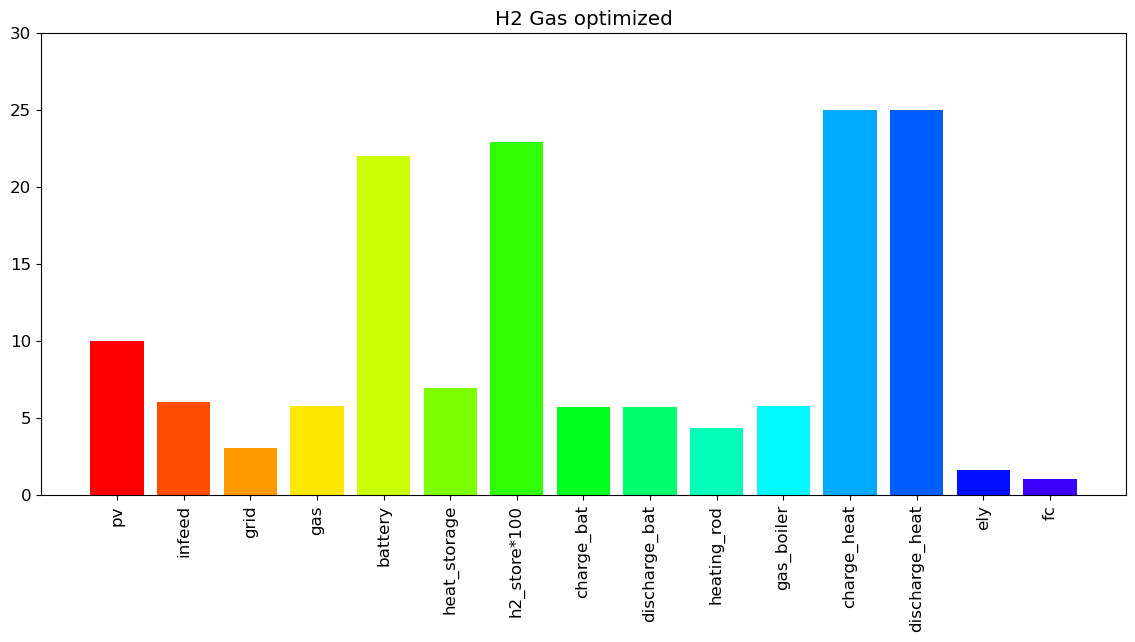

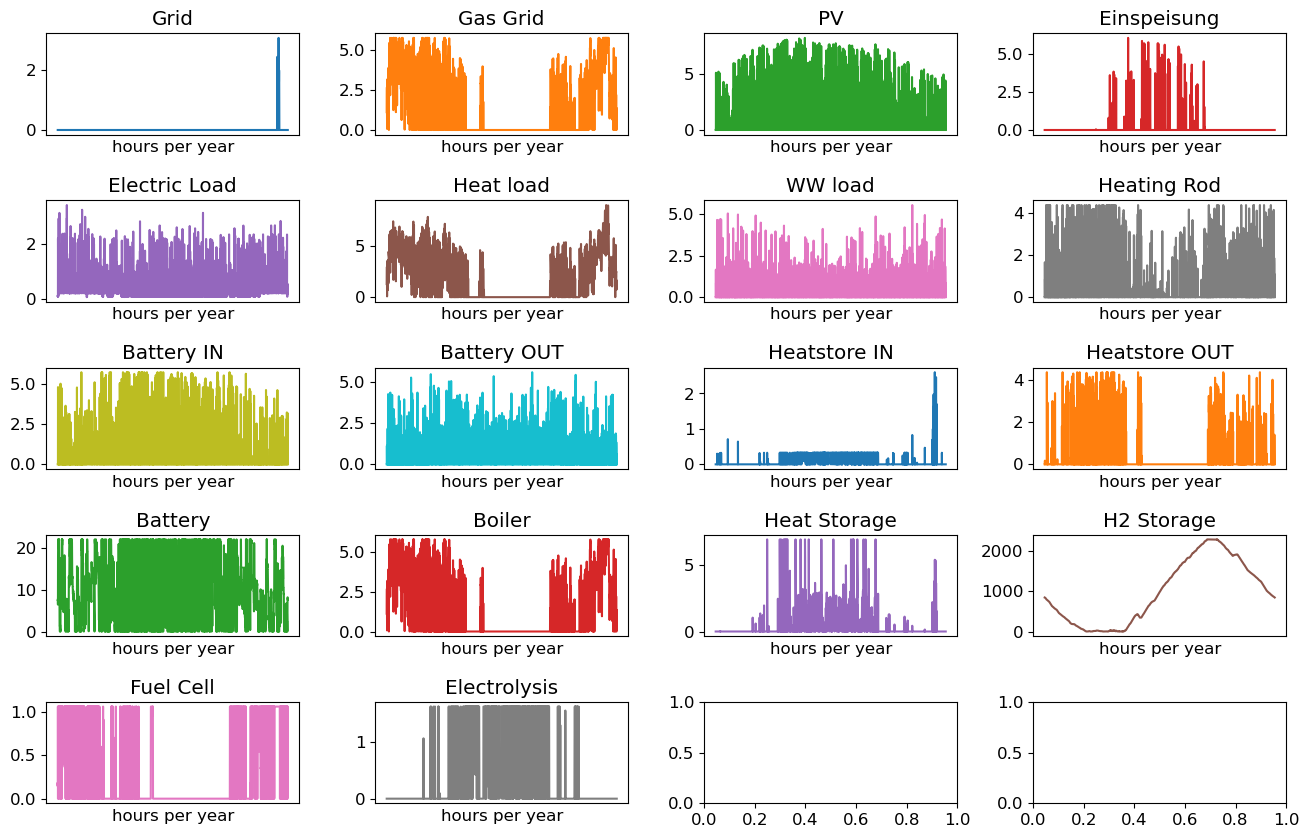

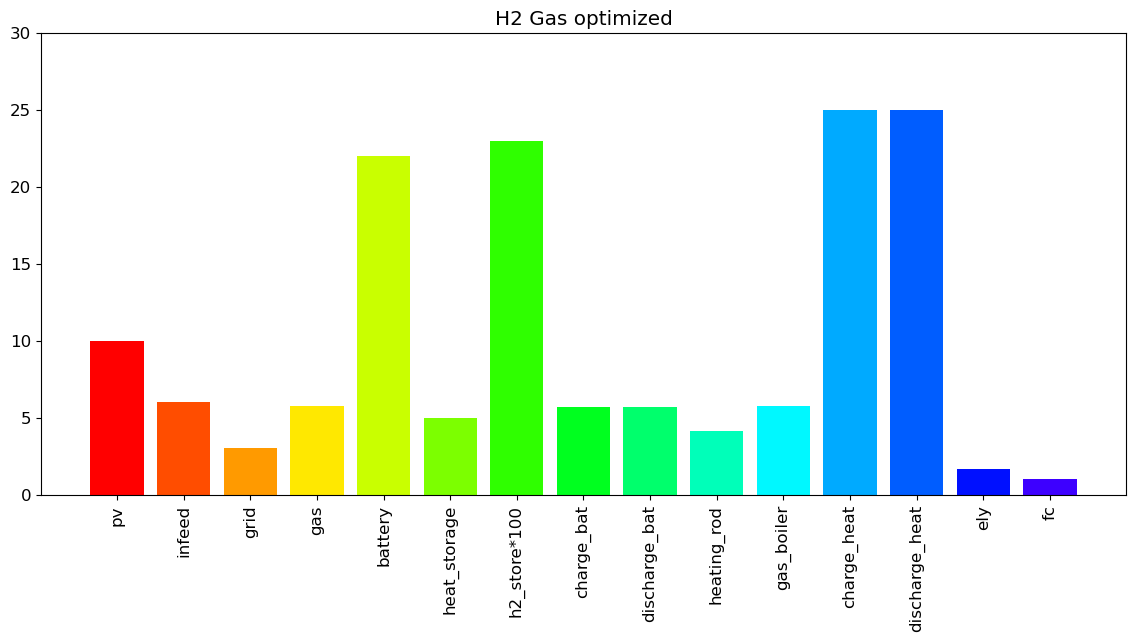

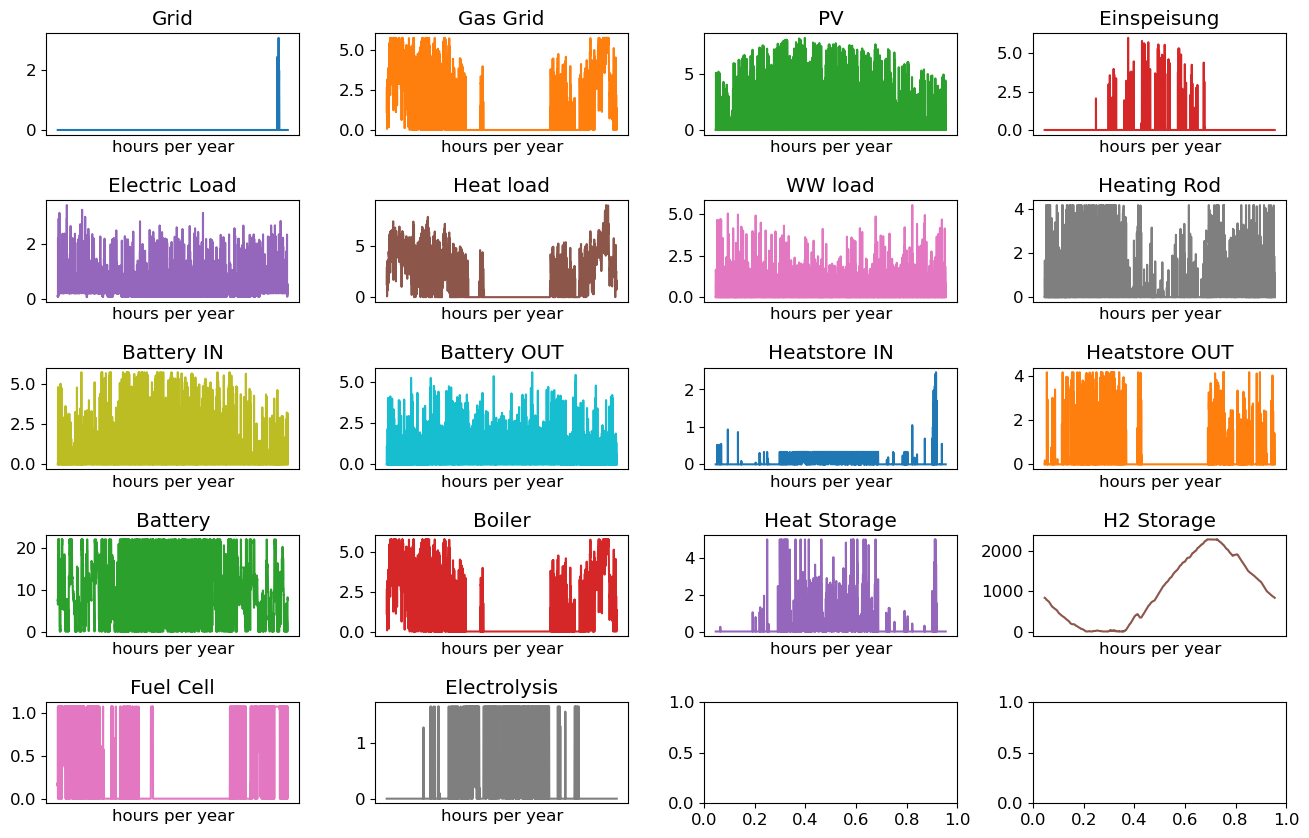

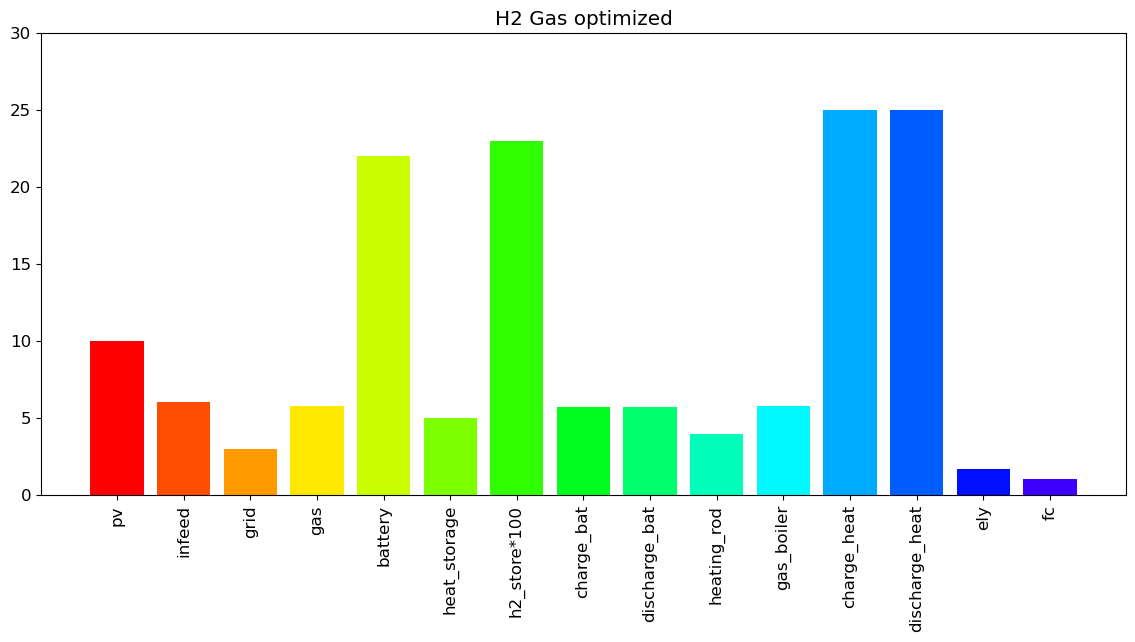

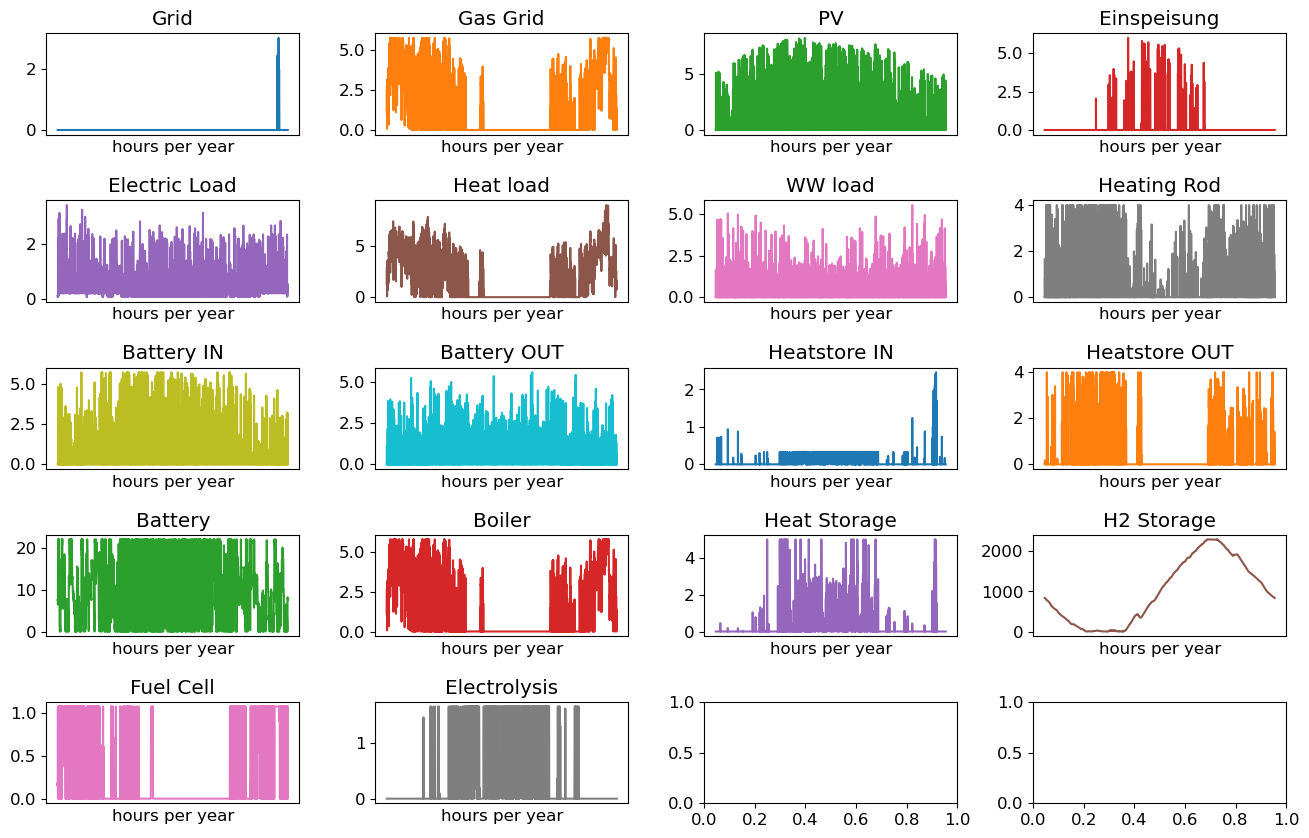

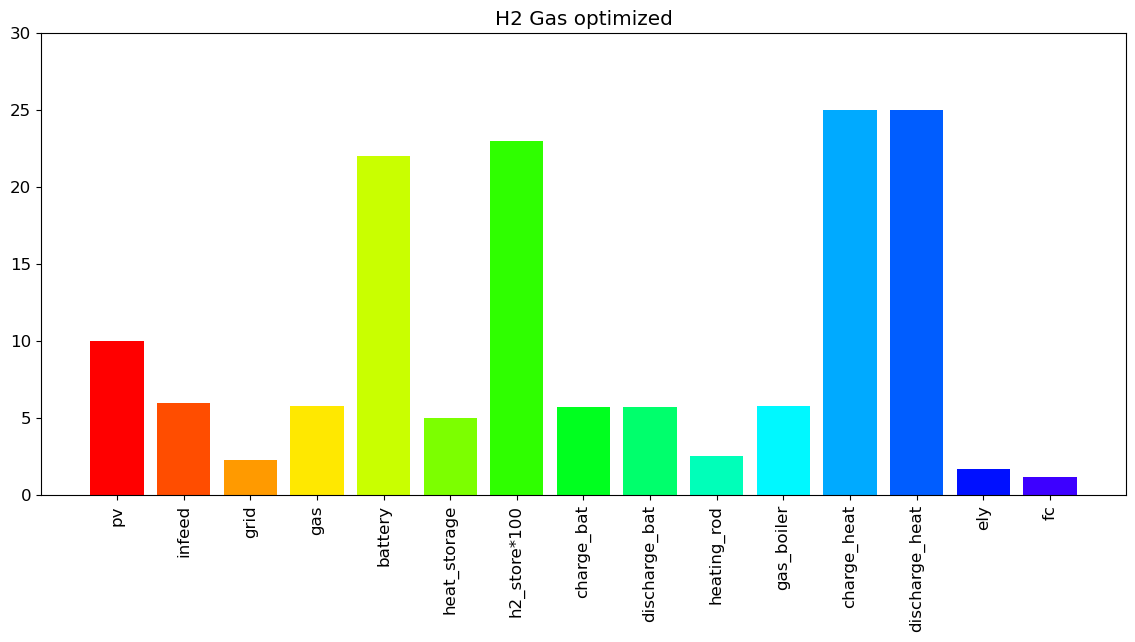

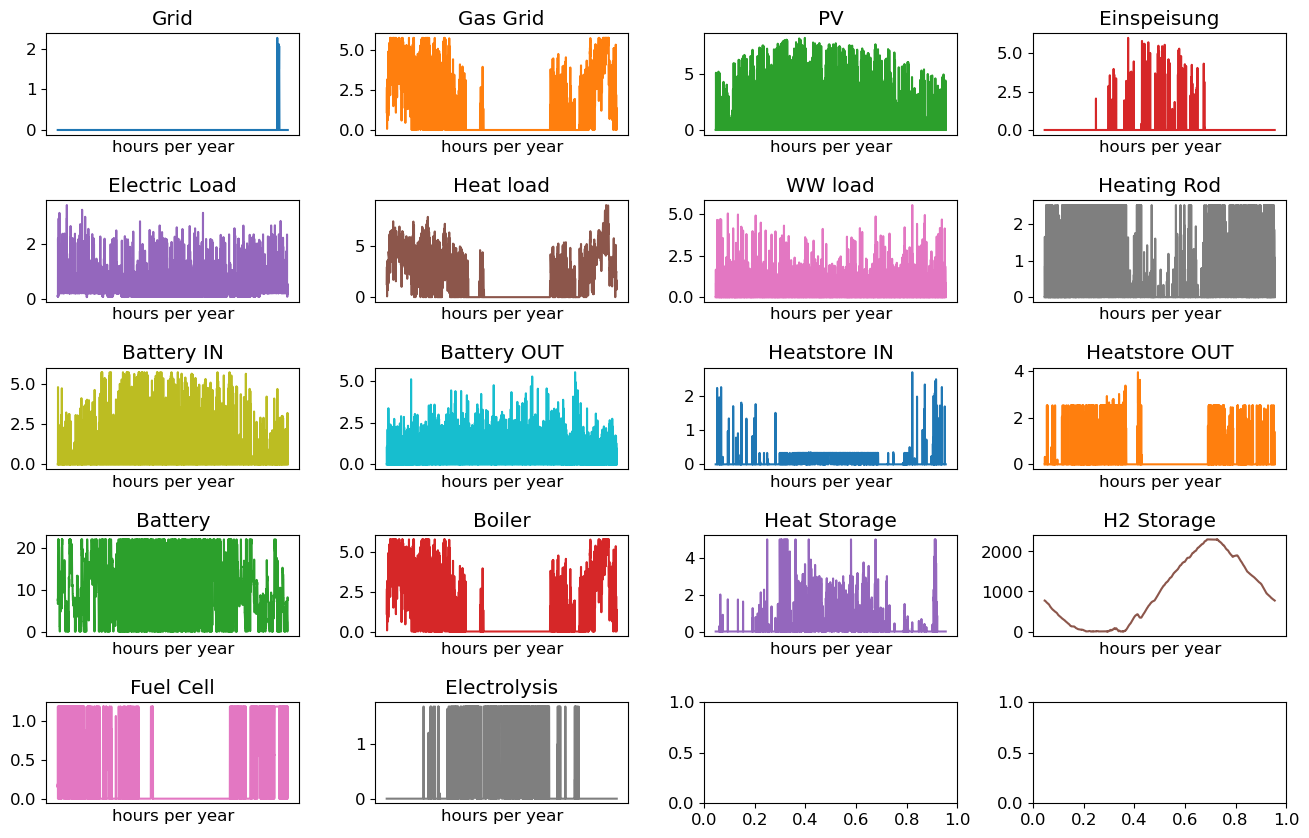

In [32]:
# sensitivity scenario 3b 
s3b_mincap_h2_storage = df_cost['min'].min() * specific_cap_share['h2_storage'] / h2_storage_params['e_nom_min']
s3b_mincap_ely = df_cost['min'].min() * specific_cap_share['ely'] / ely_params['p_nom']
s3b_mincap_fc = df_cost['min'].min() * specific_cap_share['fc'] / fc_params['p_nom']
s3b_mincap_battery = df_cost['min'].min() * specific_cap_share['battery'] / battery_picea_params['e_nom']
s3b_cap_lst = [s3b_mincap_h2_storage, s3b_mincap_ely, s3b_mincap_fc, s3b_mincap_battery]

s3b_cost_lvl_gas = {}
s3b_cost_lvl_ee = {}


for i in np.arange(1, 0, -0.32):
    s3b_cost_lvl_gas[i] = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
    s3b_cost_lvl_gas[i].stores.loc['h2_storage', 'capital_cost'] = s3b_cap_lst[0] * i
    s3b_cost_lvl_gas[i].links.loc['ely', 'capital_cost'] = s3b_cap_lst[1] * i
    s3b_cost_lvl_gas[i].links.loc['fc', 'capital_cost'] = s3b_cap_lst[2] * i
    s3b_cost_lvl_gas[i].stores.loc['battery', 'capital_cost'] = s3b_cap_lst[3] * i
    s3b_cost_lvl_gas[i].links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
    s3b_cost_lvl_gas[i].links.loc['gas_boiler', 'p_nom_extendable'] = False
    s3b_cost_lvl_gas[i].stores.loc['h2_storage', 'e_nom_max'] = np.inf
    s3b_cost_lvl_gas[i].global_constraints.loc['co2-limit', 'constant'] = co2_lim_gas
    
    s3b_cost_lvl_ee[i] = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
    s3b_cost_lvl_ee[i].stores.loc['h2_storage', 'capital_cost'] = s3b_cap_lst[0] * i
    s3b_cost_lvl_ee[i].links.loc['ely', 'capital_cost'] = s3b_cap_lst[1] * i
    s3b_cost_lvl_ee[i].links.loc['fc', 'capital_cost'] = s3b_cap_lst[2] * i
    s3b_cost_lvl_ee[i].stores.loc['battery', 'capital_cost'] = s3b_cap_lst[3] * i
    s3b_cost_lvl_ee[i].links.loc['wp', 'p_nom'] = p_nom_opt_wp
    s3b_cost_lvl_ee[i].links.loc['wp', 'p_nom_extendable'] = False
    s3b_cost_lvl_ee[i].stores.loc['h2_storage', 'e_nom_max'] = np.inf
    s3b_cost_lvl_ee[i].global_constraints.loc['co2-limit', 'constant'] = co2_lim_ee
    
print("!----------------------------networks initialized------------------------------!")

s3b_res_gas = pd.DataFrame()
s3b_res_ee = pd.DataFrame()
s3b_res_sum_gas = {}
s3b_res_sum_ee = {}
for key, val in s3b_cost_lvl_ee.items():
    print("Current Capital Cost H2-System EE-Network: ", sum(s3b_cap_lst) * key)
    s3b_cost_lvl_ee[key].optimize(solver_name='gurobi')
    s3b_res_ee = s3b_res_ee.append(result_summary_single_network(s3b_cost_lvl_ee[key], h2=True, sensitivity_variable=key))
    s3b_res_sum_ee[key] = result_summary_single_network(s3b_cost_lvl_ee[key], h2=True, plots=True)
for key, val in s3b_cost_lvl_gas.items():
    print("Current Capital Cost H2-System Gas-Network: ", sum(s3b_cap_lst) * key)
    s3b_cost_lvl_gas[key].optimize(solver_name='gurobi')
    s3b_res_gas = s3b_res_gas.append(result_summary_single_network(s3b_cost_lvl_gas[key], h2_gas=True, sensitivity_variable=key))
    s3b_res_sum_gas[key] = result_summary_single_network(s3b_cost_lvl_gas[key], h2_gas=True, plots=True)
print("!----------------------------results scenario 3b:------------------------------!")

# print(s3b_res_sum_ee, "\n\n", s3b_res_sum_gas)
print(s3b_res_ee, "\n\n", s3b_res_gas)

### Sensitivität 4
#### Sensitivität 4a
#### Sensitivität 4b

In [53]:
# sensitivity scenario 4a
# co2 emissionen - minimum
# kapitalkosten - festlegen auf die notwendigen kapitalkosten für Amortisation = 25 Jahre
# lifetime H2: beginn 10 Jahre
s4a_res_gas = pd.DataFrame()
lifetime_lst = range(10, 21, 2)
print(multi_years)
s4a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=True)
s4a_gas_network.optimize(solver_name='gurobi')
s4a_res_gas = result_summary_single_network(s4a_gas_network, h2_gas=True, MI_analyse_network=True)

s4a_res_gas


range(2023, 2044, 3)
Settings: 
 Multi-Invest ON?:  True 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023


C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-qft48s_6.lp
Reading time = 5.37 seconds
obj: 3004705 rows, 1471697 columns, 6336298 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3004705 rows, 1471697 columns and 6336298 nonzeros
Model fingerprint: 0x361e5a3a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2064591 rows and 470252 columns
Presolve time: 2.88s
Presolved: 940114 rows, 1001445 columns, 3290210 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1471697 primals, 3004705 duals
Objective: -3.38e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\3271398808.py:193: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\3271398808.py:195: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Marvin\AppData\Local\Temp\ipykernel_4088\3271398808.py:207: RuntimeWarning:

invalid value encountered in double_scalars



(                          Grid  Gas Grid   PV  Einspeisung  Electric Load  \
 2023 2023-01-01 00:00:00   0.0       0.0  0.0          0.0            0.0   
      2023-01-01 01:00:00   0.0       0.0  0.0          0.0            0.0   
      2023-01-01 02:00:00   0.0       0.0  0.0          0.0            0.0   
      2023-01-01 03:00:00   0.0       0.0  0.0          0.0            0.0   
      2023-01-01 04:00:00   0.0       0.0  0.0          0.0            0.0   
 ...                        ...       ...  ...          ...            ...   
 2041 2041-12-31 19:00:00   0.0       0.0  0.0          0.0            0.0   
      2041-12-31 20:00:00   0.0       0.0  0.0          0.0            0.0   
      2041-12-31 21:00:00   0.0       0.0  0.0          0.0            0.0   
      2041-12-31 22:00:00   0.0       0.0  0.0          0.0            0.0   
      2041-12-31 23:00:00   0.0       0.0  0.0          0.0            0.0   
 
                           Heat load  WW load  Heating Rod  Ba

# Auswertung der Sensitivitätsanalysen

# Einordnung der Sensitivitäten

### Sensitivität 1: Notwendige Kostenreduktion der Wasserstoffkomponenten

> Notwendige Bedingung: Nicht erfüllt!</br>
Keine Komponente des Wasserstoffsystems wurde auf eine Leistung dimensioniert.</br>
Das bedeutet, dass auch eine Reduzierung der Systemkosten um 78% gegenüber den aktuellen Preisen aus ökonomischer Sicht kein Anreiz für eine Saisonale Wasserstoffspeicherung besteht.


# Simulation mit ermittelten Werten für verschiedene Personenanzahlen

##### Grundparameter:
1. Ermittelte notwendige Kapitalkosten des Wasserstoffsystems
2. Ermittelte notwendige Lebensdauer des Wasserstoffsystems
3. Festlegung der Wasserstoffsystemdimensionierung aus vorangegangen Analysen
3. Variation der Lastprofile entsprechend 2-, 4-, 6-Personenhaushalt

**Simulation 1: Ermittlung der CO2-Einsparung, des PV-Eigenverbrauchsanteils und des Autarkiegrades gegenüber Referenzszenarien**
- 1a: Erweiterung um ein saisonales Wasserstoffspeicher und-versorgungssystems ausgehend von einem Gasbasierten Einfamilienhaus
- 1b: Erweiterung um ein saisonales Wasserstoffspeicher und-versorgungssystems ausgehend von einem erneuerbarbar versorgten Einfamilienhaus 



In [ ]:
# STANDARD Scenario with all 4 Networks for 4p HH for comparation purposes
s_n_rg = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
s_n_hg = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
s_n_ree = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
s_n_hee = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])

s_n_rg.optimize(solver_name='gurobi')
s_n_hg.optimize(solver_name='gurobi')
s_n_ree.optimize(solver_name='gurobi')
s_n_hee.optimize(solver_name='gurobi')

s_rg_res = result_summary_single_network(s_n_rg, ref_gas=True)
s_hg_res = result_summary_single_network(s_n_hg, h2_gas=True)
s_ree_res = result_summary_single_network(s_n_ree, ref_gas=True)
s_hee_res = result_summary_single_network(s_n_hee, ref_gas=True)

In [ ]:
# Szenario 2-4-6 Personen Haushalt bei standardbedingungen ohne weitergabe von optimierten Werten
# 4 Personen
n_rg_4 = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_hg_4 = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_ree_4 = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_hee_4 = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])

# 6 Personen
n_rg_6 = build_ref_network_gas(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_hg_6 = build_h2_network_gas(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_ree_6 = build_ref_network(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_hee_6 = build_h2_network(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])

# optimize 4 Personen
n_rg_4.optimize(solver_name='gurobi')
n_hg_4.optimize(solver_name='gurobi')
n_ree_4.optimize(solver_name='gurobi')
n_hee_4.optimize(solver_name='gurobi')

# optimize 6 Personen
n_rg_6.optimize(solver_name='gurobi')
n_hg_6.optimize(solver_name='gurobi')
n_ree_6.optimize(solver_name='gurobi')
n_hee_6.optimize(solver_name='gurobi')

In [ ]:
# 4 people - result summary of STD Szenario without dependencies between networks
df_result_4p = calc_global_results(n_rg_4, n_hg_4, n_ree_4, n_hee_4, n_all=True)
print('4 People:')
df_result_4p

In [ ]:
# 6 people - result summary of STD Szenario without dependencies between networks
df_result_6p = calc_global_results(n_rg_6, n_hg_6, n_ree_6, n_hee_6, n_all=True)
print('6 People:')
df_result_6p

In [ ]:
# PV Threshhold runter setzen von 0.55 auf 0.4 - Vergleich von EE Netzwerken
pv_thresh = 0.4
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= pv_thresh else 0)

n_rg_4th = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_hg_4th = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_hg_4th.links_t.p_max_pu.ely = df_season['ely_pv_threshhold']
n_r_4th = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_h_4th = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_h_4th.links_t.p_max_pu.ely = df_season['ely_pv_threshhold']

n_rg_4th.optimize(solver_name='gurobi')
n_hg_4th.optimize(solver_name='gurobi')
n_r_4th.optimize(solver_name='gurobi')
n_h_4th.optimize(solver_name='gurobi')

df_thresh_test = pd.concat([calc_global_results(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True),
                           calc_global_results(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True)], axis=0)
print("Comparation changes from PV Threshhold: row1-4:0.55; row5-8: new Threshhold")
df_thresh_test

# Sensitivität

In [ ]:
# CO2 Sensitivity 2,4 people households
# -> without dependencies like: optimized values from Reference Networks are transfered to H2 Networks 
all_res_2ee = {}
all_res_2g = {}
all_res_4ee = {}
all_res_4g = {}


# 2 Residents
# Ref Networks
ee2_ref = build_ref_network()
g2_ref = build_ref_network_gas()
ee2_ref.optimize(solver_name='gurobi')
g2_ref.optimize(solver_name='gurobi')

# get reference results
dfs_ee2_ref = analyse_single_network(ee2_ref, ref=True)
dfs_g2_ref = analyse_single_network(g2_ref, ref_gas=True)


# H2 Networks
ee2_h2 = build_h2_network()
g2_h2 = build_h2_network_gas()
ee2_h2.optimize(solver_name='gurobi')
g2_h2.optimize(solver_name='gurobi')

# get h2 initial results and calculate base co2
dfs_ee2_h2 = analyse_single_network(ee2_h2, h2=True)
dfs_g2_h2 = analyse_single_network(g2_h2, h2_gas=True)
base_co2_ee2 = dfs_ee2_h2[2].loc['CO2-Emission [kg/(a)]', 'analytic values']
base_co2_g2 = dfs_g2_h2[2].loc['CO2-Emission [kg/(a)]', 'analytic values']


# generate reference results for 2 Inhabitants:
results_2p_ee = analyse_single_network(ee2_ref, ref=True, sensitivity_variable='Reference')
results_2p_g = analyse_single_network(g2_ref, ref_gas=True, sensitivity_variable='Reference')

# reduce co2-Emissions step by step and add to results
for co2_lim in np.arange(1, 0.89, -0.1):
    print('Current CO2: {}%:'.format(co2_lim*100), "\nGas: ", co2_lim * base_co2_g2, '\nEE: ', co2_lim * base_co2_ee2)
    print('Inhabitants: -> 2')
    ee2_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim * base_co2_ee2
    g2_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim * base_co2_g2
    ee2_h2.optimize(solver_name='gurobi')
    g2_h2.optimize(solver_name='gurobi')
    
    results_2p_ee = results_2p_ee.append(analyse_single_network(ee2_h2, h2=True, sensitivity_variable=co2_lim))
    results_2p_g = results_2p_g.append(analyse_single_network(g2_h2, h2_gas=True, sensitivity_variable=co2_lim))
    all_res_2ee[co2_lim] = analyse_single_network(ee2_h2, h2=True)
    all_res_2g[co2_lim] = analyse_single_network(g2_h2, h2_gas=True)


# 4 Residents: 
# Ref Networks
ee4_ref = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
g4_ref = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
ee4_ref.optimize(solver_name='gurobi')
g4_ref.optimize(solver_name='gurobi')

# get reference results
dfs_ee4_ref = analyse_single_network(ee4_ref, ref=True)
dfs_g4_ref = analyse_single_network(g4_ref, ref_gas=True)


# H2 Networks
ee4_h2 = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
g4_h2 = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
ee4_h2.optimize(solver_name='gurobi')
g4_h2.optimize(solver_name='gurobi')

# calculate co2 base value
dfs_ee4_h2 = analyse_single_network(ee4_h2, h2=True)
dfs_g4_h2 = analyse_single_network(g4_h2, h2_gas=True)
base_co2_ee4 = dfs_ee4_h2[2].loc['CO2-Emission [kg/(a)]', 'analytic values']
base_co2_g4 = dfs_g4_h2[2].loc['CO2-Emission [kg/(a)]', 'analytic values']


# generate reference results for 4 Inhabitants:
results_4p_ee = analyse_single_network(ee4_ref, ref=True, sensitivity_variable='Reference')
results_4p_g = analyse_single_network(g4_ref, ref_gas=True, sensitivity_variable='Reference')

# reduce co2-Emissions step by step and add to results
for co2_lim4 in np.arange(1, 0.89, -0.1):
    print('Current CO2: {}%:'.format(co2_lim4*100), "\nGas: ", co2_lim4 * base_co2_g4, '\nEE: ', co2_lim4 * base_co2_ee4)
    print('Inhabitants: -> 4')
    ee4_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim4 * base_co2_ee4
    g4_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim4 * base_co2_g4
    ee4_h2.optimize(solver_name='gurobi')
    g4_h2.optimize(solver_name='gurobi')
    
    results_4p_ee = results_4p_ee.append(analyse_single_network(ee4_h2, h2=True, sensitivity_variable=co2_lim4))
    results_4p_g = results_4p_g.append(analyse_single_network(g4_h2, h2_gas=True, sensitivity_variable=co2_lim4))
    all_res_4ee[co2_lim4] = analyse_single_network(ee4_h2, h2=True)
    all_res_4g[co2_lim4] = analyse_single_network(g4_h2, h2_gas=True)
    
result_lst = [results_2p_ee, results_2p_g, results_4p_ee, results_4p_g]

In [ ]:
# H2 Storage Capacity influence (Scenario 2,4,6pers, EE_reference)
# build networks
sens_data_sc_ee = {}
all_res_sc_ee = {}

# loop person quantity
for pers in ['2p', '4p', '6p']:
    # setup reference network
    sc_ref = build_ref_network(electric_load=df_data['e_load_'+pers],
                               heat_load=df_data['h_load_'+pers],
                               ww_load=df_data['ww_load_'+pers])
    
    # optimize and get the reference result
    sc_ref.optimize(solver_name='gurobi')
    sens_result_sc = analyse_single_network(sc_ref, ref=True, sensitivity_variable='reference')


    # initialize h2 network
    sc_h2 = build_h2_network(electric_load=df_data['e_load_'+pers],
                             heat_load=df_data['h_load_'+pers],
                             ww_load=df_data['ww_load_'+pers])
    # set h2_storage non extendable to force dimension
    sc_h2.stores.e_nom_extendable.h2_storage = False
    
    # sensitivity analysis by looping over h2_storage capacity
    for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+501, 500):
        print('Current Capacity: ', capacity,'\nCurrent Loadsize: ', pers)
        sc_h2.stores.e_nom.h2_storage = capacity
        sc_h2.optimize(solver_name='gurobi')
        sens_result_sc = sens_result_sc.append(analyse_single_network(sc_h2, h2=True, sensitivity_variable=capacity))
        all_res_sc_ee[pers + "_" + str(capacity)] = analyse_single_network(sc_h2, h2=True, plots=True)
        
        
    # copy results according to scenario, deepcopy and delete the initial dataset
    if pers == '2p':
        sc_res_2p = sens_result_sc.copy(deep=True)
        sens_data_sc_ee[pers] = sc_res_2p
        del sens_result_sc
    if pers == '4p':
        sc_res_4p = sens_result_sc.copy(deep=True)
        sens_data_sc_ee[pers] = sc_res_4p
        del sens_result_sc
    if pers == '6p':
        sc_res_6p = sens_result_sc.copy(deep=True)
        sens_data_sc_ee[pers] = sc_res_6p
        del sens_result_sc

In [ ]:
# H2 Storage Capacity influence (Scenario 2,4,6pers, Gas_reference)
# build networks
sens_data_sc_gas = {}
all_res_sc_gas = {}

# loop person quantity
for pers in ['2p', '4p', '6p']:
    # setup reference network
    sc_ref = build_ref_network_gas(electric_load=df_data['e_load_'+pers],
                                   heat_load=df_data['h_load_'+pers],
                                   ww_load=df_data['ww_load_'+pers])
    
    # optimize and get the reference result
    sc_ref.optimize(solver_name='gurobi')
    sens_result_sc = analyse_single_network(sc_ref, ref_gas=True, sensitivity_variable='reference')


    # initialize h2 network
    sc_h2 = build_h2_network_gas(electric_load=df_data['e_load_'+pers],
                                 heat_load=df_data['h_load_'+pers],
                                 ww_load=df_data['ww_load_'+pers])
    # set h2_storage non extendable to force dimension
    sc_h2.stores.e_nom_extendable.h2_storage = False
    
    # sensitivity analysis by looping over h2_storage capacity
    for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+501, 500):
        print('Current Capacity: ', capacity,'\nCurrent Loadsize: ', pers)
        sc_h2.stores.e_nom.h2_storage = capacity
        sc_h2.optimize(solver_name='gurobi')
        sens_result_sc = sens_result_sc.append(analyse_single_network(sc_h2, h2_gas=True, sensitivity_variable=capacity))
        all_res_sc_gas[pers + "_" + str(capacity)] = analyse_single_network(sc_h2, h2_gas=True, plots=True)
        
        
    # copy results according to scenario, deepcopy and delete the initial dataset
    if pers == '2p':
        sc_res_2p = sens_result_sc.copy(deep=True)
        sens_data_sc_gas[pers] = sc_res_2p
        del sens_result_sc
    if pers == '4p':
        sc_res_4p = sens_result_sc.copy(deep=True)
        sens_data_sc_gas[pers] = sc_res_4p
        del sens_result_sc
    if pers == '6p':
        sc_res_6p = sens_result_sc.copy(deep=True)
        sens_data_sc_gas[pers] = sc_res_6p
        del sens_result_sc
    

In [ ]:
#ALT co2 SENSITIVITÄTSTEST
'''
#n_ref = build_ref_network()

n_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen
n_ref.optimize(solver_name='gurobi')

#n_h2 = build_h2_network()
#n_ref.optimize(solver_name='gurobi')

results_ref = auswertungsfunktion(n_ref,100,0)
basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen

for co2_limit in np.flip(np.arange(0.7, 1, 0.10)):
    print(co2_limit* basis_co2_emissions)
    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_ref.optimize(solver_name='gurobi')
    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))
    '''

In [ ]:
#ALT co2 SENSITIVITÄTSTEST

'''
n_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#Iterationen
#n_ref = build_ref_network()
#n_h2 = build_h2_network()
n_h2.optimize(solver_name='gurobi')
#results_ref = pd.DataFrame()
#results_h2 = pd.DataFrame()
results_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))
basis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


for co2_limit in np.flip(np.arange(0.5, 1, 0.2)):
    print(co2_limit* basis_co2_emissions)
    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_h2.optimize(solver_name='gurobi')
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))
  

for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_ref.optimize(solver_name = 'gurobi')
    n_h2.optimize(solver_name='gurobi')
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))
'''


In [ ]:
#ALT!!! - Test mit statischem Preis (1) und Preisprofil (2)
'''
# setup reference networks
n_ref1 = build_ref_network()

n_ref2 = build_ref_network()
n_ref2.generators_t.marginal_cost.grid = df_price_data["2021"]
# optimize
n_ref1.optimize(solver_name='gurobi')
n_ref2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy1 = build_h2_network()
#n_hy1.stores.e_nom.battery = n_ref1.stores.e_nom_opt.battery
n_hy1.stores.e_nom.heat_storage = n_ref1.stores.e_nom_opt.heat_storage
n_hy1.links.p_nom.wp = n_ref1.links.p_nom_opt.wp
#n_hy1.links_t.p_max_pu.ely = df_season["ely"]
#n_hy1.links_t.p_max_pu.fc = df_season["fc"]

n_hy2 = build_h2_network()
#n_hy2.stores.e_nom.battery = n_ref2.stores.e_nom_opt.battery
n_hy2.stores.e_nom.heat_storage = n_ref2.stores.e_nom_opt.heat_storage
n_hy2.links.p_nom.wp = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.charge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.discharge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.generators_t.marginal_cost.grid = df_price_data["2021"]
#n_hy2.links_t.p_max_pu.ely = df_season["ely"]
#n_hy2.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy1.optimize(solver_name='gurobi')
n_hy2.optimize(solver_name='gurobi')

ref1_data = opt_series_summary(n_ref1, ref=True)
ref2_data = opt_series_summary(n_ref2, ref=True)
hy1_data = opt_series_summary(n_hy1, h2=True)
hy2_data = opt_series_summary(n_hy2, h2=True)
'''

In [ ]:
#ALT!!! - Test mit statischem Preis (1) und Preisprofil (2)
'''
# setup reference networks
n_gas1 = build_ref_network_gas()

n_gas2 = build_ref_network_gas()
n_gas2.generators_t.marginal_cost.grid = df_price_data["2022"]
# optimize
n_gas1.optimize(solver_name='gurobi')
n_gas2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy3 = build_h2_network()
#n_hy3.stores.e_nom.battery = n_gas1.stores.e_nom_opt.battery
n_hy3.stores.e_nom.heat_storage = n_gas1.stores.e_nom_opt.heat_storage

n_hy4 = build_h2_network()
#n_hy4.stores.e_nom.battery = n_gas2.stores.e_nom_opt.battery
n_hy4.stores.e_nom.heat_storage = n_gas2.stores.e_nom_opt.heat_storage
n_hy4.links.p_nom_max.charge_heat = n_gas2.links.p_nom_opt.gas_boiler
n_hy4.links.p_nom_max.discharge_heat = n_gas2.links.p_nom_opt.gas_boiler
n_hy4.generators_t.marginal_cost.grid = df_price_data["2022"]
#n_hy4.links_t.p_max_pu.ely = df_season["ely"]
#n_hy4.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy3.optimize(solver_name='gurobi')
n_hy4.optimize(solver_name='gurobi')

gas1_data = opt_series_summary(n_gas1, ref_gas=True)
gas2_data = opt_series_summary(n_gas2, ref_gas=True)
hy3_data = opt_series_summary(n_hy3, h2=True)
hy4_data = opt_series_summary(n_hy4, h2=True)
'''